In [5]:
# Function to load a saved model (for later use)
def load_saved_model(checkpoint_path, model=None, optimizer=None):
    """
    Load a saved model from checkpoint.
    
    Parameters:
    -----------
    checkpoint_path : str
        Path to the checkpoint directory or specific checkpoint
    model : tf.keras.Model, optional
        Model to load weights into. If None, only the optimizer state is loaded.
    optimizer : tf.keras.optimizers.Optimizer, optional
        Optimizer to load state into. If None, only the model weights are loaded.
        
    Returns:
    --------
    model : The model with loaded weights
    """
    if model is None and optimizer is None:
        raise ValueError("At least one of model or optimizer must be provided")
    
    checkpoint = tf.train.Checkpoint()
    
    if model is not None:
        checkpoint.model = model
    if optimizer is not None:
        checkpoint.optimizer = optimizer
        
    # Check if path is a directory or specific checkpoint
    if os.path.isdir(checkpoint_path):
        # If it's a directory, find the latest checkpoint
        latest_checkpoint = tf.train.latest_checkpoint(checkpoint_path)
        if latest_checkpoint is None:
            raise FileNotFoundError(f"No checkpoints found in directory {checkpoint_path}")
        checkpoint_path = latest_checkpoint
    
    # Restore from checkpoint
    checkpoint.restore(checkpoint_path).expect_partial()
    
    print(f"Model restored from {checkpoint_path}")
    return model

In [6]:
import tensorflow as tf
import psutil
import numpy as np 
import networkx as nx 
import sonnet as snt
import os
import time
import datetime
import gc

from dataclasses import dataclass, field

# Import required modules
from compgraph.tensorflow_version.graph_tuple_manipulation import initialize_graph_tuples_tf_opt, precompute_graph_structure
from compgraph.tensorflow_version.logging_tf import log_gradient_norms, setup_tensorboard_loggingv2
from compgraph.tensorflow_version.memory_control import aggressive_memory_cleanup, count_tf_objects, inspect_tf_functions
from simulation.initializer import create_graph_from_ham, initialize_NQS_model_fromhyperparams, initialize_hamiltonian_and_groundstate
from compgraph.useful import copy_to_non_trainable

In [7]:
import tensorflow as tf
import psutil
import numpy as np 
import networkx as nx 
import sonnet as snt
import os
import time
import datetime
import gc
from dataclasses import dataclass, field

# Import required modules
from compgraph.tensorflow_version.graph_tuple_manipulation import initialize_graph_tuples_tf_opt, precompute_graph_structure
from compgraph.tensorflow_version.logging_tf import log_gradient_norms, setup_tensorboard_loggingv2
from compgraph.tensorflow_version.memory_control import aggressive_memory_cleanup, count_tf_objects, inspect_tf_functions
from simulation.initializer import create_graph_from_ham, initialize_NQS_model_fromhyperparams, initialize_hamiltonian_and_groundstate
from compgraph.useful import copy_to_non_trainable

# Define the data classes locally instead of importing them
@dataclass(frozen=True)
class GraphParams:
    graphType: str = "2dsquare"
    n: int = 2
    m: int = 2
    sublattice: str = "Neel"

@dataclass(frozen=True)
class SimParams:
    beta: float = 0.2
    learning_rate: float = 7e-6
    outer_loop: int = 500
    inner_loop: int = 30
    gradient: str = 'energy'

@dataclass
class Hyperams:
    symulation_type: str = "ExactVMC"
    graph_params: GraphParams = field(default_factory=GraphParams)
    sim_params: SimParams = field(default_factory=SimParams)
    ansatz: str = "GNN2simple"
    ansatz_params: dict = field(default_factory=lambda: {"hidden_size": 64, "output_emb_size": 32})

# Load saved model function
def load_saved_model(checkpoint_path, model=None, optimizer=None):
    """
    Load a saved model from checkpoint.
    
    Parameters:
    -----------
    checkpoint_path : str
        Path to the checkpoint directory or specific checkpoint
    model : tf.keras.Model, optional
        Model to load weights into. If None, only the optimizer state is loaded.
    optimizer : tf.keras.optimizers.Optimizer, optional
        Optimizer to load state into. If None, only the model weights are loaded.
        
    Returns:
    --------
    model : The model with loaded weights
    """
    if model is None and optimizer is None:
        raise ValueError("At least one of model or optimizer must be provided")
    
    checkpoint = tf.train.Checkpoint()
    
    if model is not None:
        checkpoint.model = model
    if optimizer is not None:
        checkpoint.optimizer = optimizer
        
    # Check if path is a directory or specific checkpoint
    if os.path.isdir(checkpoint_path):
        # If it's a directory, find the latest checkpoint
        latest_checkpoint = tf.train.latest_checkpoint(checkpoint_path)
        if latest_checkpoint is None:
            raise FileNotFoundError(f"No checkpoints found in directory {checkpoint_path}")
        checkpoint_path = latest_checkpoint
    
    # Restore from checkpoint
    checkpoint.restore(checkpoint_path).expect_partial()
    
    print(f"Model restored from {checkpoint_path}")
    return model

def extract_hyperparams_from_path(log_dir_path):
    """
    Extract hyperparameters from a tensorboard log directory path.
    
    Parameters:
    -----------
    log_dir_path : str
        Path to the tensorboard log directory
        
    Returns:
    --------
    dict : Dictionary of extracted hyperparameters
    """
    # Extract the base path components
    path_components = log_dir_path.split('/')
    
    # Extract system type
    system_type = None
    for component in path_components:
        if component.startswith('system_'):
            system_type = component.replace('system_', '')
    
    # Extract lattice information from the component after system type
    lattice_info = None
    for i, component in enumerate(path_components):
        if component.startswith('system_') and i+1 < len(path_components):
            lattice_info = path_components[i+1]
            break
    
    # Parse lattice type and dimensions
    lattice_type = None
    n = None
    m = None
    initialization = None
    
    if lattice_info:
        # Split by underscore
        lattice_parts = lattice_info.split('_')
        
        # First part is the lattice type (e.g., '2dsquare')
        if len(lattice_parts) > 0:
            lattice_type = lattice_parts[0]
        
        # Get dimensions if available
        if len(lattice_parts) > 2:
            try:
                n = int(lattice_parts[1])
                m = int(lattice_parts[2])
            except ValueError:
                pass
        
        # Check if there's initialization info (e.g., 'Neel')
        if len(lattice_parts) > 3:
            initialization = lattice_parts[3]
    
    # Extract hyperparameters from the final component
    hyperparams_component = path_components[-1]
    hyperparams_parts = hyperparams_component.split('_')
    
    beta = None
    learning_rate = None
    outer_loop = None
    inner_loop = None
    gradient_type = None
    model_type = None
    
    for part in hyperparams_parts:
        if part.startswith('beta'):
            try:
                beta = float(part.replace('beta', ''))
            except ValueError:
                pass
        elif part.startswith('lr'):
            try:
                learning_rate = float(part.replace('lr', ''))
            except ValueError:
                pass
        elif 'x' in part and part[0].isdigit() and part[-1].isdigit():
            # Extract loop values (e.g., '500x30')
            loop_parts = part.split('x')
            if len(loop_parts) == 2:
                try:
                    outer_loop = int(loop_parts[0])
                    inner_loop = int(loop_parts[1])
                except ValueError:
                    pass
        elif part in ['energy', 'overlap']:
            gradient_type = part
        elif part in ['ExactVMC']:
            model_type = part
    
    # Compile all extracted information
    hyperparams = {
        'system_type': system_type,
        'lattice': {
            'type': lattice_type,
            'n': n,
            'm': m,
            'initialization': initialization
        },
        'simulation': {
            'beta': beta,
            'learning_rate': learning_rate,
            'outer_loop': outer_loop,
            'inner_loop': inner_loop,
            'gradient_type': gradient_type,
            'model_type': model_type
        }
    }
    
    return hyperparams


def load_model_from_checkpoint_path(log_dir_path, checkpoint_name=None):
    """
    Load a model from a checkpoint in the given log directory.
    
    Parameters:
    -----------
    log_dir_path : str
        Path to the tensorboard log directory
    checkpoint_name : str, optional
        Name of the specific checkpoint to load. If None, loads the latest checkpoint.
        Can be 'initial_model', 'final_model', or a specific checkpoint number.
        
    Returns:
    --------
    model : Loaded model with weights from the checkpoint
    """
    # Clean up the log directory path to handle potential checkpoint paths
    if "checkpoints" in log_dir_path:
        log_dir_base = log_dir_path.split("/checkpoints")[0]
    else:
        log_dir_base = log_dir_path
    
    # Initialize a new model with the same architecture from base path
    model, extracted_params = initialize_model_from_log_path(log_dir_base)
    
    # Construct the checkpoint directory path
    checkpoint_dir = os.path.join(log_dir_base, "checkpoints")
    
    # Determine the checkpoint path
    if checkpoint_name is None:
        # Load the latest checkpoint
        checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir)
        if checkpoint_path is None:
            raise FileNotFoundError(f"No checkpoints found in directory {checkpoint_dir}")
    elif checkpoint_name in ['initial_model', 'final_model']:
        # For named checkpoints, check if index file exists
        base_path = os.path.join(checkpoint_dir, checkpoint_name)
        if tf.io.gfile.exists(f"{base_path}.index") or tf.io.gfile.exists(f"{base_path}-1.index"):
            # Use the base path - TensorFlow will find the associated files
            checkpoint_path = base_path
        else:
            # If the exact name doesn't exist, try with -1 suffix
            suffix_path = f"{base_path}-1"
            if tf.io.gfile.exists(f"{suffix_path}.index"):
                checkpoint_path = suffix_path
            else:
                raise FileNotFoundError(f"Could not find checkpoint {checkpoint_name} in {checkpoint_dir}")
    else:
        # Try to load a numbered checkpoint (ckpt-XX)
        if checkpoint_name.startswith("ckpt-"):
            checkpoint_path = os.path.join(checkpoint_dir, checkpoint_name)
        else:
            # Add prefix if just the number was provided
            checkpoint_path = os.path.join(checkpoint_dir, f"ckpt-{checkpoint_name}")
    
    print(f"Loading checkpoint from: {checkpoint_path}")
    
    # Generate sample input to initialize the model
    n_sites = model.n_sites if hasattr(model, 'n_sites') else None
    if n_sites is None:
        # If n_sites isn't directly available, try to infer from hyperparams
        hyperparams = extract_hyperparams_from_path(log_dir_base)
        if hyperparams['lattice']['n'] is not None and hyperparams['lattice']['m'] is not None:
            n_sites = hyperparams['lattice']['n'] * hyperparams['lattice']['m']
    
    if n_sites is not None:
        # Create a simple graph structure to initialize the model
        graph, subl = create_graph_from_ham(
            hyperparams['lattice']['type'],
            (hyperparams['lattice']['n'], hyperparams['lattice']['m']),
            hyperparams['lattice']['initialization']
        )
        sample_input = initialize_graph_tuples_tf_opt(1, graph, subl, full_size_hilbert='yes')
        # Initialize the model weights
        model(sample_input)
    
    # Load the weights from checkpoint
    load_saved_model(checkpoint_path, model=model)
    
    return model# Usage example with proper error handling
def main():
    try:
        # Example path
        log_dir="/home/s3378209/data1/repfin/thesis_MSc/tensorboard_logs/system_Heisenberg/2dsquare_02_02_Neel/beta0.2_lr7.0e-06_loop500x30_energy_ExactVMC/GNN2simple_h64_e32/checkpoints"
        # Extract hyperparameters
        hyperparams = extract_hyperparams_from_path(log_dir)
        print("Extracted hyperparameters:")
        print(f"System type: {hyperparams['system_type']}")
        print(f"Lattice: {hyperparams['lattice']}")
        print(f"Simulation parameters: {hyperparams['simulation']}")
        
        # Load model
        model = load_model_from_checkpoint_path(log_dir, checkpoint_name="initial_model")
        print("Model loaded successfully!")
        
    except ImportError as e:
        print(f"Error: Missing module import. {e}")
        print("Make sure all required modules are installed and in your Python path.")
    except FileNotFoundError as e:
        print(f"Error: File not found. {e}")
    except Exception as e:
        print(f"Unexpected error: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()

Extracted hyperparameters:
System type: Heisenberg
Lattice: {'type': '2dsquare', 'n': 2, 'm': 2, 'initialization': 'Neel'}
Simulation parameters: {'beta': None, 'learning_rate': None, 'outer_loop': None, 'inner_loop': None, 'gradient_type': None, 'model_type': None}
Unexpected error: name 'initialize_model_from_log_path' is not defined


Traceback (most recent call last):
  File "/tmp/ipykernel_3186433/2246497853.py", line 290, in main
    model = load_model_from_checkpoint_path(log_dir, checkpoint_name="initial_model")
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_3186433/2246497853.py", line 221, in load_model_from_checkpoint_path
    model, extracted_params = initialize_model_from_log_path(log_dir_base)
                              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
NameError: name 'initialize_model_from_log_path' is not defined


# Load and explore (partially) trained model

In [8]:
import tensorflow as tf

path_log_dir='/home/s3378209/data1/repfin/thesis_MSc/tensorboard_logs/system_Heisenberg/2dsquare_02_02_Neel/beta0.1_lr7.0e-05_loop200x31_overlap_ExactVMC/GNN2simple_h64_e32/checkpoints'
reader= tf.train.load_checkpoint(path_log_dir)

In [9]:
import tensorflow as tf
import psutil
import numpy as np 
import networkx as nx 
import sonnet as snt
import os
import time
import datetime
import gc
from dataclasses import dataclass, field

# Import required modules
from compgraph.tensorflow_version.graph_tuple_manipulation import initialize_graph_tuples_tf_opt, precompute_graph_structure
from compgraph.tensorflow_version.logging_tf import log_gradient_norms, setup_tensorboard_loggingv2
from compgraph.tensorflow_version.memory_control import aggressive_memory_cleanup, count_tf_objects, inspect_tf_functions
from simulation.initializer import create_graph_from_ham, initialize_NQS_model_fromhyperparams, initialize_hamiltonian_and_groundstate
from compgraph.useful import copy_to_non_trainable

# Define the data classes locally instead of importing them
@dataclass(frozen=False)
class GraphParams:
    graphType: str = "2dsquare"
    n: int = 2
    m: int = 2
    sublattice: str = "Neel"

@dataclass(frozen=False)
class SimParams:
    beta: float = 0.2
    learning_rate: float = 7e-6
    outer_loop: int = 500
    inner_loop: int = 30
    gradient: str = 'energy'

@dataclass
class Hyperams:
    symulation_type: str = "ExactVMC"
    graph_params: GraphParams = field(default_factory=GraphParams)
    sim_params: SimParams = field(default_factory=SimParams)
    ansatz: str = "GNN2simple"
    ansatz_params: dict = field(default_factory=lambda: {"hidden_size": 64, "output_emb_size": 32})


In [10]:
def initialize_model_from_log_path(log_dir_path):
    """
    Initialize a model with the same architecture based on the hyperparameters
    extracted from the log directory path.
    
    Parameters:
    -----------
    log_dir_path : str
        Path to the tensorboard log directory
        
    Returns:
    --------
    model : Initialized model with the correct architecture
    hyperparams : Extracted hyperparameters
    """
    # Extract hyperparameters
    hyperparams = extract_hyperparams_from_path(log_dir_path)
    
    # Create Hyperams object with extracted values
    extracted_params = Hyperams()
    
    # Set graph parameters
    if hyperparams['lattice']['type'] is not None:
        extracted_params.graph_params = GraphParams(
            graphType=hyperparams['lattice']['type'],
            n=hyperparams['lattice']['n'] if hyperparams['lattice']['n'] is not None else 2,
            m=hyperparams['lattice']['m'] if hyperparams['lattice']['m'] is not None else 2,
            sublattice=hyperparams['lattice']['initialization'] if hyperparams['lattice']['initialization'] is not None else "Neel"
        )
    
    # Set simulation parameters
    if hyperparams['simulation']['beta'] is not None or hyperparams['simulation']['learning_rate'] is not None:
        extracted_params.sim_params = SimParams(
            beta=hyperparams['simulation']['beta'] if hyperparams['simulation']['beta'] is not None else 0.2,
            learning_rate=hyperparams['simulation']['learning_rate'] if hyperparams['simulation']['learning_rate'] is not None else 7e-6,
            outer_loop=hyperparams['simulation']['outer_loop'] if hyperparams['simulation']['outer_loop'] is not None else 500,
            inner_loop=hyperparams['simulation']['inner_loop'] if hyperparams['simulation']['inner_loop'] is not None else 30,
            gradient=hyperparams['simulation']['gradient_type'] if hyperparams['simulation']['gradient_type'] is not None else 'energy'
        )
    
    # Set model type if available
    if hyperparams['simulation']['model_type'] is not None:
        extracted_params.symulation_type = hyperparams['simulation']['model_type']
    
    # Use the already imported initialize_NQS_model_fromhyperparams from simulation.initializer
    
    # Initialize the model
    model = initialize_NQS_model_fromhyperparams(extracted_params.ansatz, extracted_params.ansatz_params)
    
    return model, extracted_params


In [11]:
from compgraph.tensorflow_version.logging_tf import extract_hyperparams_from_path
model_rand, hyperparams=initialize_model_from_log_path(path_log_dir)
hyperparams.graph_params

Tracing and initializing model ohohoh!


GraphParams(graphType='2dsquare', n=2, m=2, sublattice='Neel')

In [12]:
graph, subl=create_graph_from_ham('2dsquare',(3,3),'Neel')
from compgraph.tensorflow_version.graph_tuple_manipulation import initialize_graph_tuples_tf_opt
GT_batch=initialize_graph_tuples_tf_opt(1,graph,subl,'yes')
model_rand(GT_batch)
outputs = model_rand(GT_batch)
amplitudes = outputs[:, 0]
phases = outputs[:, 1]

# Convert to complex coefficients
psi_coeffs = tf.complex(
    real=amplitudes * tf.cos(phases),
    imag=amplitudes * tf.sin(phases)
)
print(tf.norm(psi_coeffs/tf.norm(psi_coeffs)))
psi_coeffs/tf.norm(psi_coeffs)

Tracing and computing the call graph of the model ohohoh!


/home/s3378209/data1/envs/gnets2/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Tracing and computing the call graph of the model ohohoh!


2025-03-31 08:43:05.773262: I external/local_xla/xla/service/service.cc:168] XLA service 0x555564864240 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-03-31 08:43:05.773291: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2025-03-31 08:43:06.338265: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-03-31 08:43:06.712219: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1743403389.525909 3186433 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


KeyboardInterrupt: 

## Loading checkpoints: 
- Need train.Checkpoint
- Trained model
- Initialized model with same layers

In [ ]:

checkpoint = tf.train.Checkpoint(model=model_rand)
checkpoint.restore('/home/s3378209/data1/repfin/thesis_MSc/tensorboard_logs/system_Heisenberg/2dsquare_02_02_Neel/beta0.2_lr7.0e-06_loop500x30_energy_ExactVMC/GNN2simple_h64_e32/checkpoints/initial_model-1')
# path_3x3='/home/s3378209/data1/repfin/thesis_MSc/tensorboard_logs/system_Heisenberg/2dsquare_03_03_Neel/beta0.2_lr7.0e-05_loop500x31_energy_ExactVMC/GNN2simple_h64_e32/checkpoints/ckpt-17'
# checkpoint.restore(path_3x3)

## Quimb state

In [ ]:
import tensorflow as tf
import psutil
import numpy as np 
import networkx as nx 
import sonnet as snt
import os
import time
import datetime
import gc
from dataclasses import dataclass, field

# Import required modules
from compgraph.tensorflow_version.graph_tuple_manipulation import initialize_graph_tuples_tf_opt, precompute_graph_structure
from compgraph.tensorflow_version.logging_tf import log_gradient_norms, setup_tensorboard_loggingv2
from compgraph.tensorflow_version.memory_control import aggressive_memory_cleanup, count_tf_objects, inspect_tf_functions
from simulation.initializer import create_graph_from_ham, initialize_NQS_model_fromhyperparams, initialize_hamiltonian_and_groundstate
from compgraph.useful import copy_to_non_trainable

# Define the data classes locally instead of importing them
@dataclass(frozen=False)
class GraphParams3x3:
    graphType: str = "2dsquare"
    n: int = 3
    m: int = 3
    sublattice: str = "Neel"

@dataclass(frozen=False)
class SimParams:
    beta: float = 0.2
    learning_rate: float = 7e-6
    outer_loop: int = 500
    inner_loop: int = 30
    gradient: str = 'energy'

@dataclass
class Hyperams3x3:
    symulation_type: str = "ExactVMC"
    graph_params: GraphParams3x3 = field(default_factory=GraphParams3x3)
    sim_params: SimParams = field(default_factory=SimParams)
    ansatz: str = "GNN2simple"
    ansatz_params: dict = field(default_factory=lambda: {"hidden_size": 64, "output_emb_size": 32})


In [ ]:
hyperparams3x3=Hyperams3x3()

In [ ]:
full_basis_configs= np.array([[int(x) for x in format(i, f'0{hyperparams.graph_params.n*hyperparams.graph_params.m}b')] for i in range(2**4)]) * 2 - 1

lowest_eigenstate_as_sparse = initialize_hamiltonian_and_groundstate(
        hyperparams.graph_params,full_basis_configs
       
    )

tf.Tensor(
[ 0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
  2.88675135e-01+0.j  0.00000000e+00+0.j  2.88675135e-01+0.j
 -5.77350269e-01+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
 -5.77350269e-01+0.j  2.88675135e-01+0.j  6.55929188e-34+0.j
  2.88675135e-01+0.j  6.55929188e-34+0.j  1.79203187e-33+0.j
  0.00000000e+00+0.j], shape=(16,), dtype=complex128)
<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor(
[ 0.0000000e+00+0.j  0.0000000e+00+0.j  0.0000000e+00+0.j
  2.8867513e-01+0.j  0.0000000e+00+0.j  2.8867513e-01+0.j
 -5.7735026e-01+0.j  0.0000000e+00+0.j  0.0000000e+00+0.j
 -5.7735026e-01+0.j  2.8867513e-01+0.j  6.5592920e-34+0.j
  2.8867513e-01+0.j  6.5592920e-34+0.j  1.7920320e-33+0.j
  0.0000000e+00+0.j], shape=(16,), dtype=complex64)
<class 'tensorflow.python.framework.ops.EagerTensor'>


In [ ]:
psi_full_state_vec

[[ 0.002713-0.032304j]
 [-0.007477-0.031483j]
 [-0.020021-0.028325j]
 [-0.025046-0.026006j]
 [-0.007477-0.031483j]
 [-0.015593-0.0272j  ]
 [-0.025046-0.026006j]
 [-0.027456-0.022994j]
 [-0.020021-0.028325j]
 [-0.025046-0.026006j]
 [-0.036515-0.011003j]
 [-0.038983-0.012533j]
 [-0.028102-0.02142j ]
 [-0.030715-0.018203j]
 [-0.03958 -0.006133j]
 [-0.039804-0.008358j]]

In [ ]:
from compgraph.useful import create_graph_tuples, node_to_index, state_from_config_amplitudes, config_to_state
import quimb as qu

outputs = model_rand(GT_batch)
amplitudes = outputs[:, 0]
phases = outputs[:, 1]

# Convert to complex coefficients
psi_coeffs = tf.complex(
    real=amplitudes * tf.cos(phases),
    imag=amplitudes * tf.sin(phases)
)
psi_after=psi_coeffs/tf.norm(psi_coeffs)
psi_norm=psi_coeffs/tf.norm(psi_coeffs)
print(psi_norm, tf.norm(psi_norm))
amplitudes_complex = np.array(psi_norm)
psi_full_state_vec = state_from_config_amplitudes(full_basis_configs, amplitudes_complex)
psi_full_state_vec
Hamiltonian = qu.ham_heis_2D(hyperparams.graph_params.n,hyperparams.graph_params.m, j=1.0, bz=0, cyclic=True, parallel=False, ownership=None)
lowest_eigenstate = qu.groundstate(Hamiltonian)


tf.Tensor(
[ 0.00271286-3.23035121e-02j -0.00747715-3.14831622e-02j
 -0.02002134-2.83248052e-02j -0.02504621-2.60062758e-02j
 -0.00747712-3.14831734e-02j -0.01559293-2.72001270e-02j
 -0.02504621-2.60062683e-02j -0.02745626-2.29937937e-02j
 -0.02002133-2.83248220e-02j -0.0250462 -2.60062832e-02j
 -0.03651464-1.10026337e-02j -0.03898295-1.25331879e-02j
 -0.02810163-2.14201696e-02j -0.03071548-1.82025786e-02j
 -0.03957988-6.13310188e-03j -0.0398037 -8.35831277e-03j
 -0.00708269-3.42054181e-02j -0.01748368-3.04776803e-02j
 -0.02631845-2.88363751e-02j -0.03112989-2.53781956e-02j
 -0.01748371-3.04776765e-02j -0.02453309-2.35100873e-02j
 -0.0311299 -2.53781900e-02j -0.03298999-2.15833765e-02j
 -0.02631841-2.88363621e-02j -0.03112989-2.53782030e-02j
 -0.04110429-1.28481928e-02j -0.04259828-1.45672122e-02j
 -0.03430327-1.99604332e-02j -0.0359891 -1.59029756e-02j
 -0.0437938 -7.43222469e-03j -0.04289515-9.93897021e-03j
 -0.02002134-2.83248108e-02j -0.02810165-2.14201808e-02j
 -0.03651464-1.10026

In [ ]:
from compgraph.tensorflow_version.hamiltonian_operations import config_hamiltonian_product_xla_improved

edge_pairs=np.array(list(graph.edges()))
graph, subl = create_graph_from_ham(hyperparams.graph_params.graphType,
                                    (hyperparams.graph_params.n,hyperparams.graph_params.m),
                                        hyperparams.graph_params.sublattice)
template_graphs_output=initialize_graph_tuples_tf_opt(tf.shape(edge_pairs)[0]+1,graph,subl)
single_tuple=initialize_graph_tuples_tf_opt(1,graph,subl)
config = tf.ensure_shape(single_tuple.nodes[:,0], [None])
configs, amplitudes=config_hamiltonian_product_xla_improved(config, edge_pairs) 
GT_batch=initialize_graph_tuples_tf_opt(1,graph,subl,'yes')


In [ ]:
import importlib
import compgraph.tensorflow_version.hamiltonian_operations
import compgraph.tensorflow_version.graph_tuple_manipulation 
importlib.reload(compgraph.tensorflow_version.hamiltonian_operations)
importlib.reload(compgraph.tensorflow_version.graph_tuple_manipulation)
import compgraph.tensorflow_version.hamiltonian_operations
import compgraph.tensorflow_version.graph_tuple_manipulation 
from compgraph.tensorflow_version.hamiltonian_operations import graph_hamiltonian_jit_xla
from compgraph.tensorflow_version.graph_tuple_manipulation import get_single_graph_from_batch
# @tf.function(jit_compile=True)
edge_pairs_tensor = tf.convert_to_tensor(edge_pairs, dtype=tf.int32)


@tf.function(jit_compile=True)
def compute_local_energy(i, GT_batch, psi_coeffs, model_rand, edge_pairs_tensor, template_graphs_output, J2):
    single_graph = get_single_graph_from_batch(GT_batch, i)
    new_graphs, ham_amplitudes = graph_hamiltonian_jit_xla(single_graph, edge_pairs_tensor, J2,template_graphs_output)
    del single_graph
        # Evaluate all potential new states
    new_outputs = model_rand(new_graphs)
    new_amplitudes = new_outputs[:, 0]
    new_phases = new_outputs[:, 1]
    new_psi_coeffs = tf.complex(
        real=new_amplitudes * tf.cos(new_phases),
        imag=new_amplitudes * tf.sin(new_phases)
    )
    
    # Compute ratios ψ(s')/ψ(s)
    ratios = new_psi_coeffs / psi_coeffs[i]
    
    # Compute local energy for this configuration
    local_energy= tf.reduce_sum(tf.cast(ham_amplitudes, tf.complex64) * ratios)
    return local_energy

@tf.function()
def compute_local_energies(GT_batch, model_rand, edge_pairs_tensor,template_graphs_output, J2=0.0):
        
    batch_size = tf.shape(GT_batch.n_node)[0]

    # Evaluate the model on all states
    outputs = model_rand(GT_batch)
    amplitudes = outputs[:, 0]
    phases = outputs[:, 1]

    # Convert to complex coefficients
    psi_coeffs = tf.complex(
        real=amplitudes * tf.cos(phases),
        imag=amplitudes * tf.sin(phases)
    )


    norm = tf.norm(psi_coeffs)
    probabilities = tf.abs(psi_coeffs / norm)**2
    print(probabilities, tf.norm(norm))
    print(tf.norm(probabilities), tf.reduce_sum(probabilities))
    # Map over each index in the batch.
    # local_energies = tf.map_fn(
    #     lambda i: compute_local_energy(i, GT_batch, psi_coeffs, model_rand, edge_pairs_tensor, template_graphs_output, J2),
    #     tf.range(0,batch_size),
    #     fn_output_signature=tf.complex64
    # )
    local_energies_array = tf.TensorArray(tf.complex64, size=batch_size)
    
    # Loop over batch and collect results
    for i in range(batch_size):
        energy = compute_local_energy(i, GT_batch, psi_coeffs, model_rand, edge_pairs_tensor, template_graphs_output, J2)
        local_energies_array = local_energies_array.write(i, energy)
    
    # Stack the results into a tensor
    local_energies = local_energies_array.stack()
    
    return local_energies,   tf.reduce_sum(tf.cast(probabilities, tf.complex64) * local_energies)



In [ ]:

for i in tf.range(tf.shape(GT_batch.n_node)[0]):
    single_graph = get_single_graph_from_batch(GT_batch, i)
    print(single_graph.nodes[:,0])

tf.Tensor([-1. -1. -1. -1.], shape=(4,), dtype=float32)
tf.Tensor([ 1. -1. -1. -1.], shape=(4,), dtype=float32)
tf.Tensor([-1.  1. -1. -1.], shape=(4,), dtype=float32)
tf.Tensor([ 1.  1. -1. -1.], shape=(4,), dtype=float32)
tf.Tensor([-1. -1.  1. -1.], shape=(4,), dtype=float32)
tf.Tensor([ 1. -1.  1. -1.], shape=(4,), dtype=float32)
tf.Tensor([-1.  1.  1. -1.], shape=(4,), dtype=float32)
tf.Tensor([ 1.  1.  1. -1.], shape=(4,), dtype=float32)
tf.Tensor([-1. -1. -1.  1.], shape=(4,), dtype=float32)
tf.Tensor([ 1. -1. -1.  1.], shape=(4,), dtype=float32)
tf.Tensor([-1.  1. -1.  1.], shape=(4,), dtype=float32)
tf.Tensor([ 1.  1. -1.  1.], shape=(4,), dtype=float32)
tf.Tensor([-1. -1.  1.  1.], shape=(4,), dtype=float32)
tf.Tensor([ 1. -1.  1.  1.], shape=(4,), dtype=float32)
tf.Tensor([-1.  1.  1.  1.], shape=(4,), dtype=float32)
tf.Tensor([1. 1. 1. 1.], shape=(4,), dtype=float32)


In [ ]:
local_energies

<tf.Tensor: shape=(16,), dtype=complex64, numpy=
array([2.       -7.15938153e-09j, 1.9025893-1.68423444e-01j,
       2.0706441+1.99782073e-01j, 1.8310318-3.22931707e-01j,
       1.9025903-1.68423519e-01j, 2.3345826-5.68454385e-01j,
       2.1608193+4.41882640e-01j, 2.384447 -2.08828568e-01j,
       2.0706434+1.99782103e-01j, 2.1608171+4.41883266e-01j,
       1.6040411+1.67369574e-01j, 1.7062428+1.06528394e-01j,
       1.8310314-3.22931707e-01j, 2.3844457-2.08828121e-01j,
       1.7062416+1.06528446e-01j, 1.9999996-2.64567870e-08j],
      dtype=complex64)>

In [ ]:
loc_energies, energy= compute_local_energies(GT_batch, model_rand, edge_pairs,template_graphs_output, J2=0.0)
loc_energies, energy

Tensor("pow:0", shape=(16,), dtype=float32) Tensor("norm_1/Squeeze:0", shape=(), dtype=complex64)
Tensor("norm_2/Squeeze:0", shape=(), dtype=float32) Tensor("Sum:0", shape=(), dtype=float32)
Tensor("strided_slice_5:0", shape=(20, 2), dtype=float32)


(<tf.Tensor: shape=(16,), dtype=complex64, numpy=
 array([2.0000005+2.54811653e-07j, 1.9025892-1.68423325e-01j,
        2.0706441+1.99782088e-01j, 1.8310316-3.22931230e-01j,
        1.90259  -1.68423504e-01j, 2.3345833-5.68454564e-01j,
        2.160818 +4.41882610e-01j, 2.3844476-2.08828956e-01j,
        2.0706437+1.99782148e-01j, 2.160818 +4.41883087e-01j,
        1.6040413+1.67369574e-01j, 1.7062421+1.06528692e-01j,
        1.831032 -3.22931647e-01j, 2.3844464-2.08828673e-01j,
        1.7062413+1.06528714e-01j, 2.0000002-5.99526402e-08j],
       dtype=complex64)>,
 <tf.Tensor: shape=(), dtype=complex64, numpy=(1.951503-1.1175871e-08j)>)

In [ ]:
@tf.function()
def phi_terms(model_te, graph_tuples,template_graphs_output,edge_pairs, beta, J2):
    
    
    batch_size = tf.shape(graph_tuples.n_node)[0]
    # For time-evolved state, we need to apply (1-βH) to each state
    
    # First, get the base psi values
    te_outputs = model_te(graph_tuples)
    te_amplitudes = te_outputs[:, 0]
    te_phases = te_outputs[:, 1]
    te_psi_base = tf.complex(
        real=te_amplitudes * tf.cos(te_phases),
        imag=te_amplitudes * tf.sin(te_phases)
    )
    
    # Function to compute time-evolved coefficient for a single configuration
    @tf.function(jit_compile=True)
    def compute_te_coeff(i):
        # Get single graph tuple
        single_graph = get_single_graph_from_batch(graph_tuples, i)
        
        # Compute Hamiltonian operations
        new_graphs, ham_amplitudes = graph_hamiltonian_jit_xla(single_graph, edge_pairs, J2,template_graphs_output)
        
        # Evaluate model on new graphs
        new_outputs = model_te(new_graphs)
        new_amplitudes = new_outputs[:, 0]
        new_phases = new_outputs[:, 1]
        new_psi = tf.complex(
            real=new_amplitudes * tf.cos(new_phases),
            imag=new_amplitudes * tf.sin(new_phases)
        )
        
        # Apply H to psi: H|ψ⟩ = ∑_j h_ij |j⟩
        h_psi = tf.reduce_sum(tf.cast(ham_amplitudes, tf.complex64) * new_psi)
        
        # Apply (1-βH) to psi: (1-βH)|ψ⟩ = |ψ⟩ - β(H|ψ⟩)
        return te_psi_base[i] - tf.cast(beta, tf.complex64) * h_psi
    
    # Map the function across all configurations
    te_psi = tf.map_fn(
        compute_te_coeff,
        tf.range(batch_size),
        fn_output_signature=tf.complex64
    )
    te_psi_norm = te_psi /  tf.norm(te_psi)
    return te_psi_norm

def compute_exact_overlap(model_var, graph_tuples, te_psi_norm):
    """
    Compute the exact overlap between variational and time-evolved states
    
    Args:
        model_var: The variational model
        model_te: The time evolution model
        graph_tuples: The full set of graph tuples
        beta: The imaginary time parameter
        edge_pairs: Edge pairs in the graph
        J2: Next-nearest neighbor interaction strength
        
    Returns:
        The overlap between the two states
    """    
    # Evaluate both models on all states
    var_outputs = model_var(graph_tuples)
    var_amplitudes = var_outputs[:, 0]
    var_phases = var_outputs[:, 1]
    var_psi = tf.complex(
        real=var_amplitudes * tf.cos(var_phases),
        imag=var_amplitudes * tf.sin(var_phases)
    )
    


    # Calculate probability amplitudes
    var_psi_norm = var_psi / tf.norm(var_psi)
    print(tf.norm(var_psi_norm),tf.norm(var_psi_norm))


    # Compute overlap: |⟨ψ_var|ψ_te⟩|^2
    # Inner product between normalized states
    inner_product = tf.reduce_sum(tf.math.conj(var_psi_norm) * te_psi_norm)
    # Take absolute square to get probability
    overlap = tf.abs(inner_product)**2
    
    return overlap

In [ ]:
from compgraph.tensorflow_version.hamiltonian_operations import config_hamiltonian_product_xla_improved
edge_pairs=np.array(list(graph.edges()))
graph, subl = create_graph_from_ham(hyperparams.graph_params.graphType,
                                    (hyperparams.graph_params.n,hyperparams.graph_params.m),
                                        hyperparams.graph_params.sublattice)
template_graphs_output=initialize_graph_tuples_tf_opt(tf.shape(edge_pairs)[0]+1,graph,subl)

GT_batch=initialize_graph_tuples_tf_opt(1,graph,subl,'yes')

beta=0.3
phi_terms_norm=phi_terms(model_var,GT_batch, template_graphs_output, edge_pairs_tensor,beta,0)

# overlap_models=compute_exact_overlap(model_var, GT_batch)
# overlap_models

tf.Tensor(
[[1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]], shape=(20, 2), dtype=float32)
tf.Tensor(
[[1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]], shape=(20, 2), dtype=float32)
tf.Tensor(
[[1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]], shape=(20, 2), dtype=float32)
tf.Tensor(
[[1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]], shape=(20, 2), dtype=float32)
tf.Tensor(
[[1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.

In [ ]:
overlap_models=compute_exact_overlap(model_var, GT_batch, phi_terms_norm)
overlap_models

tf.Tensor((1+3.1941614e-09j), shape=(), dtype=complex64) tf.Tensor((1+3.1941614e-09j), shape=(), dtype=complex64)


<tf.Tensor: shape=(), dtype=float32, numpy=0.9421942>

In [ ]:
-tf.math.log(overlap_models)

<tf.Tensor: shape=(), dtype=float32, numpy=0.059543844>

In [ ]:
# Evaluate the model on all states
outputs = model_rand(GT_batch)
amplitudes = outputs[:, 0]
phases = outputs[:, 1]

# Convert to complex coefficients
psi_coeffs = tf.complex(
    real=amplitudes * tf.cos(phases),
    imag=amplitudes * tf.sin(phases)
)
psi_norm=psi_coeffs/tf.norm(psi_coeffs)
psi_norm, tf.norm(psi_norm)
amplitudes = np.array(psi_norm)
psi_full_state_vec = state_from_config_amplitudes(full_basis_configs, amplitudes)
psi_full_state_vec.H@Hamiltonian@psi_full_state_vec
psi_te=psi_full_state_vec-beta*Hamiltonian@psi_full_state_vec
psi_te_norm=psi_te/np.sqrt(psi_te.H@psi_te)
overlap_quimb=psi_te_norm.H@psi_full_state_vec
np.abs(overlap_quimb)**2, -tf.math.log(overlap_quimb**2)

([[0.942194]],
 <tf.Tensor: shape=(1, 1), dtype=complex128, numpy=array([[0.05954375-0.j]])>)

<tf.Tensor: shape=(1, 1), dtype=complex128, numpy=array([[0.05954395-0.j]])>

In [ ]:
# Evaluate the model on all states
outputs = model_rand(GT_batch)
amplitudes = outputs[:, 0]
phases = outputs[:, 1]

# Convert to complex coefficients
psi_coeffs = tf.complex(
    real=amplitudes * tf.cos(phases),
    imag=amplitudes * tf.sin(phases)
)
psi_norm=psi_coeffs/tf.norm(psi_coeffs)
psi_norm, tf.norm(psi_norm)
amplitudes = np.array(psi_norm)
psi_full_state_vec = state_from_config_amplitudes(full_basis_configs, amplitudes)
psi_full_state_vec.H@Hamiltonian@psi_full_state_vec


[[1.951503+0.j]]

In [ ]:
%timeit compute_local_energies(GT_batch, model_rand, edge_pairs,template_graphs_output, J2=0.0)


19.8 ms ± 286 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
single_graph = get_single_graph_from_batch(new_graphs, 4)
single_graph

GraphsTuple(nodes=<tf.Tensor: shape=(4, 3), dtype=float32, numpy=
array([[1., 1., 0.],
       [1., 0., 1.],
       [1., 1., 0.],
       [1., 0., 1.]], dtype=float32)>, edges=<tf.Tensor: shape=(8, 1), dtype=float32, numpy=
array([[0.5],
       [0.5],
       [0.5],
       [0.5],
       [0.5],
       [0.5],
       [0.5],
       [0.5]], dtype=float32)>, receivers=<tf.Tensor: shape=(8,), dtype=int32, numpy=array([2, 0, 1, 0, 3, 1, 3, 2], dtype=int32)>, senders=<tf.Tensor: shape=(8,), dtype=int32, numpy=array([0, 2, 0, 1, 1, 3, 2, 3], dtype=int32)>, globals=<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.05]], dtype=float32)>, n_node=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([4], dtype=int32)>, n_edge=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([8], dtype=int32)>)

In [ ]:
new_graphs, ham_amplitudes = graph_hamiltonian_jit_xla(single_graph, edge_pairs,  0.0,template_graphs_output)


In [ ]:
from compgraph.tensorflow_version.hamiltonian_operations import update_graph_tuples_config_jit
# update_graph_tuples_config_jit(template_graphs_output, configs)

In [ ]:
single_tuple=initialize_graph_tuples_tf_opt(1,graph3x3,subl3x3)
config = tf.ensure_shape(single_tuple.nodes[:,0], [None])
config, single_tuple

<tf.Tensor: shape=(9,), dtype=float32, numpy=array([ 1.,  1., -1., -1.,  1., -1.,  1., -1., -1.], dtype=float32)>

In [ ]:
edge_pairs3x3 = np.array(list(graph3x3.edges()))



config_hamiltonian_product_xla_improved(config, edge_pairs3x3)

(<tf.Tensor: shape=(19, 9), dtype=float32, numpy=
 array([[-1.,  1., -1.,  1.,  1., -1.,  1., -1., -1.],
        [-1., -1., -1., -1.,  1., -1.,  1., -1., -1.],
        [-1.,  1., -1., -1.,  1., -1., -1., -1., -1.],
        [-1.,  1.,  1., -1.,  1., -1.,  1., -1., -1.],
        [ 1., -1., -1., -1., -1., -1.,  1., -1., -1.],
        [ 1., -1.,  1., -1.,  1., -1.,  1., -1., -1.],
        [ 1., -1., -1., -1.,  1., -1.,  1.,  1., -1.],
        [ 1.,  1.,  1., -1.,  1.,  1.,  1., -1., -1.],
        [ 1.,  1.,  1., -1.,  1., -1.,  1., -1.,  1.],
        [ 1.,  1., -1.,  1.,  1., -1., -1., -1., -1.],
        [ 1.,  1., -1.,  1., -1., -1.,  1., -1., -1.],
        [ 1.,  1., -1.,  1.,  1.,  1.,  1., -1., -1.],
        [ 1.,  1., -1., -1., -1., -1.,  1.,  1., -1.],
        [ 1.,  1., -1., -1., -1.,  1.,  1., -1., -1.],
        [ 1.,  1., -1., -1.,  1.,  1.,  1., -1.,  1.],
        [ 1.,  1., -1., -1.,  1., -1., -1.,  1., -1.],
        [ 1.,  1., -1., -1.,  1., -1., -1., -1.,  1.],
        [ 1.,  

In [ ]:
template_graphs_output.nodes.dtype

tf.float32

In [ ]:
from tests.full_hilbert_malloc import compute_exact_energy
from simulation.initializer import create_graph_from_ham, neel_state

n, m = 2, 2
lattice_size = (n, m)
G = nx.grid_2d_graph(*lattice_size, periodic=True)
mapping = {node: idx for idx, node in enumerate(G.nodes())}
G = nx.relabel_nodes(G, mapping)
subl = neel_state(G)
beta = 0.05
edge_pairs = np.array(list(G.edges()))
edge_pairs_tensor = tf.convert_to_tensor(edge_pairs, dtype=tf.int32)

compute_exact_energy(model_rand, GT_batch, edge_pairs), psi_full_state_vec.H@Hamiltonian@psi_full_state_vec

Instructions for updating:
Use fn_output_signature instead
output shape of new configs and amplitudes Tensor("Shape_3:0", shape=(2,), dtype=int32) Tensor("Shape_4:0", shape=(1,), dtype=int32)
Tracing and computing the call graph of the model ohohoh!
Tracing and computing the call graph of the model ohohoh!
Tracing and computing the call graph of the model ohohoh!


(<tf.Tensor: shape=(), dtype=float32, numpy=0.99127287>, [[0.068707+0.j]])

# We want to see if the power method leads to the ground state


In [ ]:
from dataclasses import dataclass, field
from compgraph.tensorflow_version.graph_tuple_manipulation import initialize_graph_tuples_tf_opt
from simulation.initializer import create_graph_from_ham, initialize_NQS_model_fromhyperparams
import tensorflow as tf
import os
from compgraph.tensorflow_version.logging_tf import extract_hyperparams_from_path


@dataclass
class SimParams3x3:  
    beta: float = 0.2
    learning_rate: float = 7e-6
    outer_loop: int = 500
    inner_loop: int = 30
    gradient: str = 'energy'   

@dataclass
class GraphParams3x3:
    graphType: str = "2dsquare"
    n: int = 3
    m: int = 3
    sublattice: str = "Neel"

@dataclass
class Hyperparams3x3:
    graph_params: GraphParams3x3 = field(default_factory=GraphParams3x3)
    sim_params: SimParams3x3 = field(default_factory=SimParams3x3)
    ansatz: str = "GNN2simple"
    ansatz_params: dict = field(default_factory=lambda: {"hidden_size": 64, "output_emb_size": 32})

def initialize_model_from_log_path(path_log_dir):
    """
    Initialize a model with the same architecture based on the hyperparameters
    extracted from the log directory path.
    
    Parameters:
    -----------
    log_dir_path : str
        Path to the tensorboard log directory
        
    Returns:
    --------
    model : Initialized model with the correct architecture
    hyperparams : Extracted hyperparameters
    """
    # Extract hyperparameters
    hyperparams = extract_hyperparams_from_path(path_log_dir)
    
    # Create Hyperams object with extracted values
    extracted_params = Hyperparams3x3()
    
    # Set graph parameters
    if hyperparams['lattice']['type'] is not None:
        extracted_params.graph_params = GraphParams3x3(
            graphType=hyperparams['lattice']['type'],
            n=hyperparams['lattice']['n'] if hyperparams['lattice']['n'] is not None else 2,
            m=hyperparams['lattice']['m'] if hyperparams['lattice']['m'] is not None else 2,
            sublattice=hyperparams['lattice']['initialization'] if hyperparams['lattice']['initialization'] is not None else "Neel"
        )
    
    # Set simulation parameters
    if hyperparams['simulation']['beta'] is not None or hyperparams['simulation']['learning_rate'] is not None:
        extracted_params.sim_params = SimParams3x3(
            beta=hyperparams['simulation']['beta'] if hyperparams['simulation']['beta'] is not None else 0.2,
            learning_rate=hyperparams['simulation']['learning_rate'] if hyperparams['simulation']['learning_rate'] is not None else 7e-6,
            outer_loop=hyperparams['simulation']['outer_loop'] if hyperparams['simulation']['outer_loop'] is not None else 500,
            inner_loop=hyperparams['simulation']['inner_loop'] if hyperparams['simulation']['inner_loop'] is not None else 30,
            gradient=hyperparams['simulation']['gradient_type'] if hyperparams['simulation']['gradient_type'] is not None else 'energy'
        )
    
    # Set model type if available
    if hyperparams['simulation']['model_type'] is not None:
        extracted_params.symulation_type = hyperparams['simulation']['model_type']
    
    # Use the already imported initialize_NQS_model_fromhyperparams from simulation.initializer
    
    # Initialize the model
    model = initialize_NQS_model_fromhyperparams(extracted_params.ansatz, extracted_params.ansatz_params) 
    return model, extracted_params  

hyperparams3x3=Hyperparams3x3()
path_log_dir='/home/s3378209/data1/repfin/thesis_MSc/tensorboard_logs/system_Heisenberg/2dsquare_02_02_Neel/beta0.2_lr7.0e-06_loop500x30_energy_ExactVMC/GNN2simple_h64_e32/checkpoints'
model_rand, _=initialize_model_from_log_path(path_log_dir)
graph3x3, subl3x3=create_graph_from_ham('2dsquare',(3,3),'Neel')
GT_batch3x3=initialize_graph_tuples_tf_opt(1,graph3x3,subl3x3,'yes')


Tracing and initializing model ohohoh!


In [ ]:
from compgraph.tensorflow_version.hamiltonian_operations import graph_hamiltonian_jit_xla
from compgraph.tensorflow_version.graph_tuple_manipulation import get_single_graph_from_batch
@tf.function(jit_compile=False)
def phi_terms(model_te, graph_tuples, template_graphs_output, edge_pairs, beta, J2=0.0):
	"""
	Compute the time-evolved state using the (1-βH) operator
	
	Parameters:
	-----------
	model_te: The model to evaluate wavefunctions
	graph_tuples: Graph tuples representing the configurations
	template_graphs_output: Template graphs for hamiltonian operations
	edge_pairs: Edge pairs in the graph
	beta: Imaginary time parameter
	J2: Next-nearest neighbor interaction strength (default: 0)
	
	Returns:
	--------
	Normalized time-evolved state coefficients
	"""
	
	batch_size = tf.shape(graph_tuples.n_node)[0]
	# For time-evolved state, we need to apply (1-βH) to each state
	
	# First, get the base psi values
	te_outputs = model_te(graph_tuples)
	te_amplitudes = te_outputs[:, 0]
	te_phases = te_outputs[:, 1]
	te_psi_base = tf.complex(
		real=te_amplitudes * tf.cos(te_phases),
		imag=te_amplitudes * tf.sin(te_phases)
	)
	
	# Function to compute time-evolved coefficient for a single configuration
	# @tf.function(jit_compile=True)
	def compute_te_coeff(i):
		# Get single graph tuple
		single_graph = get_single_graph_from_batch(graph_tuples, i)
		
		# Compute Hamiltonian operations
		new_graphs, ham_amplitudes = graph_hamiltonian_jit_xla(single_graph, edge_pairs, J2, template_graphs_output)
		
		# Evaluate model on new graphs
		new_outputs = model_te(new_graphs)
		new_amplitudes = new_outputs[:, 0]
		new_phases = new_outputs[:, 1]
		new_psi = tf.complex(
			real=new_amplitudes * tf.cos(new_phases),
			imag=new_amplitudes * tf.sin(new_phases)
		)
		
		# Apply H to psi: H|ψ⟩ = ∑_j h_ij |j⟩
		h_psi = tf.reduce_sum(tf.cast(ham_amplitudes, tf.complex64) * new_psi)
		
		# Apply (1-βH) to psi: (1-βH)|ψ⟩ = |ψ⟩ - β(H|ψ⟩)
		return te_psi_base[i] - tf.cast(beta, tf.complex64) * h_psi
	
	# Map the function across all configurations
	te_psi = tf.map_fn(
		compute_te_coeff,
		range(batch_size),
		fn_output_signature=tf.complex64
	)
	
	# Normalize the result
	te_psi_norm = te_psi / tf.norm(te_psi)
	
	return te_psi_norm

In [ ]:
import numpy as np
from compgraph.tensorflow_version.graph_tuple_manipulation import initialize_graph_tuples_tf_opt
beta=hyperparams3x3.sim_params.beta
edge_pairs3x3 = np.array(list(graph3x3.edges()))
edge_pairs_tensor3x3 = tf.convert_to_tensor(edge_pairs3x3, dtype=tf.int32)
template_graphs_output3x3=initialize_graph_tuples_tf_opt(tf.shape(edge_pairs3x3)[0]+1,graph3x3,subl3x3)
phi_terms_norm_3x3=phi_terms(model_rand,GT_batch3x3, template_graphs_output3x3, edge_pairs_tensor3x3,beta,0)

Tracing and computing the call graph of the model ohohoh!


/home/s3378209/data1/envs/gnets2/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Tracing and computing the call graph of the model ohohoh!
Tensor("map/while/strided_slice_5:0", shape=(171, 2), dtype=float32)
Tracing and computing the call graph of the model ohohoh!


In [ ]:
import quimb as qu
Hamiltonian3x3 = qu.ham_heis_2D(3,3, j=1.0, bz=0, cyclic=True, parallel=False, ownership=None)

lowest_eigenstate3x3 = qu.groundstate(Hamiltonian3x3)

In [ ]:
from compgraph.tensorflow_version.hamiltonian_operations import config_hamiltonian_product_xla_improved
from simulation.initializer import create_graph_from_ham, neel_state, initialize_hamiltonian_and_groundstate
from simulation.initializer import initialize_hamiltonian_and_groundstate
# initialize_hamiltonian_and_groundstate(hyperparams.graph_params)
n_sites=hyperparams3x3.graph_params.n*hyperparams3x3.graph_params.m


# Get the ground state if system is small enough
full_basis_configs3x3= np.array([[int(x) for x in format(i, f'0{n_sites}b')] for i in range(2**n_sites)]) * 2 - 1
lowest_eigenstate_as_sparse3x3 = initialize_hamiltonian_and_groundstate(
        hyperparams3x3.graph_params,full_basis_configs3x3
       
    )

tf.Tensor(
[ 3.14757428e-17+0.j -1.88583524e-18+0.j -1.53114634e-18+0.j
  1.79580647e-17+0.j -7.36679705e-18+0.j  7.99830606e-19+0.j
 -4.47196008e-18+0.j  4.02821370e-17+0.j -2.68399606e-17+0.j
 -8.70495165e-18+0.j -1.31411500e-17+0.j  2.71826856e-17+0.j
  7.87884175e-18+0.j  2.33774349e-17+0.j -1.01967532e-16+0.j
 -5.61818035e-03+0.j -6.62157825e-18+0.j  1.96072862e-17+0.j
  1.00245501e-17+0.j -1.45185642e-17+0.j  1.22541145e-17+0.j
 -6.14490071e-18+0.j  3.34549975e-17+0.j  4.24719159e-02+0.j
 -2.55092111e-17+0.j  3.62235180e-17+0.j  5.42496980e-17+0.j
 -1.23888329e-02+0.j -1.67538014e-16+0.j -1.85464943e-02+0.j
  3.19218582e-02+0.j -5.37268146e-02+0.j -1.54088461e-17+0.j
  2.16151499e-18+0.j -1.03736949e-18+0.j -4.33040079e-17+0.j
  4.92828232e-18+0.j -6.42142482e-18+0.j  5.25767711e-17+0.j
 -3.68537355e-02+0.j -4.32017098e-18+0.j -3.79764217e-17+0.j
 -6.60687381e-17+0.j -3.57072204e-04+0.j  6.09312201e-17+0.j
  1.66187633e-02+0.j -2.38009299e-02+0.j  2.40660411e-02+0.j
 -6.46851462e

In [ ]:
type(lowest_eigenstate3x3)

quimb.core.qarray

In [ ]:
phi_terms_norm_3x3

<tf.Tensor: shape=(512,), dtype=complex64, numpy=
array([ 0.01376883-0.00812505j,  0.01684585+0.00599069j,
        0.01849462-0.01699162j,  0.01991087-0.00341243j,
        0.01684587+0.00599067j,  0.01533388-0.01401455j,
        0.01991087-0.00341248j,  0.0226629 -0.03632177j,
        0.01849465-0.01699163j,  0.01991084-0.00341262j,
        0.02797795-0.02690085j,  0.02716902-0.011202j  ,
        0.02527345+0.01431191j,  0.02378377-0.01336082j,
        0.03183171+0.0080464j ,  0.03546973-0.03311785j,
        0.01468343-0.00653137j,  0.01847543+0.01756835j,
        0.01686019-0.02411935j,  0.02083007-0.00517479j,
        0.01847537+0.0175684j ,  0.01975899+0.00203844j,
        0.02083009-0.00517481j,  0.02732427-0.02808919j,
        0.01686021-0.02411927j,  0.02083006-0.00517476j,
        0.02391308-0.04469113j,  0.02708134-0.02820493j,
        0.02665445+0.02009001j,  0.02677554-0.00548622j,
        0.03390976-0.00285267j,  0.03660421-0.03642296j,
        0.01849465-0.01699157j,  0.025

In [ ]:
@tf.function(jit_compile=True)  
def phi_terms(model_te, graph_tuples, template_graphs_output, edge_pairs, beta, J2=0.0):
    """
    Compute the time-evolved state using the (1-βH) operator
    
    Parameters:
    -----------
    model_te: The model to evaluate wavefunctions
    graph_tuples: Graph tuples representing the configurations
    template_graphs_output: Template graphs for hamiltonian operations
    edge_pairs: Edge pairs in the graph
    beta: Imaginary time parameter
    J2: Next-nearest neighbor interaction strength (default: 0)
    
    Returns:
    --------
    Normalized time-evolved state coefficients
    """
    
    batch_size = tf.shape(graph_tuples.n_node)[0]
    # For time-evolved state, we need to apply (1-βH) to each state
    
    # First, get the base psi values
    te_outputs = model_te(graph_tuples)
    te_amplitudes = te_outputs[:, 0]
    te_phases = te_outputs[:, 1]
    te_psi_base = tf.complex(
        real=te_amplitudes * tf.cos(te_phases),
        imag=te_amplitudes * tf.sin(te_phases)
    )
    
    # Create a TensorArray to collect results
    result_array = tf.TensorArray(tf.complex64, size=batch_size)
    
    # Loop over configurations using tf.range for proper tensor iteration
    for i in range(batch_size):
        # Get single graph tuple
        single_graph = get_single_graph_from_batch(graph_tuples, i)
        
        # Compute Hamiltonian operations
        new_graphs, ham_amplitudes = graph_hamiltonian_jit_xla(single_graph, edge_pairs, J2, template_graphs_output)
        
        # Evaluate model on new graphs
        new_outputs = model_te(new_graphs)
        new_amplitudes = new_outputs[:, 0]
        new_phases = new_outputs[:, 1]
        new_psi = tf.complex(
            real=new_amplitudes * tf.cos(new_phases),
            imag=new_amplitudes * tf.sin(new_phases)
        )
        
        # Apply H to psi: H|ψ⟩ = ∑_j h_ij |j⟩
        h_psi = tf.reduce_sum(tf.cast(ham_amplitudes, tf.complex64) * new_psi)
        
        # Apply (1-βH) to psi: (1-βH)|ψ⟩ = |ψ⟩ - β(H|ψ⟩)
        result_array = result_array.write(i, te_psi_base[i] - tf.cast(beta, tf.complex64) * h_psi)
    
    # Stack the array to create a tensor
    te_psi = result_array.stack()
    
    # Normalize the result
    te_psi_norm = te_psi / tf.norm(te_psi)
    
    return te_psi_norm

In [ ]:
from compgraph.useful import create_graph_tuples, node_to_index, state_from_config_amplitudes, config_to_state
psi_norm=psi_coeffs/tf.norm(psi_coeffs)
psi_norm, tf.norm(psi_norm)
amplitudes = np.array(psi_norm)
psi_full_state_vec = state_from_config_amplitudes(full_basis_configs, amplitudes)
psi_full_state_vec
import quimb as qu
Hamiltonian = qu.ham_heis_2D(hyperparams.graph_params.n,hyperparams.graph_params.m, j=1.0, bz=0, cyclic=True, parallel=False, ownership=None)
lowest_eigenstate = qu.groundstate(Hamiltonian)


In [ ]:
beta=0.05
psi_full_state_vec_new=psi_full_state_vec
overlap_list=[]
for i in range(0,200):
    H_psi_beta = beta * (Hamiltonian @ psi_full_state_vec_new)

    psi_full_state_vec_new= psi_full_state_vec_new -H_psi_beta
    print(psi_full_state_vec_new.H@psi_full_state_vec_new)

    psi_full_state_vec_new/= np.sqrt(psi_full_state_vec_new.H@psi_full_state_vec_new)
    print(psi_full_state_vec_new.H@psi_full_state_vec_new)
    overlap=np.abs(psi_full_state_vec_new.H@lowest_eigenstate)
    print(overlap)
    overlap_list.append(overlap)

[[0.86957+0.j]]
[[1.+0.j]]
[[0.25888]]
[[0.891406+0.j]]
[[1.+0.j]]
[[0.329035]]
[[0.922164+0.j]]
[[1.+0.j]]
[[0.411168]]
[[0.964175+0.j]]
[[1.+0.j]]
[[0.502484]]
[[1.018508+0.j]]
[[1.+0.j]]
[[0.597477]]
[[1.083438+0.j]]
[[1.+0.j]]
[[0.688812]]
[[1.153713+0.j]]
[[1.+0.j]]
[[0.769543]]
[[1.221917+0.j]]
[[1.+0.j]]
[[0.835398]]
[[1.281451+0.j]]
[[1.+0.j]]
[[0.885571]]
[[1.328869+0.j]]
[[1.+0.j]]
[[0.921857]]
[[1.36405+0.j]]
[[1.+0.j]]
[[0.947174]]
[[1.388879+0.j]]
[[1.+0.j]]
[[0.964448]]
[[1.405852+0.j]]
[[1.+0.j]]
[[0.976091]]
[[1.417242+0.j]]
[[1.+0.j]]
[[0.983897]]
[[1.424817+0.j]]
[[1.+0.j]]
[[0.989125]]
[[1.429842+0.j]]
[[1.+0.j]]
[[0.992632]]
[[1.433178+0.j]]
[[1.+0.j]]
[[0.994992]]
[[1.435399+0.j]]
[[1.+0.j]]
[[0.996585]]
[[1.436885+0.j]]
[[1.+0.j]]
[[0.997665]]
[[1.437883+0.j]]
[[1.+0.j]]
[[0.998399]]
[[1.438556+0.j]]
[[1.+0.j]]
[[0.9989]]
[[1.439012+0.j]]
[[1.+0.j]]
[[0.999243]]
[[1.439323+0.j]]
[[1.+0.j]]
[[0.999478]]
[[1.439534+0.j]]
[[1.+0.j]]
[[0.99964]]
[[1.439679+0.j]]
[[1.+

In [ ]:
graph3x3, subl3x3=create_graph_from_ham(hyperparams3x3.graph_params.graphType,
                                      (hyperparams3x3.graph_params.n,hyperparams3x3.graph_params.m),
                                        hyperparams3x3.graph_params.sublattice)
GT_batch_3x3=initialize_graph_tuples_tf_opt(1, graph3x3, subl3x3,'yes')


In [ ]:
from simulation.initializer import initialize_hamiltonian_and_groundstate
# initialize_hamiltonian_and_groundstate(hyperparams.graph_params)
n_sites=hyperparams3x3.graph_params.n*hyperparams3x3.graph_params.m


# Get the ground state if system is small enough
full_basis_configs3x3= np.array([[int(x) for x in format(i, f'0{n_sites}b')] for i in range(2**n_sites)]) * 2 - 1
lowest_eigenstate_as_sparse3x3 = initialize_hamiltonian_and_groundstate(
        hyperparams3x3.graph_params,full_basis_configs3x3
       
    )

tf.Tensor(
[-2.15489041e-17+0.j  2.89797131e-19+0.j  7.41550154e-18+0.j
  5.25043092e-18+0.j  1.11986652e-17+0.j  6.01345956e-18+0.j
 -1.23068967e-17+0.j -7.92600066e-19+0.j -2.30688675e-17+0.j
 -4.22873184e-18+0.j  4.61442131e-18+0.j -2.72562036e-17+0.j
  2.38587878e-17+0.j  2.22545176e-17+0.j -4.07325415e-17+0.j
  4.55394999e-02+0.j -7.20734692e-18+0.j -7.51962667e-18+0.j
 -5.26106215e-19+0.j -7.42578534e-18+0.j -1.87080907e-18+0.j
  1.14493009e-17+0.j  2.16404583e-17+0.j -2.93951252e-02+0.j
  1.55256468e-17+0.j  1.34631123e-17+0.j  1.45090914e-17+0.j
 -5.42275228e-03+0.j -2.29685651e-17+0.j  9.82978966e-03+0.j
 -3.98683837e-03+0.j -2.18080922e-02+0.j  1.00777215e-17+0.j
  5.51181479e-18+0.j  1.92633349e-17+0.j  9.67050019e-17+0.j
  1.16557380e-17+0.j -1.52076046e-17+0.j  7.50833610e-18+0.j
 -1.61443746e-02+0.j  5.85148647e-18+0.j  1.07147877e-17+0.j
 -5.39183482e-17+0.j -8.63148263e-03+0.j  1.39356238e-17+0.j
  5.15461476e-03+0.j -3.68526104e-02+0.j -2.30081233e-03+0.j
  7.73856666e

In [ ]:
outputs_3x3=model_rand(GT_batch_3x3)

psi_coeff_3x3=tf.complex(real=outputs_3x3[:,0]* tf.cos(outputs_3x3[:,1]),
                         imag=outputs_3x3[:,0]* tf.sin(outputs_3x3[:,1]))

In [ ]:
lowest_eigenstate_as_sparse3x3_to_quimb= state_from_config_amplitudes(full_basis_configs3x3, lowest_eigenstate_as_sparse3x3.values)


In [ ]:
lowest_eigenstate_as_sparse3x3_to_quimb

<tf.Tensor: shape=(512, 1), dtype=complex64, numpy=
array([[-2.15489036e-17+0.j],
       [ 2.89797144e-19+0.j],
       [ 7.41550131e-18+0.j],
       [ 5.25043092e-18+0.j],
       [ 1.11986656e-17+0.j],
       [ 6.01345954e-18+0.j],
       [-1.23068966e-17+0.j],
       [-7.92600069e-19+0.j],
       [-2.30688679e-17+0.j],
       [-4.22873175e-18+0.j],
       [ 4.61442126e-18+0.j],
       [-2.72562034e-17+0.j],
       [ 2.38587873e-17+0.j],
       [ 2.22545168e-17+0.j],
       [-4.07325406e-17+0.j],
       [ 4.55394983e-02+0.j],
       [-7.20734710e-18+0.j],
       [-7.51962681e-18+0.j],
       [-5.26106205e-19+0.j],
       [-7.42578565e-18+0.j],
       [-1.87080916e-18+0.j],
       [ 1.14493005e-17+0.j],
       [ 2.16404576e-17+0.j],
       [-2.93951258e-02+0.j],
       [ 1.55256474e-17+0.j],
       [ 1.34631122e-17+0.j],
       [ 1.45090921e-17+0.j],
       [-5.42275235e-03+0.j],
       [-2.29685656e-17+0.j],
       [ 9.82978940e-03+0.j],
       [-3.98683827e-03+0.j],
       [-2.1808091

In [ ]:
from compgraph.useful import create_graph_tuples, node_to_index, state_from_config_amplitudes, config_to_state
import quimb as qu

psi_norm_3x3=psi_coeff_3x3/tf.norm(psi_coeff_3x3)
# print(psi_norm_3x3, tf.norm(psi_norm_3x3))
amplitudes_complex_3x3 = np.array(psi_norm_3x3)
psi_full_state_vec_3x3 = state_from_config_amplitudes(full_basis_configs3x3, amplitudes_complex)
# psi_full_state_vec_3x3
Hamiltonian_3x3 = qu.ham_heis_2D(hyperparams3x3.graph_params.n,hyperparams3x3.graph_params.m, j=1.0, bz=0, cyclic=True, parallel=False, ownership=None)
lowest_eigenstate3x3 = qu.groundstate(Hamiltonian_3x3)
lowest_eigenstate3x3

[[ 1.810011e-17]
 [-6.379312e-18]
 [-1.553678e-18]
 [ 8.016668e-18]
 [-1.545094e-19]
 [ 4.011912e-18]
 [ 9.446468e-18]
 [ 3.454515e-18]
 [-1.358739e-17]
 [ 3.985568e-18]
 [ 8.389599e-18]
 [-1.569230e-17]
 [ 1.234313e-18]
 [ 1.876678e-18]
 [ 1.270180e-17]
 [-2.880363e-02]
 [-5.740003e-19]
 [ 6.976560e-18]
 [-3.746273e-18]
 [ 2.455836e-18]
 [ 1.453870e-17]
 [-4.044113e-17]
 [-5.242204e-18]
 [-7.883440e-03]
 [-1.343629e-17]
 [ 2.128462e-17]
 [-1.871624e-17]
 [-4.711507e-03]
 [-9.287673e-18]
 [ 1.161323e-02]
 [ 3.872389e-02]
 [ 9.382251e-03]
 [-5.069706e-18]
 [-3.652489e-18]
 [ 1.497396e-18]
 [ 7.487934e-18]
 [ 4.402910e-18]
 [-2.749562e-18]
 [-1.654745e-17]
 [ 3.668707e-02]
 [ 7.557453e-18]
 [ 3.861421e-18]
 [-5.920204e-18]
 [-2.799358e-02]
 [ 3.808084e-18]
 [ 8.376832e-03]
 [-1.032542e-02]
 [-4.289765e-02]
 [ 7.962642e-18]
 [-4.444069e-17]
 [ 1.456028e-17]
 [-1.287817e-03]
 [ 6.706240e-18]
 [-1.073031e-02]
 [-3.665325e-03]
 [ 3.351539e-02]
 [ 1.541824e-17]
 [ 1.648275e-02]
 [ 3.604190e-0

Tensor("strided_slice_5:0", shape=(171, 2), dtype=float32)


In [ ]:
lowest_eigenstate3x3.shape, type(lowest_eigenstate3x3.shape)

(512, 1)

In [ ]:
compute_exact_overlap(model_rand, GT_batch,)

In [ ]:
qu.groundenergy(Hamiltonian_3x3)

-3.969001749928511

In [ ]:
lowest_eigenstate_as_sparse3x3.values[14], lowest_eigenstate[0], lowest_eigenstate[-1]

(<tf.Tensor: shape=(), dtype=complex64, numpy=(-4.073254e-17+0j)>,
 [1.961722e-18],
 [-1.556602e-18])

In [ ]:
np.array(lowest_eigenstate_as_sparse3x3.values)

array([-2.15489036e-17+0.j,  2.89797144e-19+0.j,  7.41550131e-18+0.j,
        5.25043092e-18+0.j,  1.11986656e-17+0.j,  6.01345954e-18+0.j,
       -1.23068966e-17+0.j, -7.92600069e-19+0.j, -2.30688679e-17+0.j,
       -4.22873175e-18+0.j,  4.61442126e-18+0.j, -2.72562034e-17+0.j,
        2.38587873e-17+0.j,  2.22545168e-17+0.j, -4.07325406e-17+0.j,
        4.55394983e-02+0.j, -7.20734710e-18+0.j, -7.51962681e-18+0.j,
       -5.26106205e-19+0.j, -7.42578565e-18+0.j, -1.87080916e-18+0.j,
        1.14493005e-17+0.j,  2.16404576e-17+0.j, -2.93951258e-02+0.j,
        1.55256474e-17+0.j,  1.34631122e-17+0.j,  1.45090921e-17+0.j,
       -5.42275235e-03+0.j, -2.29685656e-17+0.j,  9.82978940e-03+0.j,
       -3.98683827e-03+0.j, -2.18080916e-02+0.j,  1.00777217e-17+0.j,
        5.51181461e-18+0.j,  1.92633341e-17+0.j,  9.67050038e-17+0.j,
        1.16557383e-17+0.j, -1.52076047e-17+0.j,  7.50833579e-18+0.j,
       -1.61443744e-02+0.j,  5.85148641e-18+0.j,  1.07147873e-17+0.j,
       -5.39183488e-

In [ ]:
init_overlap=psi_full_state_vec_after.H@lowest_eigenstate
init_overlaps

[[0.004631+0.00721j]]

In [ ]:
beta=0.05
psi_full_state_vec_new=psi_full_state_vec_after
overlap_list=[]
for i in range(0,300):
    H_psi_beta = beta * (Hamiltonian @ psi_full_state_vec_new)

    psi_full_state_vec_new= psi_full_state_vec_new -H_psi_beta
    print(psi_full_state_vec_new.H@psi_full_state_vec_new)

    psi_full_state_vec_new/= np.sqrt(psi_full_state_vec_new.H@psi_full_state_vec_new)
    # print(psi_full_state_vec_new.H@psi_full_state_vec_new)
    overlap=np.abs(psi_full_state_vec_new.H@lowest_eigenstate)
    print(overlap)
    overlap_list.append(overlap)

[[0.810051+0.j]]
[[0.011425]]
[[0.810088+0.j]]
[[0.015233]]
[[0.810154+0.j]]
[[0.020308]]
[[0.810269+0.j]]
[[0.027073]]
[[0.810473+0.j]]
[[0.036087]]
[[0.810835+0.j]]
[[0.048091]]
[[0.811474+0.j]]
[[0.064063]]
[[0.812607+0.j]]
[[0.085281]]
[[0.814608+0.j]]
[[0.113386]]
[[0.818132+0.j]]
[[0.150428]]
[[0.824295+0.j]]
[[0.198823]]
[[0.834952+0.j]]
[[0.261107]]
[[0.853009+0.j]]
[[0.339252]]
[[0.882575+0.j]]
[[0.433339]]
[[0.928379+0.j]]
[[0.539692]]
[[0.993581+0.j]]
[[0.649719]]
[[1.076028+0.j]]
[[0.751615]]
[[1.16598+0.j]]
[[0.835278]]
[[1.24961+0.j]]
[[0.896654]]
[[1.316566+0.j]]
[[0.937746]]
[[1.364041+0.j]]
[[0.963502]]
[[1.394881+0.j]]
[[0.978961]]
[[1.41379+0.j]]
[[0.987993]]
[[1.424977+0.j]]
[[0.993188]]
[[1.431456+0.j]]
[[0.996147]]
[[1.435162+0.j]]
[[0.997825]]
[[1.437267+0.j]]
[[0.998773]]
[[1.438458+0.j]]
[[0.999308]]
[[1.439131+0.j]]
[[0.99961]]
[[1.43951+0.j]]
[[0.99978]]
[[1.439724+0.j]]
[[0.999876]]
[[1.439844+0.j]]
[[0.99993]]
[[1.439912+0.j]]
[[0.99996]]
[[1.43995+0.j]]
[[

# Trace back problem in learning the Hamiltonian with MC
- Step1: Run  wrt uniform distribution and using the actual GS  <- Seems to not work
- Step2: Run using MC sampling and actual GS <-seem to not work
- Step2.2: Run using unif dist and ITE for one step only and see if we can reach that state.
- Step3: Run using MC sampling and ITE

In [97]:
import quimb as qu
import tensorflow as tf
import numpy as np
Hamiltonian3x3= qu.ham_heis_2D(3,3, j=1.0, bz=0, cyclic=True, parallel=False, ownership=None)
lowest_eigenstate3x3 = qu.groundstate(Hamiltonian3x3)
lowest_eigenstate3x3_tf= tf.convert_to_tensor(lowest_eigenstate3x3)


In [93]:
from simulation.initializer import create_graph_from_ham, neel_state,initialize_hamiltonian_and_groundstate, initialize_NQS_model_fromhyperparams
from compgraph.tensorflow_version.graph_tuple_manipulation import initialize_graph_tuples_tf_opt
import sonnet as snt
import os
import time
import datetime
import gc
from dataclasses import dataclass, field
import numpy as np
def psi_coeff_model(model, GT_batch):
    """
    Compute the coefficients of the wavefunction using the model
    """
    # Evaluate the model on all states
    outputs = model(GT_batch)
    amplitudes = outputs[:, 0]
    phases = outputs[:, 1]

    # Convert to complex coefficients
    psi_coeffs = tf.complex(
        real=amplitudes * tf.cos(phases),
        imag=amplitudes * tf.sin(phases)
    )
    
    return psi_coeffs


@dataclass
class GraphParams3x3:
    graphType: str = "2dsquare"
    n: int = 3
    m: int = 3
    sublattice: str = "Neel"
@dataclass
class SimParams:
    beta: float = 0.2
    learning_rate: float = 7e-6
    outer_loop: int = 500
    inner_loop: int = 30
    gradient: str = 'energy'
@dataclass
class Hyperams3x3:
    symulation_type: str = "ExactVMC"
    graph_params: GraphParams3x3 = field(default_factory=GraphParams3x3)
    sim_params: SimParams = field(default_factory=SimParams)
    ansatz: str = "GNN2adv"
    ansatz_params: dict = field(default_factory=lambda: {"hidden_size": 128, "output_emb_size": 64, "K_layer":2})
hyperparams3x3=Hyperams3x3()
graph3x3, subl3x3=create_graph_from_ham('2dsquare',(3,3),'Neel')
GT_batch3x3=initialize_graph_tuples_tf_opt(1,graph3x3,subl3x3,'yes')
edge_pairs3x3 = np.array(list(graph3x3.edges()))
edge_pairs_tensor3x3 = tf.convert_to_tensor(edge_pairs3x3, dtype=tf.int32)
template_graphs_output3x3=initialize_graph_tuples_tf_opt(tf.shape(edge_pairs3x3)[0]+1,graph3x3,subl3x3)
model_rand= initialize_NQS_model_fromhyperparams(hyperparams3x3.ansatz, hyperparams3x3.ansatz_params)

In [88]:
psi_coeffs_3x3=psi_coeff_model(model_rand, GT_batch3x3)
model_rand= initialize_NQS_model_fromhyperparams(hyperparams3x3.ansatz, hyperparams3x3.ansatz_params)
psi_terms=psi_coeff_model(model_rand, GT_batch3x3)
psi_terms

/home/s3378209/data1/envs/gnets2/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


<tf.Tensor: shape=(512,), dtype=complex64, numpy=
array([-0.5263963 +0.8196138j , -0.5185627 +0.807174j  ,
       -0.5279646 +0.822107j  , -0.5248264 +0.8171465j ,
       -0.51856256+0.80717397j, -0.51847416+0.8070216j ,
       -0.5248264 +0.8171465j , -0.52120596+0.811395j  ,
       -0.52796465+0.8221071j , -0.5248264 +0.8171465j ,
       -0.5325204 +0.8292929j , -0.52872133+0.8233127j ,
       -0.5266327 +0.8200082j , -0.5239072 +0.8156836j ,
       -0.53020364+0.8256507j , -0.5263898 +0.8196251j ,
       -0.51072764+0.79451036j, -0.5081249 +0.7902945j ,
       -0.5191383 +0.8080444j , -0.5118325 +0.7963163j ,
       -0.5081249 +0.7902945j , -0.50863653+0.7910465j ,
       -0.5118324 +0.79631627j, -0.50988126+0.7931322j ,
       -0.5191383 +0.8080443j , -0.5118325 +0.7963164j ,
       -0.5242141 +0.8161436j , -0.5187326 +0.8074069j ,
       -0.51553655+0.80227244j, -0.51335347+0.7987163j ,
       -0.52116764+0.8112956j , -0.5205666 +0.8103229j ,
       -0.52796465+0.8221071j , -0.526

In [89]:
full_basis_configs3x3 = np.array([
    [(i >> j) & 1 for j in range(hyperparams3x3.graph_params.n * hyperparams3x3.graph_params.m)]
    for i in range(2**(hyperparams3x3.graph_params.n * hyperparams3x3.graph_params.m))
]) * 2 - 1

In [94]:
from compgraph.useful import copy_to_non_trainable
from compgraph.monte_carlo import MCMCSampler
import importlib
import compgraph.monte_carlo
importlib.reload(compgraph.monte_carlo)
import compgraph.monte_carlo
from compgraph.monte_carlo import MCMCSampler, compute_phi_terms

model_te= initialize_NQS_model_fromhyperparams(hyperparams3x3.ansatz, hyperparams3x3.ansatz_params)
model_te(GT_batch3x3)
copy_to_non_trainable(model_2layer, model_te)
sampler_te=MCMCSampler(GT_batch3x3, template=template_graphs_output3x3, beta=hyperparams3x3.sim_params.beta, edge_pairs=edge_pairs_tensor3x3)

/home/s3378209/data1/envs/gnets2/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [98]:
phi_terms_te=compute_phi_terms(GT_batch3x3, sampler_te,model_te)

from compgraph.useful import state_from_config_amplitudes
psi_coeff_3x3=psi_coeff_model(model_te, GT_batch3x3)
psi_coeff_3x3_quimb=state_from_config_amplitudes(full_basis_configs3x3, np.array(psi_coeff_3x3))
phi_terms_quimb=psi_coeff_3x3_quimb - hyperparams3x3.sim_params.beta*Hamiltonian3x3@psi_coeff_3x3_quimb
print(psi_coeff_3x3_quimb.H@Hamiltonian3x3@psi_coeff_3x3_quimb/(psi_coeff_3x3_quimb.H@psi_coeff_3x3_quimb), phi_terms_quimb.H@Hamiltonian3x3@phi_terms_quimb/(phi_terms_quimb.H@phi_terms_quimb))
phi_terms_tf=tf.convert_to_tensor(phi_terms_quimb, tf.complex64)

[[-2.710794-2.98109e-16j]] [[-3.401027-1.576505e-16j]]


## Checks Consistencies within representation full basis configs, quimb and graph tuples

In [126]:
for i in range(512):
    diff=phi_terms_tf[i]-phi_terms_te[i]
    if tf.abs(diff)>1e-5:
        print(f"coeff {i} has {diff}")
    # print(phi_terms[i]-phi_terms_te[i])
# Compare the two tensors by ensuring compatible shapes
print("phi_terms_tf shape:", tf.shape(phi_terms_tf))
print("phi_terms_te shape:", tf.shape(phi_terms_te))
# Reshape phi_terms_te from (512, 1) to (512,)
phi_terms_tf_reshaped = tf.squeeze(phi_terms_tf)
# Now you can directly compare them
print("After reshaping, phi_terms_te shape:", tf.shape(phi_terms_tf_reshaped))
# Check if they're equal (within some small tolerance)
are_equal = tf.reduce_all(tf.abs(phi_terms_te - phi_terms_tf_reshaped) < 1e-5)
print("Are the tensors equal (within tolerance):", are_equal)
# Compute average difference
average_diff = tf.reduce_mean(tf.abs(phi_terms_te - phi_terms_tf_reshaped))
print("Average absolute difference:", average_diff)



phi_terms_tf shape: tf.Tensor([512   1], shape=(2,), dtype=int32)
phi_terms_te shape: tf.Tensor([512], shape=(1,), dtype=int32)
After reshaping, phi_terms_te shape: tf.Tensor([512], shape=(1,), dtype=int32)
Are the tensors equal (within tolerance): tf.Tensor(True, shape=(), dtype=bool)
Average absolute difference: tf.Tensor(1.8267623e-07, shape=(), dtype=float32)


In [127]:
# Extract the nodes from GT_batch3x3
nodes_values = GT_batch3x3.nodes[:, 0]  # Get just the first column containing spin values

# Reshape the nodes into groups of 9 (since each graph has 9 nodes)
reshaped_nodes = tf.reshape(nodes_values, [-1, 9])

# Convert to numpy for easier comparison
reshaped_nodes_np = reshaped_nodes.numpy()

# If you want to compare with full_basis_configs3x3
if 'full_basis_configs3x3' in globals():
    # Convert from {-1, 1} to {0, 1} representation if needed for comparison
    nodes_binary = reshaped_nodes_np
    
    # Display some examples
    print("GT_batch3x3 nodes (in groups of 9):")
    print(reshaped_nodes_np)
    
    print(nodes_binary)
    
    if full_basis_configs3x3.shape[1] == 9:
        print("\nSample from full_basis_configs3x3:")
        print(full_basis_configs3x3[:5])  # Show first 5 configurations
        print(reshaped_nodes_np[:5])
else:
    print("Reshaped nodes:")
    print(reshaped_nodes_np)

GT_batch3x3 nodes (in groups of 9):
[[-1. -1. -1. ... -1. -1. -1.]
 [ 1. -1. -1. ... -1. -1. -1.]
 [-1.  1. -1. ... -1. -1. -1.]
 ...
 [ 1. -1.  1. ...  1.  1.  1.]
 [-1.  1.  1. ...  1.  1.  1.]
 [ 1.  1.  1. ...  1.  1.  1.]]
[[-1. -1. -1. ... -1. -1. -1.]
 [ 1. -1. -1. ... -1. -1. -1.]
 [-1.  1. -1. ... -1. -1. -1.]
 ...
 [ 1. -1.  1. ...  1.  1.  1.]
 [-1.  1.  1. ...  1.  1.  1.]
 [ 1.  1.  1. ...  1.  1.  1.]]

Sample from full_basis_configs3x3:
[[-1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1  1 -1 -1 -1 -1 -1 -1 -1]
 [ 1  1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1  1 -1 -1 -1 -1 -1 -1]]
[[-1. -1. -1. -1. -1. -1. -1. -1. -1.]
 [ 1. -1. -1. -1. -1. -1. -1. -1. -1.]
 [-1.  1. -1. -1. -1. -1. -1. -1. -1.]
 [ 1.  1. -1. -1. -1. -1. -1. -1. -1.]
 [-1. -1.  1. -1. -1. -1. -1. -1. -1.]]


## Run training against ITE state with beta = 0.2
This does not work because the state is uniform, hence the sampling is not really from the distribution of psi, hence I fail in my hypothesis

In [8]:
sampler_var=MCMCSampler(model_rand, GT_batch3x3, template=template_graphs_output3x3)

In [ ]:
compute_exact_energy(model_2layer, GT_batch_static, edge_pairs_tensor, template_graphs_output, J2=0.0)

<tf.Tensor: shape=(), dtype=float32, numpy=-2.7107942>

In [108]:
phi_terms

<tf.Tensor: shape=(512,), dtype=complex64, numpy=
array([ 1.96968317e-02-0.00810546j,  9.10599679e-02+0.02828067j,
       -1.19284920e-01-0.04335219j, -5.36162332e-02-0.11912132j,
        9.10591632e-02+0.02828024j,  5.49841523e-02+0.04596118j,
       -5.36161661e-02-0.11912085j,  1.21832140e-01-0.21003452j,
       -1.19284198e-01-0.04335153j, -5.36163561e-02-0.11912067j,
        8.09309445e-03+0.01242261j, -1.76129505e-01+0.21765175j,
        2.42285803e-03+0.03765171j, -3.62927653e-02+0.07395671j,
        2.23475136e-02-0.02168569j, -2.38906771e-01-0.09685392j,
        1.87593460e-01+0.04772633j,  6.12455457e-02+0.10733023j,
       -3.46185714e-02-0.11392128j,  1.14142686e-01-0.15500535j,
        6.12460859e-02+0.10733079j,  1.82651216e-04-0.26880863j,
        1.14142500e-01-0.15500483j,  3.10887188e-01+0.04640874j,
       -3.46184559e-02-0.11392148j,  1.14142925e-01-0.15500498j,
        1.33595973e-01-0.10893844j, -1.99614584e-01-0.12999336j,
       -2.74165720e-01+0.4197139j , -2.9

In [112]:
from tests.full_hilbert_malloc import compute_exact_energy
# from compgraph.tensorflow_version.hamiltonian_operations import stochastic_gradients_tfv3
from compgraph.tensorflow_version.hamiltonian_operations import stochastic_energy_tf, stochastic_gradients_tfv3
from compgraph.useful import create_graph_tuples, node_to_index, state_from_config_amplitudes, config_to_state

# model_rand= initialize_NQS_model_fromhyperparams(hyperparams3x3.ansatz, hyperparams3x3.ansatz_params)
# @tf.function()
@tf.function()
def stochastic_gradients_tfv3(phi_terms, GT_Batch_update, model):
        with tf.GradientTape() as tape:
            psi = model(GT_Batch_update)
            psi_coeff=tf.complex(
                 real=psi[:, 0] * tf.cos(psi[:, 1]),
                 imag=psi[:, 0] * tf.sin(psi[:, 1]))
            # Compute the loss function
            log_psi_conj = tf.math.log(tf.math.conj(psi_coeff))
            ratio_phi_psi = tf.stop_gradient(phi_terms / psi_coeff)
            # print(ratio_phi_psi)
            stoch_loss= tf.reduce_mean(log_psi_conj) - tf.reduce_mean(ratio_phi_psi*log_psi_conj)/tf.reduce_mean(ratio_phi_psi)
            gradients = tape.gradient(tf.math.real(stoch_loss), model.trainable_variables)
        del tape, psi, psi_coeff, log_psi_conj, ratio_phi_psi
        # del psi_coeff, log_psi_conj, ratio_phi_psi
        return stoch_loss,  [tf.identity(g) if g is not None else None for g in gradients]

@tf.function()
def stochastic_gradients_rescaled(phi_terms, GT_Batch_update, model):
    with tf.GradientTape() as tape:
        # Get the neural network output
        psi = model(GT_Batch_update)
        
        # Convert output to complex coefficients
        psi_coeff = tf.complex(
            real=psi[:, 0] * tf.cos(psi[:, 1]),
            imag=psi[:, 0] * tf.sin(psi[:, 1])
        )
        
        # CRITICAL: Rescale phi_terms to have comparable magnitude with psi_coeff
        # Calculate average magnitudes
        avg_psi_mag = tf.cast(tf.reduce_mean(tf.abs(psi_coeff)), tf.complex64)
        avg_phi_mag= tf.cast(tf.reduce_mean(tf.abs(phi_terms)), tf.complex64)
        
        # Create scaling factor
        scale_factor = avg_psi_mag / (avg_phi_mag + 1e-10)
        
        # Scale phi_terms to match psi_coeff scale
        phi_rescaled = phi_terms * scale_factor
        
        # Now compute the ratio with rescaled values - should be ~O(1) 
        ratio_phi_psi = tf.stop_gradient(phi_rescaled / psi_coeff)
        
        # Compute log of conjugate psi
        log_psi_conj = tf.math.log(tf.math.conj(psi_coeff))
        
        # Compute terms needed for gradient
        first_term = tf.reduce_mean(log_psi_conj)
        second_term = tf.reduce_mean(ratio_phi_psi * log_psi_conj)
        den_second_term = tf.reduce_mean(ratio_phi_psi)
        
        # Compute loss (gradient of log overlap)
        stoch_loss = tf.math.real(first_term - (second_term/den_second_term))
        
        # Print diagnostics
        print(f"Avg psi magnitude: {avg_psi_mag}")
        print(f"Avg phi magnitude: {avg_phi_mag}")
        print(f"Scale factor: {scale_factor}")
        print(f"Ratio mean after rescaling: {tf.reduce_mean(ratio_phi_psi)}")
        print(f"Loss: {stoch_loss}")
        
        # Calculate gradients
        gradients = tape.gradient(stoch_loss, model.trainable_variables)
        
    return stoch_loss, [tf.identity(g) if g is not None else None for g in gradients]


optimizer= snt.optimizers.Adam(learning_rate=hyperparams3x3.sim_params.learning_rate)
optimizer2=tf.keras.optimizers.Adam(learning_rate=hyperparams3x3.sim_params.learning_rate)
phi_terms=phi_terms_te
sampler_var=MCMCSampler(GT_batch3x3)
overlaps_exact=[]
energies=[]
for i in range(40):
    GT_batch_mc, psi_coeffs=sampler_var.monte_carlo_update_on_batch(model_2layer, GT_batch_mc)
    # energy=compute_exact_energy(model_rand, GT_batch3x3, edge_pairs3x3, template_graphs_output3x3, J2=0.0)
    psi_terms=psi_coeff_model(model_2layer, GT_batch3x3)
    psi_norm=psi_terms/tf.norm(psi_terms)
    psi_quimb= state_from_config_amplitudes(full_basis_configs3x3,np.array(psi_norm))
    energy_quimb= (psi_quimb.H@Hamiltonian3x3@psi_quimb)/(psi_quimb.H@psi_quimb)
    print("energies", energy_quimb)
    stoch_loss, gradients=stochastic_gradients_tfv3(phi_terms, GT_batch_mc, model_2layer)
    optimizer.apply(gradients, model_2layer.trainable_variables)
    exact_overalp=np.abs((psi_quimb.H@phi_terms_quimb*phi_terms_quimb.H@psi_quimb)/(phi_terms_quimb.H@phi_terms_quimb*psi_quimb.H@psi_quimb))
    print(f"exact overlap: {exact_overalp}")
    overlaps_exact.append(exact_overalp[0])
    energies.append(energy_quimb[0])

This is the shape, dummy check for retracing! Tensor("strided_slice:0", shape=(), dtype=int32)
energies [[-0.322176-6.938894e-18j]]


ValueError: in user code:

    File "/tmp/ipykernel_1130523/1075943898.py", line 17, in stochastic_gradients_tfv3  *
        ratio_phi_psi = tf.stop_gradient(phi_terms / psi_coeff)

    ValueError: Dimensions must be equal, but are 512 and 128 for '{{node truediv}} = RealDiv[T=DT_COMPLEX64](phi_terms, Complex)' with input shapes: [512], [128].


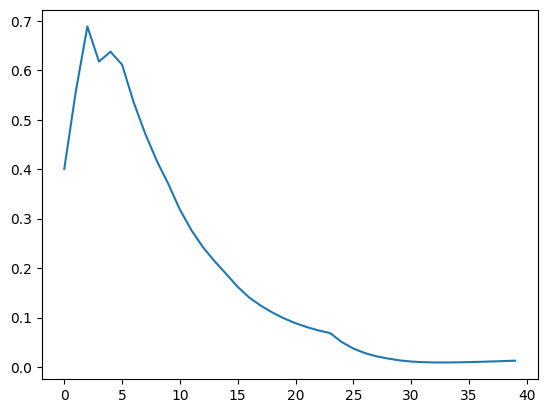

In [109]:
import matplotlib.pyplot as plt
plt.plot(overlaps_exact)

In [12]:
psi_coeff_after_training=psi_coeff_model(model_rand, GT_batch3x3)
psi_coeff_after_training_quimb=state_from_config_amplitudes(full_basis_configs3x3, np.array(psi_coeff_after_training))
overlap_after=psi_coeff_after_training_quimb.H@phi_terms_quimb*phi_terms_quimb.H@psi_coeff_after_training_quimb/(phi_terms_quimb.H@phi_terms_quimb *psi_coeff_after_training_quimb.H@psi_coeff_after_training_quimb)
overlap_before=psi_coeff_3x3_quimb.H@phi_terms_quimb*phi_terms_quimb.H@psi_coeff_3x3_quimb/(phi_terms_quimb.H@phi_terms_quimb *psi_coeff_3x3_quimb.H@psi_coeff_3x3_quimb)

energy_after_training=psi_coeff_after_training_quimb.H@Hamiltonian3x3@psi_coeff_after_training_quimb/(psi_coeff_after_training_quimb.H@psi_coeff_after_training_quimb)


energy_before_training=psi_coeff_3x3_quimb.H@Hamiltonian3x3@psi_coeff_3x3_quimb/(psi_coeff_3x3_quimb.H@psi_coeff_3x3_quimb)
energy_target=phi_terms_quimb.H@Hamiltonian3x3@phi_terms_quimb/(phi_terms_quimb.H@phi_terms_quimb)
energy_after_training, energy_before_training, energy_target, overlap_after, overlap_before

([[4.425597+0.j]],
 [[4.496084-4.937495e-16j]],
 [[4.253404+3.600992e-16j]],
 [[0.981881+0.j]],
 [[0.948204+1.000918e-16j]])

In [ ]:
@tf.function()
def improved_stochastic_gradients(phi_terms, GT_Batch_update, model):
    """
    Improved stochastic gradient implementation with better numerical stability
    and more direct calculation of the gradient of the log overlap.
    
    Args:
        phi_terms: Target state coefficients (time evolved or ground state)
        GT_Batch_update: Graph tuple batch for all configurations
        model: The variational neural network model
        
    Returns:
        loss: The loss value (negative log overlap)
        gradients: Gradients for the model parameters
    """
    with tf.GradientTape() as tape:
        # Get the neural network output
        psi = model(GT_Batch_update)
        
        # Convert output to complex coefficients
        psi_coeff = tf.complex(
            real=psi[:, 0] * tf.cos(psi[:, 1]),
            imag=psi[:, 0] * tf.sin(psi[:, 1])
        )
        
        # Normalize both wavefunctions
        psi_norm = tf.norm(psi_coeff) + 1e-12
        phi_norm = tf.norm(phi_terms) + 1e-12
        
        psi_normalized = psi_coeff / psi_norm
        phi_normalized = phi_terms / phi_norm
        # Compute overlap directly
        overlap = tf.abs(tf.reduce_sum(tf.math.conj(psi_normalized) * phi_normalized))**2
        
        # Loss is negative log of the overlap (we want to maximize overlap)
        loss = -tf.math.log(overlap + 1e-12)
        
        # Add a small L2 regularization to prevent parameter explosion
        l2_reg = 1e-5 * sum(tf.reduce_sum(tf.square(w)) for w in model.trainable_variables)
        regularized_loss = loss + l2_reg
        
    # Calculate gradients
    gradients_before = tape.gradient(regularized_loss, model.trainable_variables)
    
    # Clip gradients to prevent explosions
    gradients, grad_norm = tf.clip_by_global_norm(gradients_before, 1.0)
    tf.print("psi_norm:", psi_norm, "phi_norm:", phi_norm, "psi_normalized:", tf.norm(psi_normalized), "phi_normalized:", tf.norm(phi_normalized)) 

    # Log diagnostics
    tf.print("Overlap:", overlap, "Loss:", loss, "Gradient norm:", grad_norm)
    
    return loss, gradients


@tf.function()
def alternative_stochastic_gradients(phi_terms, GT_Batch_update, model):
    """
    Alternative implementation that uses a more direct approach to compute
    the gradient of the log overlap, without explicit rescaling.
    
    This approach often works better when dealing with very different magnitude
    wavefunctions.
    """
    with tf.GradientTape() as tape:
        # Get NN output
        psi = model(GT_Batch_update)
        
        # Convert to complex coefficients
        psi_coeff = tf.complex(
            real=psi[:, 0] * tf.cos(psi[:, 1]),
            imag=psi[:, 0] * tf.sin(psi[:, 1])
        )
        
        # Normalize both states
        psi_normalized = psi_coeff / (tf.norm(psi_coeff) + 1e-12)
        phi_normalized = phi_terms / (tf.norm(phi_terms) + 1e-12)
        
        # Compute the inner product <φ|ψ>
        inner_product = tf.reduce_sum(tf.math.conj(phi_normalized) * psi_normalized)
        
        # Use the logarithm of the absolute square as loss
        loss = -tf.math.log(tf.abs(inner_product)**2 + 1e-12)
        
    # Calculate gradients
    gradients = tape.gradient(loss, model.trainable_variables)
    
    # Apply gradient clipping
    gradients, grad_norm = tf.clip_by_global_norm(gradients, 1.0)
    
    return loss, [tf.identity(g) if g is not None else None for g in gradients]


def run_training_with_improved_gradients(
    model, GT_batch, phi_terms, optimizer, 
    edge_pairs, template_graphs_output, 
    iterations=700, J2=0.0, 
    exact_hamiltonian=None, 
    exact_eigenstate=None,
    full_basis_configs=None
):
    """
    Run training with the improved gradient calculation.
    
    Args:
        model: The variational model
        GT_batch: Graph tuple batch for all configurations
        phi_terms: Target state coefficients
        optimizer: TensorFlow optimizer
        edge_pairs: Edge pairs tensor
        template_graphs_output: Template graphs
        iterations: Number of training iterations
        J2: Next-nearest neighbor coupling
        exact_hamiltonian: Optional exact Hamiltonian for validation
        exact_eigenstate: Optional exact eigenstate for validation
        full_basis_configs: Full basis configuration for validation
        
    Returns:
        energies: List of energies during training
        overlaps: List of overlaps during training
    """
    energies = []
    overlaps = []
    
    # Precompute phi normalization
    phi_normalized = phi_terms / tf.norm(phi_terms)
    
    for i in range(iterations):
        # Compute current energy
        # energy = compute_exact_energy(model, GT_batch, edge_pairs, template_graphs_output, J2)
        # energies.append(float(energy))
        
        # Get current state coefficients
        psi_terms = psi_coeff_model(model, GT_batch)
        psi_normalized = psi_terms / tf.norm(psi_terms)
        
        # Compute overlap with target state
        overlap = tf.abs(tf.reduce_sum(tf.math.conj(psi_normalized) * phi_normalized))**2
        overlaps.append(float(overlap))
        
        # Optional validation with exact calculations if provided
        if exact_hamiltonian is not None and full_basis_configs is not None:
            psi_quimb = state_from_config_amplitudes(full_basis_configs, np.array(psi_normalized))
            if exact_hamiltonian is not None:
                energy_quimb = (psi_quimb.H @ exact_hamiltonian @ psi_quimb) / (psi_quimb.H @ psi_quimb)
                # target_energy=phi_terms.H@exact_hamiltonian@phi_terms/(phi_terms.H@phi_terms)
                print(f"Exact energy: {energy_quimb}, Target energy: ")
                # print(f"Energy: TF={energy.numpy():.6f}, Exact={energy_quimb}, norm={psi_quimb.H @ psi_quimb}")
            
            if exact_eigenstate is not None:
                exact_overlap = np.abs((psi_quimb.H @ exact_eigenstate))**2
                print(f"Exact overlap: {exact_overlap}")
        
        # Compute and apply gradients
        # Choose one of the gradient methods:
        loss, gradients = improved_stochastic_gradients(phi_terms, GT_batch, model)
        # loss, gradients = alternative_stochastic_gradients(phi_terms, GT_batch, model)
        
        optimizer.apply(gradients, model.trainable_variables)
        
        # Print progress every 10 iterations
        # if i % 10 == 0:
        #     print(f"Iteration {i}: Energy = {energy.numpy():.6f}, Overlap = {overlap.numpy():.6f}")
    
    return  overlaps


# Helper function to get complex coefficients from model

def psi_coeff_model(model, graph_tuples):
    """
    Extract complex coefficients from model output
    
    Args:
        model: Neural network model
        graph_tuples: Graph tuple batch
        
    Returns:
        Complex coefficients for all configurations
    """
    outputs = model(graph_tuples)
    amplitudes = outputs[:, 0]
    phases = outputs[:, 1]
    
    return tf.complex(
        real=amplitudes * tf.cos(phases),
        imag=amplitudes * tf.sin(phases)
    )

In [27]:
psi_coeffs=psi_coeff_model(model_rand, GT_batch3x3)
psi_norm=psi_coeffs/tf.norm(psi_coeffs)
phi_terms_te_norm=phi_terms_te/tf.norm(phi_terms_te)
tf.norm(psi_coeffs), tf.norm(phi_terms_tf), tf.norm(psi_norm), tf.norm(phi_terms_te_norm)

(<tf.Tensor: shape=(), dtype=complex64, numpy=(756.1545-1.9197287e-07j)>,
 <tf.Tensor: shape=(), dtype=complex64, numpy=(71.0729-2.0687317e-08j)>,
 <tf.Tensor: shape=(), dtype=complex64, numpy=(1+1.6872835e-10j)>,
 <tf.Tensor: shape=(), dtype=complex64, numpy=(0.99999994+7.608195e-11j)>)

In [30]:
# Initialize your model and optimizer as before
model_rand = initialize_NQS_model_fromhyperparams(hyperparams3x3.ansatz, hyperparams3x3.ansatz_params)
optimizer = snt.optimizers.Adam(learning_rate=hyperparams3x3.sim_params.learning_rate)

# Run training with the improved gradient implementation
overlaps = run_training_with_improved_gradients(
    model=model_rand,
    GT_batch=GT_batch3x3,
    phi_terms=phi_terms_te,
    optimizer=optimizer,
    edge_pairs=edge_pairs3x3,
    template_graphs_output=template_graphs_output3x3,
    iterations=400,
    exact_hamiltonian=Hamiltonian3x3,  # Optional
    exact_eigenstate=None,  # Optional
    full_basis_configs=full_basis_configs3x3  # Optional
)

Exact energy: [[4.496084+0.j]], Target energy: 
psi_norm: ? phi_norm: ? psi_normalized: ? phi_normalized: ?
Overlap: 0.94820416 Loss: 0.0531854406 Gradient norm: 0.470768332


W0000 00:00:1743442530.373631  177487 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Exact energy: [[4.495805-8.881784e-16j]], Target energy: 
psi_norm: ? phi_norm: ? psi_normalized: ? phi_normalized: ?
Overlap: 0.948715091 Loss: 0.052646745 Gradient norm: 0.45063889
Exact energy: [[4.495525-4.440892e-16j]], Target energy: 
psi_norm: ? phi_norm: ? psi_normalized: ? phi_normalized: ?
Overlap: 0.949202359 Loss: 0.0521332696 Gradient norm: 0.454017699
Exact energy: [[4.495231+0.j]], Target energy: 
psi_norm: ? phi_norm: ? psi_normalized: ? phi_normalized: ?
Overlap: 0.949688137 Loss: 0.0516216271 Gradient norm: 0.451685727
Exact energy: [[4.494932+4.440892e-16j]], Target energy: 
psi_norm: ? phi_norm: ? psi_normalized: ? phi_normalized: ?
Overlap: 0.950158536 Loss: 0.0511264279 Gradient norm: 0.445067555
Exact energy: [[4.49463+4.440892e-16j]], Target energy: 
psi_norm: ? phi_norm: ? psi_normalized: ? phi_normalized: ?
Overlap: 0.95061332 Loss: 0.0506479032 Gradient norm: 0.437767684
Exact energy: [[4.49432+8.881784e-16j]], Target energy: 
psi_norm: ? phi_norm: ? psi_norm

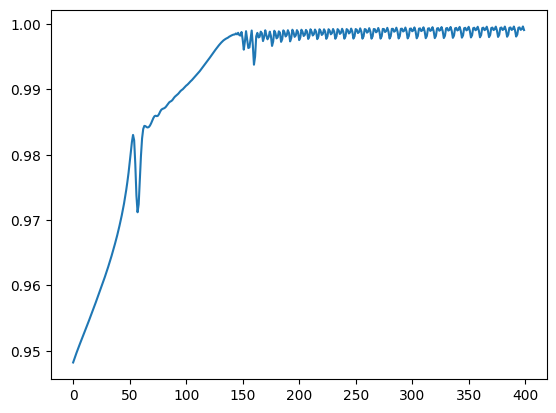

In [31]:
import matplotlib.pyplot as plt
plt.plot(overlaps)

In [189]:
def debug_gradient_direction(phi_terms, GT_Batch_update, model, optimizer):
    """Test if gradients improve overlap without model cloning"""
    # Get current overlap
    psi = model(GT_Batch_update)
    psi_coeff = tf.complex(
        real=psi[:, 0] * tf.cos(psi[:, 1]),
        imag=psi[:, 0] * tf.sin(psi[:, 1])
    )
    
    psi_normalized = psi_coeff / (tf.norm(psi_coeff) + 1e-12)
    phi_normalized = phi_terms / (tf.norm(phi_terms) + 1e-12)
    
    # Current overlap
    initial_overlap = tf.abs(tf.reduce_sum(tf.math.conj(psi_normalized) * phi_normalized))**2
    print(f"Initial overlap: {initial_overlap.numpy():.6f}")
    
    # Save original weights
    original_weights = [v.numpy() for v in model.trainable_variables]
    
    # Try direct overlap optimization
    with tf.GradientTape() as tape:
        psi = model(GT_Batch_update)
        psi_coeff = tf.complex(
            real=psi[:, 0] * tf.cos(psi[:, 1]),
            imag=psi[:, 0] * tf.sin(psi[:, 1])
        )
        
        psi_norm = tf.norm(psi_coeff) + 1e-12
        psi_normalized = psi_coeff / psi_norm
        
        # Direct overlap (what we want to maximize)
        overlap = tf.abs(tf.reduce_sum(tf.math.conj(psi_normalized) * phi_normalized))**2
        loss = -overlap  # Negative for maximization
        
    # Get gradients
    gradients = tape.gradient(loss, model.trainable_variables)
    
    # Store original learning rate
    original_lr = optimizer.learning_rate
    
    # Set tiny learning rate for test
    optimizer.learning_rate = 1e-7
    
    # Apply the gradients
    optimizer.apply(gradients, model.trainable_variables)
    
    # Check if overlap improved
    psi_after = model(GT_Batch_update)
    psi_coeff_after = tf.complex(
        real=psi_after[:, 0] * tf.cos(psi_after[:, 1]),
        imag=psi_after[:, 0] * tf.sin(psi_after[:, 1])
    )
    
    psi_normalized_after = psi_coeff_after / (tf.norm(psi_coeff_after) + 1e-12)
    overlap_after = tf.abs(tf.reduce_sum(tf.math.conj(psi_normalized_after) * phi_normalized))**2
    
    print(f"Direct overlap optimization: {initial_overlap.numpy():.8f} -> {overlap_after.numpy():.8f}")
    
    # Check if overlap improved
    direct_improved = overlap_after > initial_overlap
    
    # Restore original weights
    for i, var in enumerate(model.trainable_variables):
        var.assign(original_weights[i])
    
    # Restore original learning rate
    optimizer.learning_rate = original_lr
    
    # Try log-based overlap optimization
    with tf.GradientTape() as tape:
        psi = model(GT_Batch_update)
        psi_coeff = tf.complex(
            real=psi[:, 0] * tf.cos(psi[:, 1]),
            imag=psi[:, 0] * tf.sin(psi[:, 1])
        )
        
        psi_norm = tf.norm(psi_coeff) + 1e-12
        psi_normalized = psi_coeff / psi_norm
        
        # Log-based loss
        overlap = tf.abs(tf.reduce_sum(tf.math.conj(psi_normalized) * phi_normalized))**2
        loss = -tf.math.log(overlap + 1e-12)
        
    # Get gradients
    gradients = tape.gradient(loss, model.trainable_variables)
    
    # Set tiny learning rate for test
    optimizer.learning_rate = 1e-7
    
    # Apply the gradients
    optimizer.apply(gradients, model.trainable_variables)
    
    # Check if overlap improved
    psi_after = model(GT_Batch_update)
    psi_coeff_after = tf.complex(
        real=psi_after[:, 0] * tf.cos(psi_after[:, 1]),
        imag=psi_after[:, 0] * tf.sin(psi_after[:, 1])
    )
    
    psi_normalized_after = psi_coeff_after / (tf.norm(psi_coeff_after) + 1e-12)
    overlap_after = tf.abs(tf.reduce_sum(tf.math.conj(psi_normalized_after) * phi_normalized))**2
    
    print(f"Log-based optimization: {initial_overlap.numpy():.8f} -> {overlap_after.numpy():.8f}")
    
    # Check if overlap improved
    log_improved = overlap_after > initial_overlap
    
    # Restore original weights again
    for i, var in enumerate(model.trainable_variables):
        var.assign(original_weights[i])
        
    # Restore original learning rate
    optimizer.learning_rate = original_lr
    
    return {
        "direct_improved": direct_improved,
        "log_improved": log_improved,
        "recommendation": "direct" if direct_improved and not log_improved else 
                          "log" if log_improved and not direct_improved else
                          "both" if direct_improved and log_improved else "none"
    }


def micro_step_training(
    model, GT_batch, phi_terms, optimizer, 
    edge_pairs, template_graphs_output, 
    iterations=1000, use_log=False, 
    micro_lr=1e-7, J2=0.0,
    log_every=10
):
    """
    Run training with micro steps for stable optimization
    Works with Sonnet modules
    
    Args:
        model: Sonnet model
        GT_batch: Graph tuple batch
        phi_terms: Target state coefficients
        optimizer: Optimizer (will temporarily modify learning rate)
        edge_pairs: Edge pairs tensor
        template_graphs_output: Template graphs
        iterations: Number of iterations
        use_log: Whether to use log-based loss
        micro_lr: Micro learning rate for stable training
        J2: Next-nearest neighbor coupling
        log_every: How often to log progress
        
    Returns:
        energies, overlaps, losses
    """
    energies = []
    overlaps = []
    losses = []
    
    # Store original learning rate
    original_lr = optimizer.learning_rate
    
    # Set micro learning rate
    optimizer.learning_rate = micro_lr
    
    # Normalize target state once
    phi_normalized = phi_terms / tf.norm(phi_terms)
    
    for i in range(iterations):
        # Get current metrics
        energy = compute_exact_energy(model, GT_batch, edge_pairs, template_graphs_output, J2)
        psi = model(GT_batch)
        psi_coeff = tf.complex(
            real=psi[:, 0] * tf.cos(psi[:, 1]),
            imag=psi[:, 0] * tf.sin(psi[:, 1])
        )
        psi_normalized = psi_coeff / (tf.norm(psi_coeff) + 1e-12)
        current_overlap = tf.abs(tf.reduce_sum(tf.math.conj(psi_normalized) * phi_normalized))**2
        
        # Store metrics
        energies.append(float(energy))
        overlaps.append(float(current_overlap))
        
        # Compute gradients
        with tf.GradientTape() as tape:
            psi = model(GT_batch)
            psi_coeff = tf.complex(
                real=psi[:, 0] * tf.cos(psi[:, 1]),
                imag=psi[:, 0] * tf.sin(psi[:, 1])
            )
            
            psi_norm = tf.norm(psi_coeff) + 1e-12
            psi_normalized = psi_coeff / psi_norm
            
            overlap = tf.abs(tf.reduce_sum(tf.math.conj(psi_normalized) * phi_normalized))**2
            
            if use_log:
                loss = -tf.math.log(overlap + 1e-12)
            else:
                loss = -overlap
                
            # Optional regularization
            l2_reg = 1e-8 * sum(tf.reduce_sum(tf.square(w)) for w in model.trainable_variables)
            regularized_loss = loss + l2_reg
        
        # Get and apply gradients
        gradients = tape.gradient(regularized_loss, model.trainable_variables)
        
        # Clip gradients to prevent explosions
        gradients, grad_norm = tf.clip_by_global_norm(gradients, 0.01)
        
        # Apply gradients
        optimizer.apply(gradients, model.trainable_variables)
        
        # Store loss
        losses.append(float(regularized_loss))
        
        # Log progress
        if i % log_every == 0:
            print(f"Iter {i}: Overlap = {float(current_overlap):.8f}, Energy = {float(energy):.6f}, Grad Norm = {float(grad_norm):.8f}")
            
            # Check if optimization is improving - if not, reduce learning rate
            if i > 0 and overlaps[-1] <= overlaps[-2]:
                new_lr = optimizer.learning_rate * 0.9
                print(f"  Reducing LR: {optimizer.learning_rate.numpy():.10f} -> {new_lr:.10f}")
                optimizer.learning_rate = new_lr
    
    # Restore original learning rate
    optimizer.learning_rate = original_lr
    
    return energies, overlaps, losses

In [ ]:
# Test which gradient approach works best
gradient_test = debug_gradient_direction(
    phi_terms=phi_terms_te,
    GT_Batch_update=GT_batch3x3,
    model=model_rand,
    optimizer=optimizer
)
print(f"Gradient test results: {gradient_test}")

# # Run extremely slow training to ensure stability
# energies, overlaps, losses = micro_step_training(
#     model=model_rand,
#     GT_batch=GT_batch3x3,
#     phi_terms=phi_term_tf,
#     edge_pairs=edge_pairs3x3,
#     template_graphs_output=template_graphs_output3x3,
#     iterations=100)

Initial overlap: 134744.546875
Direct overlap optimization: 134744.54687500 -> 134759.07812500
Log-based optimization: 134744.54687500 -> 134757.81250000
Gradient test results: {'direct_improved': <tf.Tensor: shape=(), dtype=bool, numpy=True>, 'log_improved': <tf.Tensor: shape=(), dtype=bool, numpy=True>, 'recommendation': 'both'}


TypeError: micro_step_training() missing 1 required positional argument: 'optimizer'

In [ ]:
tf.norm(psi_terms)
psi_quimb= state_from_config_amplitudes(full_basis_configs3x3,np.array(psi_norm))
psi_quimbv2=state_from_config_amplitudes(full_basis_configs3x3, np.array(psi_terms))
normv2=(psi_quimbv2.H@psi_quimbv2)
normv1=(psi_quimb.H@psi_quimb)
psi_quimbv2.H@Hamiltonian3x3@psi_quimbv2/normv2 , psi_quimb.H@Hamiltonian3x3@psi_quimb/normv1


/tmp/ipykernel_1744922/844294537.py:6: RuntimeWarning: invalid value encountered in divide
  psi_quimbv2.H@Hamiltonian3x3@psi_quimbv2/normv2 , psi_quimb.H@Hamiltonian3x3@psi_quimb/normv1


([[nan+nanj]], [[nan+nanj]])

In [130]:
lowest_eigenstate3x3=qu.groundstate(Hamiltonian3x3)
lowest_eigenstate3x3_tf=tf.convert_to_tensor(lowest_eigenstate3x3)

quimb_lowest= state_from_config_amplitudes(full_basis_configs3x3, np.array(lowest_eigenstate3x3_tf))
quimb_lowest.H@Hamiltonian3x3@quimb_lowest, (quimb_lowest.H@quimb_lowest), lowest_eigenstate3x3.H@Hamiltonian3x3@lowest_eigenstate3x3, (lowest_eigenstate3x3.H@lowest_eigenstate3x3)

([[-3.969002+0.j]], [[1.+0.j]], [[-3.969002]], [[1.]])

## State


In [32]:
import quimb as qu

In [33]:
Hamiltonian3x3= qu.ham_heis_2D(3,3, j=1.0, bz=0, cyclic=True, parallel=False, ownership=None)

In [34]:
qu.groundstate(Hamiltonian3x3)

[[-2.154890e-17]
 [ 2.897971e-19]
 [ 7.415502e-18]
 [ 5.250431e-18]
 [ 1.119867e-17]
 [ 6.013460e-18]
 [-1.230690e-17]
 [-7.926001e-19]
 [-2.306887e-17]
 [-4.228732e-18]
 [ 4.614421e-18]
 [-2.725620e-17]
 [ 2.385879e-17]
 [ 2.225452e-17]
 [-4.073254e-17]
 [ 4.553950e-02]
 [-7.207347e-18]
 [-7.519627e-18]
 [-5.261062e-19]
 [-7.425785e-18]
 [-1.870809e-18]
 [ 1.144930e-17]
 [ 2.164046e-17]
 [-2.939513e-02]
 [ 1.552565e-17]
 [ 1.346311e-17]
 [ 1.450909e-17]
 [-5.422752e-03]
 [-2.296857e-17]
 [ 9.829790e-03]
 [-3.986838e-03]
 [-2.180809e-02]
 [ 1.007772e-17]
 [ 5.511815e-18]
 [ 1.926333e-17]
 [ 9.670500e-17]
 [ 1.165574e-17]
 [-1.520760e-17]
 [ 7.508336e-18]
 [-1.614437e-02]
 [ 5.851486e-18]
 [ 1.071479e-17]
 [-5.391835e-17]
 [-8.631483e-03]
 [ 1.393562e-17]
 [ 5.154615e-03]
 [-3.685261e-02]
 [-2.300812e-03]
 [ 7.738567e-18]
 [-9.153086e-17]
 [ 3.048197e-17]
 [ 2.702282e-02]
 [ 8.407545e-18]
 [ 1.261832e-02]
 [ 2.681375e-04]
 [ 2.410890e-02]
 [ 1.671410e-17]
 [-4.463816e-02]
 [ 4.672220e-0

Total states in Hilbert space: 512
States with probability < 0.0005: 356
Percentage below threshold: 69.53%
States needed for 50% probability: 19
States needed for 90% probability: 81
States needed for 99% probability: 172


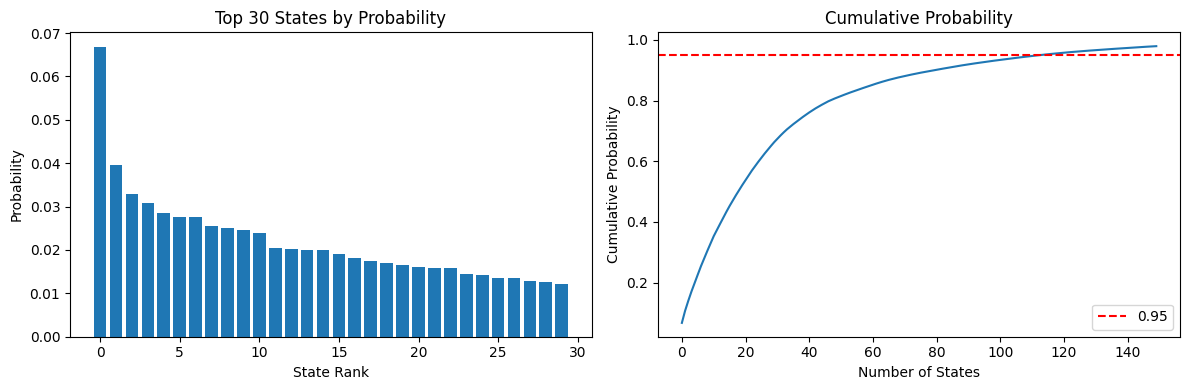

In [17]:
import quimb as qu
import numpy as np
import matplotlib.pyplot as plt

# Define the Hamiltonian and compute ground state
Hamiltonian3x3 = qu.ham_heis_2D(3, 3, j=1.0, bz=0, cyclic=True)
gs = qu.groundstate(Hamiltonian3x3)

# Get the probabilities (squared amplitudes)
probabilities = np.abs(gs.flatten())**2

# Analyze with user-defined threshold
threshold = 5e-4 # Can be modified as needed

# Count states below threshold
counter_less_threshold = 0
for i in range(len(probabilities)):
    if probabilities[i] < threshold:
        counter_less_threshold += 1

print(f"Total states in Hilbert space: {len(probabilities)}")
print(f"States with probability < {threshold}: {counter_less_threshold}")
print(f"Percentage below threshold: {counter_less_threshold/len(probabilities)*100:.2f}%")

# Sort probabilities for analysis
sorted_indices = np.argsort(probabilities)[::-1]
sorted_probs = probabilities[sorted_indices]
cumulative = np.cumsum(sorted_probs)

# Find how many states make up certain percentages
states_50 = np.argmax(cumulative >= 0.5) + 1
states_90 = np.argmax(cumulative >= 0.9) + 1
states_99 = np.argmax(cumulative >= 0.99) + 1

print(f"States needed for 50% probability: {states_50}")
print(f"States needed for 90% probability: {states_90}")
print(f"States needed for 99% probability: {states_99}")

# Basic visualization
plt.figure(figsize=(12, 4))

# Plot top states
plt.subplot(1, 2, 1)
plt.bar(range(min(30, len(sorted_probs))), sorted_probs[:30])
plt.xlabel('State Rank')
plt.ylabel('Probability')
plt.title('Top 30 States by Probability')
y_perc=0.95
end_cum=150
# Plot cumulative probability
plt.subplot(1, 2, 2)
plt.plot(range(min(end_cum, len(cumulative))), cumulative[:end_cum])
plt.axhline(y=y_perc, color='r', linestyle='--', label=f'{y_perc}')
plt.xlabel('Number of States')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Probability')
plt.legend()

plt.tight_layout()
plt.show()

Total states in Hilbert space: 65536
States with probability < 5e-06: 55410
Percentage below threshold: 84.55%
States needed for 50% probability: 280
States needed for 90% probability: 4352
States needed for 99% probability: 9678


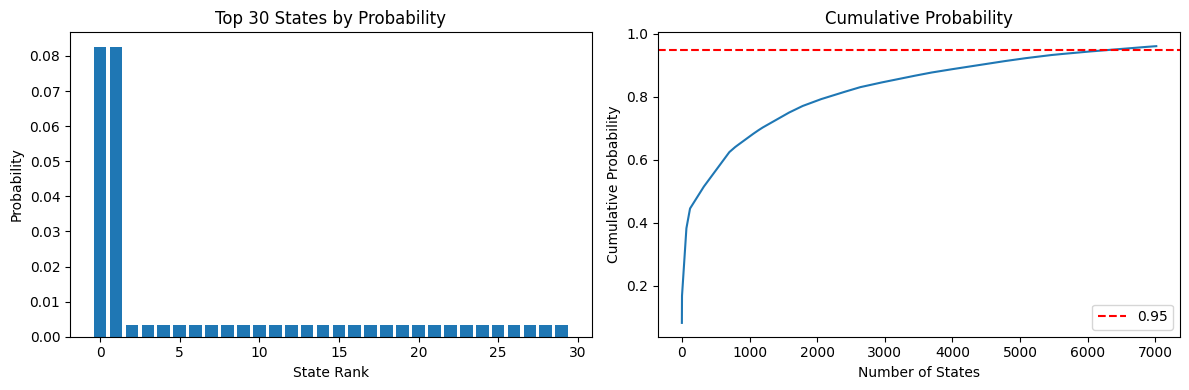

In [28]:
import quimb as qu
import numpy as np
from math import ceil
import matplotlib.pyplot as plt

# Define the Hamiltonian and compute ground state
Hamiltonian4x4 = qu.ham_heis_2D(4, 4, j=1.0, bz=0, cyclic=True)
gs = qu.groundstate(Hamiltonian4x4)

# Get the probabilities (squared amplitudes)
probabilities = np.abs(gs.flatten())**2

# Analyze with user-defined threshold
threshold = 5e-6 # Can be modified as needed

# Count states below threshold
counter_less_threshold = 0
for i in range(len(probabilities)):
    if probabilities[i] < threshold:
        counter_less_threshold += 1

print(f"Total states in Hilbert space: {len(probabilities)}")
print(f"States with probability < {threshold}: {counter_less_threshold}")
print(f"Percentage below threshold: {counter_less_threshold/len(probabilities)*100:.2f}%")

# Sort probabilities for analysis
sorted_indices = np.argsort(probabilities)[::-1]
sorted_probs = probabilities[sorted_indices]
cumulative = np.cumsum(sorted_probs)

# Find how many states make up certain percentages
states_50 = np.argmax(cumulative >= 0.5) + 1
states_90 = np.argmax(cumulative >= 0.9) + 1
states_99 = np.argmax(cumulative >= 0.99) + 1

print(f"States needed for 50% probability: {states_50}")
print(f"States needed for 90% probability: {states_90}")
print(f"States needed for 99% probability: {states_99}")

# Basic visualization
plt.figure(figsize=(12, 4))

# Plot top states
plt.subplot(1, 2, 1)
plt.bar(range(min(30, len(sorted_probs))), sorted_probs[:30])
plt.xlabel('State Rank')
plt.ylabel('Probability')
plt.title('Top 30 States by Probability')
y_perc=0.95
# Import math for the ceil function
end_cum = ceil((states_99 + states_90) / 2)
# Plot cumulative probability
plt.subplot(1, 2, 2)
plt.plot(range(min(end_cum, len(cumulative))), cumulative[:end_cum])
plt.axhline(y=y_perc, color='r', linestyle='--', label=f'{y_perc}')
plt.xlabel('Number of States')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Probability')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
Hamiltonian4x4 = qu.ham_heis_2D(4, 4, j=-1.0, bz=0, cyclic=True)
gs=qu.groundstate(Hamiltonian4x4)
qu.groundenergy(Hamiltonian4x4)


AttributeError: module 'quimb' has no attribute 'ground_state'

In [37]:
Hamiltonian4x4 = qu.ham_heis_2D(4, 4, j=1.0, bz=0, cyclic=True)

gs.H@-Hamiltonian4x4@gs

[[11.228483]]

# Analyzing Magnetic properties of Heisenberg groundstates

In [121]:
import quimb as qu
import numpy as np

n, m= 3,3
Hamiltonian = qu.ham_heis_2D(n, m, j=1.0, bz=0, cyclic=True)
gs_array=np.array(qu.groundstate(Hamiltonian))
# Number of sites
n_sites = n * m
total_states = 2**n_sites

# Function to apply Marshall sign rule to basis states
def marshall_sign(basis_idx, n, m):
    # Convert to binary representation (spin configuration)
    bin_str = format(basis_idx, f'0{n*m}b')
    spins = np.array([1 if bit == '0' else -1 for bit in bin_str])
    
    # Compute Marshall sign: (-1)^number of down spins on sublattice A
    # For 2D checkerboard, sites where (i+j) is even belong to sublattice A
    sign = 1
    for site in range(n*m):
        i, j = site // m, site % m
        if (i + j) % 2 == 0 and spins[site] == -1:
            sign *= -1
    
    return sign

# Apply Marshall sign transformation to each coefficient
transformed_gs = np.zeros_like(gs_array, dtype=complex)
for i in range(len(gs_array)):
    if abs(gs_array[i]) > 1e-10:  # Only consider non-zero coefficients
        transformed_gs[i] = gs_array[i] * marshall_sign(i, n, m)

# Check if all non-zero coefficients have the same sign after transformation
non_zero_idxs = np.where(abs(transformed_gs) > 1e-6)[0]
signs = np.sign(transformed_gs[non_zero_idxs].real)
marshall_rule_holds = np.all(signs == signs[0]) if len(signs) > 0 else False

print(f"Marshall sign rule holds: {marshall_rule_holds}")
if not marshall_rule_holds:
    pos = np.sum(signs > 0)
    neg = np.sum(signs < 0)
    print(f"Positive coefficients: {pos}, Negative coefficients: {neg}")

Marshall sign rule holds: False
Positive coefficients: 120, Negative coefficients: 132


In [47]:
non_zero_idxs

array([ 15,  23,  27,  29,  30,  31,  39,  43,  45,  46,  47,  51,  53,
        54,  55,  57,  58,  59,  60,  61,  62,  71,  75,  77,  78,  79,
        83,  85,  86,  87,  89,  90,  91,  92,  93,  94,  99, 101, 102,
       103, 105, 106, 107, 108, 109, 110, 113, 114, 115, 116, 117, 118,
       120, 121, 122, 124, 135, 139, 141, 142, 143, 147, 149, 150, 151,
       153, 154, 155, 156, 157, 158, 163, 165, 166, 167, 169, 170, 171,
       172, 173, 174, 177, 178, 179, 180, 181, 182, 184, 185, 186, 188,
       195, 197, 198, 199, 201, 202, 203, 204, 205, 206, 209, 210, 211,
       212, 213, 214, 216, 217, 218, 220, 225, 226, 227, 228, 229, 230,
       232, 233, 234, 236, 240, 241, 242, 244, 248, 263, 267, 269, 270,
       271, 275, 277, 278, 279, 281, 282, 283, 284, 285, 286, 291, 293,
       294, 295, 297, 298, 299, 300, 301, 302, 305, 306, 307, 308, 309,
       310, 312, 313, 314, 316, 323, 325, 326, 327, 329, 330, 331, 332,
       333, 334, 337, 338, 339, 340, 341, 342, 344, 345, 346, 34

In [8]:
import quimb as qu
n, m= 3,3
Hamiltonian3x3 = qu.ham_heis_2D(n, m, j=1.0, bz=0, cyclic=True)
gs=qu.groundstate(Hamiltonian3x3)
qu.groundenergy(Hamiltonian3x3)


-3.969001749928511

In [9]:
import quimb as qu
n, m= 4,4
bz_val=0

Hamiltonian3x3 = qu.ham_heis_2D(n, m, j=1.0, bz=bz_val, cyclic=True)
ge=qu.groundenergy(Hamiltonian3x3)
gs=qu.groundstate(Hamiltonian3x3)


In [215]:
from compgraph.quimb_helpers.operators import calculate_site_magnetizations_square, construct_total_Sz_square
Sz_tot=construct_total_Sz_square(n, m)
calculate_site_magnetizations_square(gs, n, m), qu.expec(Sz_tot, gs), gs.H@Sz_tot@gs, gs.H@gs,ge

((array([[ 1.06598758e-15, -9.87925020e-16,  1.09721260e-15,
          -1.11369247e-15],
         [-9.92370248e-16,  9.86840817e-16, -1.07021596e-15,
           1.00787434e-15],
         [ 9.58163670e-16, -9.06840250e-16,  9.68734641e-16,
          -1.04759680e-15],
         [-9.30679145e-16,  1.06132551e-15, -1.11130723e-15,
           1.09764628e-15]]),
  8.315830662963819e-17),
 -1.4253718458101605e-29,
 [[-1.425372e-29+0.j]],
 [[1.]],
 -11.228483208428845)

In [216]:
S_z_tot= construct_total_Sz_square(n, m)
print(f"commutator of S_z_tot and Hamiltonian: {qu.norm(Hamiltonian3x3 @ S_z_tot - S_z_tot @ Hamiltonian3x3)}")


commutator of S_z_tot and Hamiltonian: 0.0


In [10]:
import quimb as qu
n, m= 4,4
bz_val=0

Hamiltonian3x3 = qu.ham_heis_2D(n, m, j=1.0, bz=bz_val, cyclic=True)
gs=qu.groundstate(Hamiltonian3x3)
ge=qu.groundenergy(Hamiltonian3x3)
S_z_tot= construct_total_Sz_square(n, m)
# print(f"commutator of S_z_tot and Hamiltonian: {qu.norm(Hamiltonian3x3 @ S_z_tot - S_z_tot @ Hamiltonian3x3)}")
calculate_site_magnetizations_square(gs, n, m), qu.expec(S_z_tot, gs), gs.H@S_z_tot@gs, gs.H@gs,ge

((array([[-3.19731221e-15,  3.00605894e-15, -3.26670115e-15,
           3.47096483e-15],
         [ 3.22441726e-15, -2.93011058e-15,  2.89839767e-15,
          -3.34216162e-15],
         [-3.08986777e-15,  2.86120953e-15, -3.13600057e-15,
           3.33965440e-15],
         [ 3.42347678e-15, -3.00833577e-15,  3.02188830e-15,
          -3.24913707e-15]]),
  2.644098048149024e-17),
 -2.783886451995098e-29,
 [[-2.783886e-29+0.j]],
 [[1.]],
 -11.228483208428846)

In [ ]:
import quimb as qu
n, m= 4,4
bz_val=0

Hamiltonian3x3 = qu.ham_heis_2D(n, m, j=1.0, bz=bz_val, cyclic=True)
gs=qu.groundstate(Hamiltonian3x3)
ge=qu.groundenergy(Hamiltonian3x3)
S_z_tot= construct_total_Sz_square(n, m)
print(f"commutator of S_z_tot and Hamiltonian: {qu.norm(Hamiltonian3x3 @ S_z_tot - S_z_tot @ Hamiltonian3x3)}")
calculate_site_magnetizations_square(gs, n, m), qu.expec(S_z_tot, gs), gs.H@S_z_tot@gs, gs.H@gs,ge



commutator of S_z_tot and Hamiltonian: 0.0


((array([[-0.08585013, -0.00272359,  0.07505722],
         [-0.01356873,  0.06457062, -0.28639678],
         [ 0.03452652, -0.02681085, -0.01198777]]),
  -0.2531834895678674),
 -0.2531834895678674,
 [[-0.253183+0.j]],
 [[1.]],
 -3.9690017499285237)

In [12]:
gs=qu.groundstate(Hamiltonian3x3)

analyze_computational_basis_decomposition(gs,n,m)

255      0000000011111111   0.000001   0.000000+0.000000j 0.000000        ✓
383      0000000101111111   0.000002   0.000000+0.000000j 0.000000        ✓
447      0000000110111111   0.000001   0.000000+0.000000j 0.000000        ✓
479      0000000111011111   0.000002   0.000000+0.000000j 0.000000        ✓
495      0000000111101111   0.000008   0.000000+0.000000j 0.000000        ✓
503      0000000111110111   0.000001   0.000000+0.000000j 0.000000        ✓
507      0000000111111011   0.000000   0.000000+0.000000j 0.000000        ✓
509      0000000111111101   0.000001   0.000000+0.000000j 0.000000        ✓
510      0000000111111110   0.000002   0.000000+0.000000j 0.000000        ✓
639      0000001001111111   0.000001   0.000000+0.000000j 0.000000        ✓
703      0000001010111111   0.000002   0.000000+0.000000j 0.000000        ✓
735      0000001011011111   0.000008   0.000000+0.000000j 0.000000        ✓
751      0000001011101111   0.000002   0.000000+0.000000j 0.000000        ✓
759      000

In [294]:
def create_uniform_state(n, m):
    """
    Creates a uniform superposition of all computational basis states
    for an n×m lattice with spin-1/2 particles
    
    Parameters:
    -----------
    n, m : int
        Dimensions of the lattice
    
    Returns:
    --------
    A quantum state representing equal superposition of all basis states
    """
    num_sites = n * m
    hilbert_dim = 2**num_sites
    
    # Create state with equal amplitude for all basis states
    uniform_amplitude = 1 / np.sqrt(hilbert_dim)
    state_vector = np.ones(hilbert_dim) * uniform_amplitude
    
    return qu.qu(state_vector)


In [297]:
psi_unif=create_uniform_state(n, m)

In [298]:
psi_unif.H@Hamiltonian3x3@psi_unif 

[[4.5+0.j]]

In [302]:
phi_unif=psi_unif -0.02*Hamiltonian3x3@psi_unif

In [330]:
n,m=4,4
Hamiltonian=qu.ham_heis_2D(n, m, j=1.0, bz=0.05, cyclic=False)
psi_unif=create_uniform_state(n, m)
verify_constant_row_sum(Hamiltonian, psi_unif)


After applying H to uniform state:
Min amplitude magnitude: 0.0218750000
Max amplitude magnitude: 0.0250000000
Standard deviation: 0.0003906250


[[0.025   +0.j]
 [0.024805+0.j]
 [0.024805+0.j]
 ...
 [0.02207 +0.j]
 [0.02207 +0.j]
 [0.021875+0.j]]

In [1]:
verify_constant_row_sum(Hamiltonian3x3, psi_unif)

NameError: name 'verify_constant_row_sum' is not defined

# Magnetic properties of J1-J2 Hamiltonian

In [2]:
from quimb.gen.operators import hamiltonian_builder, spin_operator, ikron
import itertools
import functools
import operator

@hamiltonian_builder
def ham_heis_2D_j1j2(n, m, j1=1.0, j2=0.0, bz=0.0, cyclic=False,
                     parallel=False, ownership=None):
    """Construct the 2D spin-1/2 heisenberg model hamiltonian with J1-J2 interactions:

    Parameters
    ----------
    n : int
        The number of rows.
    m : int
        The number of columns.
    j1 : float or (float, float, float), optional
        The nearest-neighbor coupling strength(s). Isotropic if scalar else if
        vector ``(Jx, Jy, Jz) = j1``.
    j2 : float or (float, float, float), optional
        The next-nearest-neighbor coupling strength(s). Isotropic if scalar else if
        vector ``(Jx, Jy, Jz) = j2``.
    bz : float, optional
        The z direction magnetic field.
    cyclic : bool, optional
        Whether to use periodic boundary conditions.
    parallel : bool, optional
        Construct the hamiltonian in parallel. Faster but might use more
        memory.
    ownership : (int, int), optional
        If given, which range of rows to generate.

    Returns
    -------
    H : operator
        The hamiltonian.
    """
    # Parse j1 interaction strengths
    try:
        j1x, j1y, j1z = j1
    except (TypeError, ValueError):
        j1x = j1y = j1z = j1

    j1s = {s: j for s, j in zip("xyz", [j1x, j1y, j1z]) if j != 0.0}
    
    # Parse j2 interaction strengths
    try:
        j2x, j2y, j2z = j2
    except (TypeError, ValueError):
        j2x = j2y = j2z = j2

    j2s = {s: j for s, j in zip("xyz", [j2x, j2y, j2z]) if j != 0.0}

    dims = [[2] * m] * n  # shape (n, m)
    sites = tuple(itertools.product(range(n), range(m)))

    # Generate nearest-neighbor (J1) pairs
    def gen_j1_pairs():
        for i, j in sites:
            above, right = (i + 1) % n, (j + 1) % m
            # Ignore wraparound coordinates if not cyclic
            if cyclic or above != 0:
                yield ((i, j), (above, j))
            if cyclic or right != 0:
                yield ((i, j), (i, right))
    
    # Generate next-nearest-neighbor (J2) diagonal pairs
    def gen_j2_pairs():
        for i, j in sites:
            above_right = (i + 1) % n, (j + 1) % m
            above_left = (i + 1) % n, (j - 1) % m
            
            # Ignore wraparound coordinates if not cyclic
            if (cyclic or (above_right[0] != 0 and above_right[1] != 0)):
                yield ((i, j), above_right)
            
            if (cyclic or (above_left[0] != 0 and above_left[1] != m - 1)):
                yield ((i, j), above_left)

    # Generate all J1 pairs of coordinates and directions
    j1_pairs_ss = tuple(itertools.product(gen_j1_pairs(), j1s))
    
    # Generate all J2 pairs of coordinates and directions
    j2_pairs_ss = tuple(itertools.product(gen_j2_pairs(), j2s)) if any(j != 0.0 for j in j2s.values()) else ()

    # Build the hamiltonian in sparse 'coo' format for efficiency
    op_kws = {'sparse': True, 'stype': 'coo'}
    ikron_kws = {'sparse': True, 'stype': 'coo',
                 'coo_build': True, 'ownership': ownership}

    # Generate J1 interactions (nearest neighbors)
    def j1_interactions(pair_s):
        pair, s = pair_s
        Sxyz = spin_operator(s, **op_kws)
        return ikron([j1s[s] * Sxyz, Sxyz], dims, inds=pair, **ikron_kws)
    
    # Generate J2 interactions (next-nearest neighbors)
    def j2_interactions(pair_s):
        pair, s = pair_s
        Sxyz = spin_operator(s, **op_kws)
        return ikron([j2s[s] * Sxyz, Sxyz], dims, inds=pair, **ikron_kws)

    # Generate Z field
    def fields(site):
        Sz = spin_operator('z', **op_kws)
        return ikron(bz * Sz, dims, inds=[site], **ikron_kws)

    if not parallel:
        # Combine all terms
        all_terms = itertools.chain(
            map(j1_interactions, j1_pairs_ss),
            map(j2_interactions, j2_pairs_ss),
            map(fields, sites) if bz != 0.0 else ())
        H = functools.reduce(operator.add, all_terms)
    else:
        pool = get_thread_pool()
        all_terms = itertools.chain(
            pool.map(j1_interactions, j1_pairs_ss),
            pool.map(j2_interactions, j2_pairs_ss) if j2_pairs_ss else (),
            pool.map(fields, sites) if bz != 0.0 else ())
        H = par_reduce(operator.add, all_terms)

    return H

In [ ]:
ham_j1j2=ham_heis_2D_j1j2(4,4,1,0.8,0.0,True)

In [22]:
import quimb as qu
ge=qu.groundenergy(ham_j1j2)
gs=qu.groundstate(ham_j1j2)

ge

-10.037361663876482

In [ ]:
from compgraph.quimb_helpers.checks import verify_constant_row_sum, analyze_computational_basis_decomposition
from compgraph.quimb_helpers.operators import construct_total_Sz_square
n,m= 3,3
S_z_tot= construct_total_Sz_square(n, m)
analyze_computational_basis_decomposition(gs, 3, 3)

TypeError: analyze_computational_basis_decomposition() missing 1 required positional argument: 'S_z_tot'

In [ ]:
calculate_site_magnetizations_square(gs, 3, 3)

NameError: name 'calculate_site_magnetizations_square' is not defined

In [227]:
from compgraph.quimb_helpers.checks import create_uniform_state, verify_constant_row_sum
import compgraph.quimb_helpers.checks
importlib.reload(compgraph.quimb_helpers.checks)
import compgraph.quimb_helpers.checks
from compgraph.quimb_helpers.checks import create_uniform_state, verify_constant_row_sum
Ham_j1j2_3x3=qu.ham_j1j2(9, j1=1.0, j2=0.7, bz=0.0, cyclic=True)
psi_unif=create_uniform_state(3, 3)
verify_constant_row_sum(Ham_j1j2_3x3, psi_unif, 3, 3)

Row sums of Hamiltonian matrix:
Min: 3.82500000
Max: 3.82500000
Mean: 3.82500000
Standard deviation: 0.00000000
ALL ROW SUMS ARE EQUAL - This explains why the uniform state remains uniform!

After applying H to uniform state:
Min amplitude magnitude: 0.1690427149
Max amplitude magnitude: 0.1690427149
Standard deviation: 0.0000000000


[[0.169043+0.j]
 [0.169043+0.j]
 [0.169043+0.j]
 [0.169043+0.j]
 [0.169043+0.j]
 [0.169043+0.j]
 [0.169043+0.j]
 [0.169043+0.j]
 [0.169043+0.j]
 [0.169043+0.j]
 [0.169043+0.j]
 [0.169043+0.j]
 [0.169043+0.j]
 [0.169043+0.j]
 [0.169043+0.j]
 [0.169043+0.j]
 [0.169043+0.j]
 [0.169043+0.j]
 [0.169043+0.j]
 [0.169043+0.j]
 [0.169043+0.j]
 [0.169043+0.j]
 [0.169043+0.j]
 [0.169043+0.j]
 [0.169043+0.j]
 [0.169043+0.j]
 [0.169043+0.j]
 [0.169043+0.j]
 [0.169043+0.j]
 [0.169043+0.j]
 [0.169043+0.j]
 [0.169043+0.j]
 [0.169043+0.j]
 [0.169043+0.j]
 [0.169043+0.j]
 [0.169043+0.j]
 [0.169043+0.j]
 [0.169043+0.j]
 [0.169043+0.j]
 [0.169043+0.j]
 [0.169043+0.j]
 [0.169043+0.j]
 [0.169043+0.j]
 [0.169043+0.j]
 [0.169043+0.j]
 [0.169043+0.j]
 [0.169043+0.j]
 [0.169043+0.j]
 [0.169043+0.j]
 [0.169043+0.j]
 [0.169043+0.j]
 [0.169043+0.j]
 [0.169043+0.j]
 [0.169043+0.j]
 [0.169043+0.j]
 [0.169043+0.j]
 [0.169043+0.j]
 [0.169043+0.j]
 [0.169043+0.j]
 [0.169043+0.j]
 [0.169043+0.j]
 [0.169043+0.j]
 [0.1690

# Verify local energy behaviour

In [1]:
import importlib
import simulation.initializer
import compgraph.models
importlib.reload(simulation.initializer)
importlib.reload(compgraph.models)
import simulation.initializer

from simulation.initializer import initialize_NQS_model_fromhyperparams, create_graph_from_ham
from dataclasses import dataclass, field
@dataclass(frozen=True)
class GraphParams:
    graphType: str="2dsquare"
    n:int =3
    m: int=3
    # sublattice: str = "Disordered"
    sublattice: str ="Neel"

@dataclass(frozen=True)
class SimParams:
    beta: float = 0.2
    batch_size: int =128
    learning_rate: float= 7e-5  
    outer_loop:int=256
    inner_loop:int=18
    gradient:str='overlap'

@dataclass
class Hyperparams:
    symulation_type: str="VMC"
    # symulation_type: str="VMC2spins"    
    # symulation_type: str="ExactSim"
    graph_params: GraphParams=field(default_factory=GraphParams)
    sim_params: SimParams = field(default_factory=SimParams)
    ansatz: str = "GNN2adv"
    ansatz_params: dict = field(default_factory=lambda: {"hidden_size": 128, "output_emb_size": 64, 'K_layer': 2})

hyperparams=Hyperparams()
import importlib
import simulation.initializer
import compgraph.models
importlib.reload(simulation.initializer)
importlib.reload(compgraph.models)
import simulation.initializer

from simulation.initializer import initialize_NQS_model_fromhyperparams, create_graph_from_ham
model_init=initialize_NQS_model_fromhyperparams(hyperparams.ansatz, hyperparams.ansatz_params)

2025-04-04 09:41:51.899202: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-04 09:41:51.899264: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-04 09:41:52.046594: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-04 09:41:52.516741: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-04 09:42:14.647848: W tensorflow/comp

In [ ]:
from compgraph.tensorflow_version.graph_tuple_manipulation import initialize_graph_tuples_tf_opt
graph,subl=create_graph_from_ham('2dsquare',(3,3),sublattice="Neel")
GT_batch_sym=initialize_graph_tuples_tf_opt(n_configs=128,
    graph=graph,
    sublattice_encoding=subl, sz_sector=5)

In [5]:
def load_compatible_checkpoint_parts(model, checkpoint_path):
    """
    Load only compatible variables from a checkpoint.
    
    Args:
        model: The model to load weights into
        checkpoint_path: Path to the checkpoint
        
    Returns:
        List of loaded variable names and list of skipped variable names
    """
    # Initialize checkpoint reader
    reader = tf.train.load_checkpoint(checkpoint_path)
    
    # Get variable shapes from checkpoint
    checkpoint_vars = reader.get_variable_to_shape_map()
    
    # Lists to track progress
    loaded_vars = []
    skipped_vars = []
    
    # For each model variable, try to load from checkpoint if shapes match
    for var in model.variables:
        checkpoint_name = var.name
        
            
        if checkpoint_name in checkpoint_vars:
            # Check if shapes are compatible
            ckpt_shape = checkpoint_vars[checkpoint_name]
            var_shape = var.shape.as_list()
            
            if ckpt_shape == var_shape:
                # Load the variable value
                var.assign(reader.get_tensor(checkpoint_name))
                loaded_vars.append(checkpoint_name)
            else:
                print(f"Skipping {checkpoint_name}: shape mismatch - checkpoint {ckpt_shape} vs model {var_shape}")
                skipped_vars.append(checkpoint_name)
        else:
            print(f"Skipping {checkpoint_name}: not found in checkpoint")
            skipped_vars.append(checkpoint_name)
    
    print(f"Loaded {len(loaded_vars)} variables, skipped {len(skipped_vars)} variables")
    return loaded_vars, skipped_vars


In [37]:
full_hilbert_gts=initialize_graph_tuples_tf_opt(1,graph, subl,'yes')

In [10]:
import tensorflow as tf
n,m=3,3
(tf.reduce_mean(tf.reshape(GT_batch_sym.nodes[:,0], (-1, 3, 3))))*(n*m)

<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

In [11]:
from compgraph.tensorflow_version.hamiltonian_operations import stochastic_energy_tf
edge_pairs=graph.edges()


In [12]:
import compgraph.tensorflow_version.hamiltonian_operations
from compgraph.tensorflow_version.hamiltonian_operations import stochastic_energy_tf
from compgraph.tensorflow_version.graph_tuple_manipulation import initialize_graph_tuples_tf_opt
template_graph=initialize_graph_tuples_tf_opt(tf.shape(edge_pairs)[0]+1, graph, sublattice_encoding=subl)


In [13]:
from compgraph.monte_carlo import MCMCSampler
sampler_var = MCMCSampler(model_init, GT_batch_sym)

In [20]:
import quimb as qu
from compgraph.quimb_helpers.operators import construct_total_Sz_square
Hamiltonian3x3= qu.ham_heis_2D(3,3, j=1.0, bz=0, cyclic=True)
S_z_tot= construct_total_Sz_square(3, 3)

qu.computational_state('101010010').H@Hamiltonian3x3@qu.computational_state('101010010')

[[-1.5+0.j]]

In [ ]:
psi=model_init(GT_batch_sym)
psi

In [12]:
import importlib

import compgraph.monte_carlo
importlib.reload(compgraph.monte_carlo)
import compgraph.monte_carlo
from compgraph.monte_carlo import MCMCSampler
from compgraph.tensorflow_version.graph_tuple_manipulation import precompute_graph_structure
senders, receivers, edge_pairs=precompute_graph_structure(graph)
importlib.reload(compgraph.tensorflow_version.hamiltonian_operations)
import compgraph.tensorflow_version.hamiltonian_operations
from compgraph.tensorflow_version.hamiltonian_operations import stochastic_energy_tf
from compgraph.tensorflow_version.graph_tuple_manipulation import initialize_graph_tuples_tf_opt
graph,subl=create_graph_from_ham('2dsquare',(3,3),sublattice="Neel")
GT_batch_sym=initialize_graph_tuples_tf_opt(n_configs=128,
    graph=graph,
    sublattice_encoding=subl, sz_sector=5)
model_init=initialize_NQS_model_fromhyperparams(hyperparams.ansatz, hyperparams.ansatz_params)
model_init(GT_batch_sym)
sampler_var=MCMCSampler(model_init, GT_batch_sym)
_, psi_coeff=sampler_var.monte_carlo_update_on_batchv2(GT_batch_sym, 2, True)
en, std_en, loc_en=stochastic_energy_tf(psi_coeff, sampler_var, edge_pairs,template_graph, GT_batch_sym, J2=0.0)
en, std_en

/home/s3378209/data1/envs/gnets2/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
2025-04-04 18:47:36.991660: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-04-04 18:47:38.013503: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1743785262.120959 3729745 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1743785262.137795 3729745 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update

This is the shape, dummy check for retracing! Tensor("strided_slice:0", shape=(), dtype=int32)


2025-04-04 18:47:42.693922: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:105] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. StatefulPartitionedCall_3/random_uniform
2025-04-04 18:47:44.056189: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:59] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. random_uniform/RandomUniform
W0000 00:00:1743785372.049395 3729745 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Tensor("strided_slice_5:0", shape=(171, 2), dtype=float32)


(<tf.Tensor: shape=(), dtype=complex64, numpy=(4.498865+0.0043546725j)>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.14119616>)

# Training routine for 3x3 with sym exchange

In [1]:
import gc
import tensorflow as tf
gc.collect()
tf.keras.backend.clear_session()


2025-04-09 11:08:33.594465: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-09 11:08:33.594531: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-09 11:08:33.656065: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-09 11:08:34.094451: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-09 11:09:08.068017: W tensorflow/comp

In [2]:
import compgraph.monte_carlo
import tensorflow as tf
import importlib
import simulation.initializer
import compgraph.models
importlib.reload(simulation.initializer)
importlib.reload(compgraph.monte_carlo)
importlib.reload(simulation.initializer)
importlib.reload(compgraph.models)
from compgraph.monte_carlo import MCMCSampler
import simulation.initializer
import importlib
import simulation.initializer
import compgraph.models
importlib.reload(simulation.initializer)
importlib.reload(compgraph.models)
import simulation.initializer
from compgraph.useful import copy_to_non_trainable
from simulation.initializer import initialize_NQS_model_fromhyperparams, create_graph_from_ham
from compgraph.monte_carlo import MCMCSampler
from compgraph.tensorflow_version.graph_tuple_manipulation import initialize_graph_tuples_tf_opt, precompute_graph_structure
from simulation.initializer import initialize_NQS_model_fromhyperparams, create_graph_from_ham
from dataclasses import dataclass, field
@dataclass(frozen=True)
class GraphParams:
    graphType: str="2dsquare"
    n:int =3
    m: int=3
    # sublattice: str = "Disordered"
    sublattice: str ="Neel"

@dataclass(frozen=True)
class SimParams:
    beta: float = 0.07
    batch_size: int =128
    learning_rate: float= 7e-5  
    outer_loop:int=256
    inner_loop:int=18
    gradient:str='overlap'

@dataclass
class Hyperparams:
    symulation_type: str="VMC"
    # symulation_type: str="VMC2spins"    
    # symulation_type: str="ExactSim"
    graph_params: GraphParams=field(default_factory=GraphParams)
    sim_params: SimParams = field(default_factory=SimParams)
    ansatz: str = "GNN2adv"
    ansatz_params: dict = field(default_factory=lambda: {"hidden_size": 128, "output_emb_size": 32, 'K_layer': 1})


hyperparams=Hyperparams()
graph,subl=create_graph_from_ham(hyperparams.graph_params.graphType,(hyperparams.graph_params.n,hyperparams.graph_params.m)
                                 ,sublattice=hyperparams.graph_params.sublattice)
GT_batch_sym=initialize_graph_tuples_tf_opt(n_configs=64,
    graph=graph,
    sublattice_encoding=subl, sz_sector=5)
inner_loop=18
n,m=3,3
subl_type="Neel"
graph_type='2dsquare'
N_sweeps=n*m//2
graph, subl=create_graph_from_ham(graph_type,(n,m),sublattice=subl_type)
rec, send, edge_pairs=precompute_graph_structure(graph)
    
template_graph=initialize_graph_tuples_tf_opt(tf.shape(edge_pairs)[0]+1, graph, sublattice_encoding=subl)
model_te=initialize_NQS_model_fromhyperparams(hyperparams.ansatz, hyperparams.ansatz_params)
model_te(GT_batch_sym)
model_init=initialize_NQS_model_fromhyperparams(hyperparams.ansatz, hyperparams.ansatz_params)
model_init(GT_batch_sym)
copy_to_non_trainable(model_init, model_te)
sampler_te=MCMCSampler( GT_batch_sym, template_graph,beta=hyperparams.sim_params.beta, edge_pairs=edge_pairs)


2025-04-09 11:34:29.259342: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13438 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:d8:00.0, compute capability: 7.5
/home/s3378209/data1/envs/gnets2/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
2025-04-09 11:34:45.620154: I external/local_xla/xla/service/service.cc:168] XLA service 0x55556650afd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-04-09 11:34:45.620191: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
202

In [3]:
model_initv2=initialize_NQS_model_fromhyperparams(hyperparams.ansatz, hyperparams.ansatz_params)
model_initv2(GT_batch_sym)

<tf.Tensor: shape=(64, 2), dtype=float32, numpy=
array([[-0.9403277 , -0.9986652 ],
       [-0.89427525, -0.996021  ],
       [-0.93469554, -0.99844706],
       [-0.89816535, -0.9964523 ],
       [-0.9235705 , -0.99794066],
       [-0.87227833, -0.9941299 ],
       [-0.9053127 , -0.99663895],
       [-0.9235706 , -0.99794066],
       [-0.9088439 , -0.9969687 ],
       [-0.9088438 , -0.9969687 ],
       [-0.8981655 , -0.9964523 ],
       [-0.925294  , -0.99783236],
       [-0.9300326 , -0.99821436],
       [-0.9065966 , -0.99693394],
       [-0.93469566, -0.99844706],
       [-0.93003255, -0.9982143 ],
       [-0.87921256, -0.9941793 ],
       [-0.9403278 , -0.9986652 ],
       [-0.9088438 , -0.9969686 ],
       [-0.9053126 , -0.99663895],
       [-0.9065964 , -0.99693394],
       [-0.93469566, -0.99844706],
       [-0.908844  , -0.9969687 ],
       [-0.9079891 , -0.99713606],
       [-0.9065963 , -0.99693394],
       [-0.8939213 , -0.9960031 ],
       [-0.92357063, -0.99794066],
      

In [3]:
%timeit _, psi_coeff=sampler_te.monte_carlo_update_on_batchv2(model_init, GT_batch_sym)


2025-04-09 11:52:33.721791: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:105] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. random_uniform


4.12 ms ± 723 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [4]:
%timeit _, psi_coeff=sampler_te.monte_carlo_update_on_batch(model_init, GT_batch_sym)

This is the shape, dummy check for retracing! Tensor("strided_slice:0", shape=(), dtype=int32)
3.79 ms ± 280 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
%timeit _, psi_coeff=sampler_te.monte_carlo_update_on_batch(model_init, GT_batch_sym)

2.98 ms ± 95.5 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [8]:
for i in range(50):
    for j in range(40):
        _, psi_coeff=sampler_te.monte_carlo_update_on_batchv2(model_init, GT_batch_sym)

In [13]:
import compgraph.monte_carlo
importlib.reload(compgraph.monte_carlo)
import compgraph.monte_carlo
from simulation.tf_simulation_checkpoints import improved_stochastic_gradients
from compgraph.monte_carlo import compute_phi_terms
from compgraph.tensorflow_version.hamiltonian_operations import stochastic_energy_tf, stochastic_gradients_tfv3

sampler_var=MCMCSampler(GT_batch_sym)

In [14]:
GT_batch_static=initialize_graph_tuples_tf_opt(1,graph, sublattice_encoding=subl, full_size_hilbert='yes')

In [15]:
gc.collect()
tf.keras.backend.clear_session()

In [16]:
# @tf.function()
from compgraph.tensorflow_version.graph_tuple_manipulation import get_single_graph_from_batch  
from compgraph.tensorflow_version.hamiltonian_operations import graph_hamiltonian_jit_xla
from compgraph.tensorflow_version.hamiltonian_operations import stochastic_energy_tf
psi_coeffs=model_init(GT_batch_static)
en, std_en, loc_en=stochastic_energy_tf(psi_coeffs, model_init, edge_pairs,template_graph, GT_batch_static, J2=0.0)
en, std_en

Tensor("strided_slice_5:0", shape=(171, 2), dtype=float32)


(<tf.Tensor: shape=(), dtype=complex64, numpy=(4.5021243-0.00026180997j)>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.08188003>)

In [20]:
from tests.full_hilbert_malloc import compute_exact_energy
edge_pairs_tensor=tf.constant(edge_pairs, dtype=tf.int32)
template_graphs_output=initialize_graph_tuples_tf_opt(tf.shape(edge_pairs_tensor)[0]+1, graph, sublattice_encoding=subl)

compute_exact_energy(model_init, GT_batch_static, edge_pairs_tensor, template_graphs_output, J2=0.0)


<tf.Tensor: shape=(), dtype=float32, numpy=4.497882>

## Loading previous models

In [ ]:
import importlib
import compgraph.tensorflow_version.model_loading
importlib.reload(compgraph.tensorflow_version.model_loading)
import compgraph.tensorflow_version.model_loading

from compgraph.tensorflow_version.model_loading import explore_model

explore_model(model_init)

In [10]:
import gc
gc.collect()
tf.keras.backend.clear_session()

In [11]:

new_model=initialize_NQS_model_fromhyperparams(hyperparams.ansatz, {'hidden_size': 128, 'output_emb_size': 64, 'K_layer': 1})
print(new_model(GT_batch_static)[0])
model_2layer=initialize_NQS_model_fromhyperparams(hyperparams.ansatz, {'hidden_size': 128, 'output_emb_size': 64, 'K_layer': 2})
new_model2=initialize_NQS_model_fromhyperparams(hyperparams.ansatz, {'hidden_size': 128, 'output_emb_size': 64, 'K_layer': 1})
print(new_model2(GT_batch_static)[0])


NameError: name 'GT_batch_static' is not defined

In [23]:
import sonnet as snt 
optimizer = snt.optimizers.Adam(hyperparams.sim_params.learning_rate)


In [ ]:
from compgraph.tensorflow_version.model_loading import load_model_from_path

path_3x3_2lay='/home/s3378209/data1/repfin/thesis_MSc/checkpointed_logs/system_Heisenberg/2dsquare_03_03_Neel/beta0.07__bs_128lr7.0e-05_loop256x18_overlap_VMC/GNN2adv_h128_e64_K2/checkpoints/ckpt-9'
print(model_2layer(GT_batch_static)[0])
load_model_from_path(model_2layer,path_3x3_2lay,optimizer)
# status.assert_consumed()  # Verify all variables were restored
print(model_2layer(GT_batch_static)[0])

tf.Tensor([0.8998738 1.9517325], shape=(2,), dtype=float32)
tf.Tensor([-0.37325007 -0.81198996], shape=(2,), dtype=float32)


In [71]:
path_3x3_upd='/home/s3378209/data1/repfin/thesis_MSc/checkpointed_logs/system_Heisenberg/2dsquare_03_03_Neel/beta0.1__bs_256lr7.0e-05_loop512x8_overlap_VMC/GNN2adv_h128_e64_K2/checkpoints/ckpt-7'
load_model_from_path(model_2layer,path_3x3_upd,optimizer)
print(model_2layer(GT_batch_static)[0])

tf.Tensor([-0.21299675  9.034387  ], shape=(2,), dtype=float32)


In [72]:
# GT_batch_mc=initialize_graph_tuples_tf_opt(64,graph, sublattice_encoding=subl)
# GT_batch_mc=GT_batch
compute_exact_energy(model_2layer, GT_batch_static, edge_pairs_tensor, template_graphs_output, J2=0.0)

<tf.Tensor: shape=(), dtype=float32, numpy=-2.7107944>

In [74]:
GT_batch_s5=initialize_graph_tuples_tf_opt(128,graph, sublattice_encoding=subl, sz_sector=5)
GT_batch_s4=initialize_graph_tuples_tf_opt(128,graph, sublattice_encoding=subl, sz_sector=4)


In [79]:
compute_exact_energy(model_2layer, GT_batch_s4, edge_pairs_tensor, template_graphs_output, J2=0.0)

<tf.Tensor: shape=(), dtype=float32, numpy=-3.326984>

In [38]:
new_checkpoint = tf.train.Checkpoint(model=new_model,optimizer=optimizer)
path_3x3="tensorboard_logs/system_Heisenberg/2dsquare_03_03_Neel/beta0.2__bs_1lr7.0e-05_loop150x16_overlap_ExactVMC/GNN2adv_h128_e64_K1/checkpoints/ckpt-15"
status = new_checkpoint.restore(path_3x3)
status.assert_existing_objects_matched()
# status.assert_consumed()  # Verify all variables were restored
print(new_model(GT_batch_static)[0])


tf.Tensor([0.03476702 0.17964792], shape=(2,), dtype=float32)


In [640]:
restore = tf.train.Checkpoint()
# tf.train.latest_checkpoint(path_3x3)
restore.restore(path_3x3)
ckpt_reader = tf.train.load_checkpoint(path_3x3)

ckpt_vars = {ckpt_var_name: ckpt_reader.get_tensor(ckpt_var_name) 
             for ckpt_var_name in ckpt_reader.get_variable_to_shape_map() if not ckpt_var_name.startswith('optimizer')}

In [52]:
import numpy as np
from tests.full_hilbert_malloc import compute_exact_energy
psi_coeffs2=new_model(GT_batch_static)
np.std(psi_coeffs2[:,0]), np.std(psi_coeffs2[:,1])
compute_exact_energy(new_model, GT_batch_static, edge_pairs, template_graph, J2=0.0)

<tf.Tensor: shape=(), dtype=float32, numpy=-3.8725033>

In [47]:
model_init(GT_batch_static)

<tf.Tensor: shape=(512, 2), dtype=float32, numpy=
array([[ 0.00601366, -0.17834772],
       [ 0.00653364, -0.29209334],
       [ 0.049424  , -0.22748633],
       ...,
       [ 0.07368688, -0.48060647],
       [ 0.16867311, -0.36921385],
       [ 0.12441324, -0.4445871 ]], dtype=float32)>

In [50]:
copy_to_non_trainable(new_model,new_model2)

In [51]:
compute_exact_energy(new_model2, GT_batch_static, edge_pairs, template_graph, J2=0.0)

<tf.Tensor: shape=(), dtype=float32, numpy=-3.8725038>

## Exact Energy of trained model vs MC

In [48]:
GT_batch_mc=initialize_graph_tuples_tf_opt(128,graph, sublattice_encoding=subl)
template_graph=initialize_graph_tuples_tf_opt(tf.shape(edge_pairs)[0]+1, graph, sublattice_encoding=subl)

sampler_var= MCMCSampler(GT_batch_mc)
sampler_te= MCMCSampler(GT_batch_mc, template_graph, edge_pairs=edge_pairs, beta=hyperparams.sim_params.beta)

In [49]:
output_full=new_model(GT_batch_static)
psi_coeffs=tf.complex(
            output_full[:,0] * tf.cos( output_full[:,1] ),
            output_full[:,0]  * tf.sin( output_full[:,1] ))
stochastic_energy_tf(new_model,output_full, edge_pairs,template_graph, GT_batch_static, J2=0.0)

TypeError: in user code:

    File "/home/s3378209/data1/repfin/thesis_MSc/compgraph/tensorflow_version/hamiltonian_operations.py", line 237, in stochastic_energy_tf  *
        psi_coeff=tf.complex(

    TypeError: 'GNN_double_output_advanced' object is not subscriptable


In [61]:
output_full=model_2layer(GT_batch_mc)

en,std_en, loc=stochastic_energy_tf(output_full, model_2layer, edge_pairs,template_graph, GT_batch_mc, J2=0.0)
compute_exact_energy(model_2layer, GT_batch_mc, edge_pairs, template_graph, J2=0.0), en, std_en
GT_batch_s4=initialize_graph_tuples_tf_opt(128,graph, sublattice_encoding=subl, sz_sector=4)

In [62]:
for j in range(40):
    GT_batch_s4, psi_coeff=sampler_var.monte_carlo_update_on_batchv2(model_2layer,GT_batch_s4)
psi_coeffs=model_2layer(GT_batch_s4)
en, std_en, loc_en=stochastic_energy_tf(psi_coeffs, model_2layer, edge_pairs,template_graph, GT_batch_s4, J2=0.0)
compute_exact_energy(model_2layer, GT_batch_static, edge_pairs, template_graph, J2=0.0), en, std_en


(<tf.Tensor: shape=(), dtype=float32, numpy=1.256795>,
 <tf.Tensor: shape=(), dtype=complex64, numpy=(0.715488-0.003792957j)>,
 <tf.Tensor: shape=(), dtype=float32, numpy=3.3625593>)

In [46]:
energy_fixed=[]
std_fixed=[]
for i in range(20):
    for j in range(4):
        GT_batch_mc, psi_coeff=sampler_var.monte_carlo_update_on_batchv2(model_2layer,GT_batch_mc)
    en, std, loc_en=stochastic_energy_tf(psi_coeff, model_2layer, edge_pairs,template_graph, GT_batch_mc, J2=0.0)
    energy_fixed.append(en)
    std_fixed.append(std)
    print(en,std)

NameError: name 'GT_batch_mc' is not defined

/home/s3378209/data1/envs/gnets2/lib/python3.11/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/s3378209/data1/envs/gnets2/lib/python3.11/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


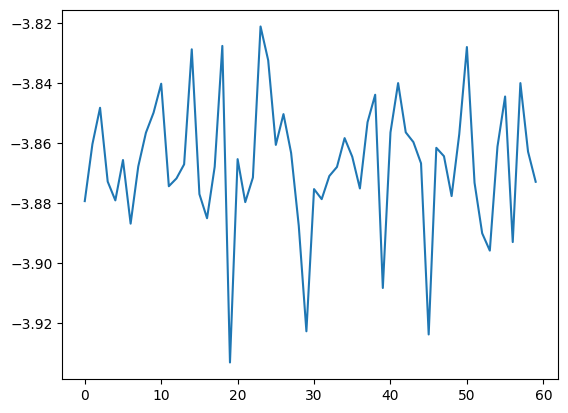

In [635]:
import matplotlib.pyplot as plt
plt.plot(energy_fixed)

### Manual setting of weights.. dropped for now, just use the same network with checkpoint loader

In [292]:
model_init.processor.processors[0].node_model.layer1.w.assign(ckpt_vars['model/processor/processors/0/node_model/layer1/w/.ATTRIBUTES/VARIABLE_VALUE'])
model_init.processor.processors[0].node_model.layer2.w.assign(ckpt_vars['model/processor/processors/0/node_model/layer2/w/.ATTRIBUTES/VARIABLE_VALUE'])
model_init.processor.processors[0].node_model.layer3.w.assign(ckpt_vars['model/processor/processors/0/node_model/layer3/w/.ATTRIBUTES/VARIABLE_VALUE'])
model_init.processor.processors[0].node_model.layer4.w.assign(ckpt_vars['model/processor/processors/0/node_model/layer4/w/.ATTRIBUTES/VARIABLE_VALUE'])
model_init.processor.processors[0].node_model.layer1.b.assign(ckpt_vars['model/processor/processors/0/node_model/layer1/b/.ATTRIBUTES/VARIABLE_VALUE'])
model_init.processor.processors[0].node_model.layer2.b.assign(ckpt_vars['model/processor/processors/0/node_model/layer2/b/.ATTRIBUTES/VARIABLE_VALUE'])
model_init.processor.processors[0].node_model.layer3.b.assign(ckpt_vars['model/processor/processors/0/node_model/layer3/b/.ATTRIBUTES/VARIABLE_VALUE'])
model_init.processor.processors[0].node_model.layer4.b.assign(ckpt_vars['model/processor/processors/0/node_model/layer4/b/.ATTRIBUTES/VARIABLE_VALUE'])
model_init.processor.processors[0].edge_model.layer1.w.assign(ckpt_vars['model/processor/processors/0/edge_model/layer1/w/.ATTRIBUTES/VARIABLE_VALUE'])
model_init.processor.processors[0].edge_model.layer2.w.assign(ckpt_vars['model/processor/processors/0/edge_model/layer2/w/.ATTRIBUTES/VARIABLE_VALUE'])
model_init.processor.processors[0].edge_model.layer3.w.assign(ckpt_vars['model/processor/processors/0/edge_model/layer3/w/.ATTRIBUTES/VARIABLE_VALUE'])
model_init.processor.processors[0].edge_model.layer4.w.assign(ckpt_vars['model/processor/processors/0/edge_model/layer4/w/.ATTRIBUTES/VARIABLE_VALUE'])
model_init.processor.processors[0].edge_model.layer1.b.assign(ckpt_vars['model/processor/processors/0/edge_model/layer1/b/.ATTRIBUTES/VARIABLE_VALUE'])
model_init.processor.processors[0].edge_model.layer2.b.assign(ckpt_vars['model/processor/processors/0/edge_model/layer2/b/.ATTRIBUTES/VARIABLE_VALUE'])
model_init.processor.processors[0].edge_model.layer3.b.assign(ckpt_vars['model/processor/processors/0/edge_model/layer3/b/.ATTRIBUTES/VARIABLE_VALUE'])
model_init.processor.processors[0].edge_model.layer4.b.assign(ckpt_vars['model/processor/processors/0/edge_model/layer4/b/.ATTRIBUTES/VARIABLE_VALUE'])
model_init.pooling_layer.linear.w.assign(ckpt_vars['model/pooling_layer/linear/w/.ATTRIBUTES/VARIABLE_VALUE'])
model_init.pooling_layer.linear.b.assign(ckpt_vars['model/pooling_layer/linear/b/.ATTRIBUTES/VARIABLE_VALUE'])
model_init.pooling_layer.global_transform.w.assign(ckpt_vars['model/pooling_layer/global_transform/w/.ATTRIBUTES/VARIABLE_VALUE'])
model_init.pooling_layer.global_transform.b.assign(ckpt_vars['model/pooling_layer/global_transform/b/.ATTRIBUTES/VARIABLE_VALUE'])
model_init.encoder.node_model.layer1.w.assign(ckpt_vars['model/encoder/node_model/layer1/w/.ATTRIBUTES/VARIABLE_VALUE'])
model_init.encoder.node_model.layer2.w.assign(ckpt_vars['model/encoder/node_model/layer2/w/.ATTRIBUTES/VARIABLE_VALUE'])
model_init.encoder.node_model.layer3.w.assign(ckpt_vars['model/encoder/node_model/layer3/w/.ATTRIBUTES/VARIABLE_VALUE'])
model_init.encoder.node_model.layer4.w.assign(ckpt_vars['model/encoder/node_model/layer4/w/.ATTRIBUTES/VARIABLE_VALUE'])
model_init.encoder.node_model.layer1.b.assign(ckpt_vars['model/encoder/node_model/layer1/b/.ATTRIBUTES/VARIABLE_VALUE'])
model_init.encoder.node_model.layer2.b.assign(ckpt_vars['model/encoder/node_model/layer2/b/.ATTRIBUTES/VARIABLE_VALUE'])
model_init.encoder.node_model.layer3.b.assign(ckpt_vars['model/encoder/node_model/layer3/b/.ATTRIBUTES/VARIABLE_VALUE'])
model_init.encoder.node_model.layer4.b.assign(ckpt_vars['model/encoder/node_model/layer4/b/.ATTRIBUTES/VARIABLE_VALUE'])
model_init.encoder.edge_model.layer1.w.assign(ckpt_vars['model/encoder/edge_model/layer1/w/.ATTRIBUTES/VARIABLE_VALUE'])
model_init.encoder.edge_model.layer2.w.assign(ckpt_vars['model/encoder/edge_model/layer2/w/.ATTRIBUTES/VARIABLE_VALUE'])
model_init.encoder.edge_model.layer3.w.assign(ckpt_vars['model/encoder/edge_model/layer3/w/.ATTRIBUTES/VARIABLE_VALUE'])
model_init.encoder.edge_model.layer4.w.assign(ckpt_vars['model/encoder/edge_model/layer4/w/.ATTRIBUTES/VARIABLE_VALUE'])
model_init.encoder.edge_model.layer1.b.assign(ckpt_vars['model/encoder/edge_model/layer1/b/.ATTRIBUTES/VARIABLE_VALUE'])
model_init.encoder.edge_model.layer2.b.assign(ckpt_vars['model/encoder/edge_model/layer2/b/.ATTRIBUTES/VARIABLE_VALUE'])
model_init.encoder.edge_model.layer3.b.assign(ckpt_vars['model/encoder/edge_model/layer3/b/.ATTRIBUTES/VARIABLE_VALUE'])
model_init.encoder.edge_model.layer4.b.assign(ckpt_vars['model/encoder/edge_model/layer4/b/.ATTRIBUTES/VARIABLE_VALUE'])

model_init.encoder.global_model.layer1.w.assign(ckpt_vars['model/encoder/global_model/layer1/w/.ATTRIBUTES/VARIABLE_VALUE'])
model_init.encoder.global_model.layer2.w.assign(ckpt_vars['model/encoder/global_model/layer2/w/.ATTRIBUTES/VARIABLE_VALUE'])
model_init.encoder.global_model.layer1.b.assign(ckpt_vars['model/encoder/global_model/layer1/b/.ATTRIBUTES/VARIABLE_VALUE'])
model_init.encoder.global_model.layer2.b.assign(ckpt_vars['model/encoder/global_model/layer2/b/.ATTRIBUTES/VARIABLE_VALUE'])

model_init.decoder.node_model.layer1.w.assign(ckpt_vars['model/decoder/node_model/layer1/w/.ATTRIBUTES/VARIABLE_VALUE'])
model_init.decoder.node_model.layer2.w.assign(ckpt_vars['model/decoder/node_model/layer2/w/.ATTRIBUTES/VARIABLE_VALUE'])
model_init.decoder.node_model.layer3.w.assign(ckpt_vars['model/decoder/node_model/layer3/w/.ATTRIBUTES/VARIABLE_VALUE'])
model_init.decoder.node_model.layer4.w.assign(ckpt_vars['model/decoder/node_model/layer4/w/.ATTRIBUTES/VARIABLE_VALUE'])
model_init.decoder.node_model.layer1.b.assign(ckpt_vars['model/decoder/node_model/layer1/b/.ATTRIBUTES/VARIABLE_VALUE'])
model_init.decoder.node_model.layer2.b.assign(ckpt_vars['model/decoder/node_model/layer2/b/.ATTRIBUTES/VARIABLE_VALUE'])
model_init.decoder.node_model.layer3.b.assign(ckpt_vars['model/decoder/node_model/layer3/b/.ATTRIBUTES/VARIABLE_VALUE'])
model_init.decoder.node_model.layer4.b.assign(ckpt_vars['model/decoder/node_model/layer4/b/.ATTRIBUTES/VARIABLE_VALUE'])
model_init.decoder.edge_model.layer1.w.assign(ckpt_vars['model/decoder/edge_model/layer1/w/.ATTRIBUTES/VARIABLE_VALUE'])
model_init.decoder.edge_model.layer2.w.assign(ckpt_vars['model/decoder/edge_model/layer2/w/.ATTRIBUTES/VARIABLE_VALUE'])
model_init.decoder.edge_model.layer3.w.assign(ckpt_vars['model/decoder/edge_model/layer3/w/.ATTRIBUTES/VARIABLE_VALUE'])
model_init.decoder.edge_model.layer4.w.assign(ckpt_vars['model/decoder/edge_model/layer4/w/.ATTRIBUTES/VARIABLE_VALUE'])
model_init.decoder.edge_model.layer1.b.assign(ckpt_vars['model/decoder/edge_model/layer1/b/.ATTRIBUTES/VARIABLE_VALUE'])
model_init.decoder.edge_model.layer2.b.assign(ckpt_vars['model/decoder/edge_model/layer2/b/.ATTRIBUTES/VARIABLE_VALUE'])
model_init.decoder.edge_model.layer3.b.assign(ckpt_vars['model/decoder/edge_model/layer3/b/.ATTRIBUTES/VARIABLE_VALUE'])
model_init.decoder.edge_model.layer4.b.assign(ckpt_vars['model/decoder/edge_model/layer4/b/.ATTRIBUTES/VARIABLE_VALUE'])
model_init.decoder.global_model.layer1.w.assign(ckpt_vars['model/decoder/global_model/layer1/w/.ATTRIBUTES/VARIABLE_VALUE'])
model_init.decoder.global_model.layer2.w.assign(ckpt_vars['model/decoder/global_model/layer2/w/.ATTRIBUTES/VARIABLE_VALUE'])
model_init.decoder.global_model.layer1.b.assign(ckpt_vars['model/decoder/global_model/layer1/b/.ATTRIBUTES/VARIABLE_VALUE'])
model_init.decoder.global_model.layer2.b.assign(ckpt_vars['model/decoder/global_model/layer2/b/.ATTRIBUTES/VARIABLE_VALUE'])


<tf.Variable 'UnreadVariable' shape=(1,) dtype=float32, numpy=array([0.00149034], dtype=float32)>

## Static GT batches

In [65]:
# for var in sampler_var.model.variables:
#     var._trainable = True 
from compgraph.tensorflow_version.graph_tuple_manipulation import get_single_graph_from_batch  
from compgraph.tensorflow_version.hamiltonian_operations import graph_hamiltonian_jit_xla, stochastic_energy_tf
import sonnet as snt
optimizer_snt=snt.optimizers.Adam(hyperparams.sim_params.learning_rate)
energies=[]
std_energies=[]
overlaps=[]
magnetizations=[]

In [764]:
# sampler_var= MCMCSampler(GT_batch_mc)
model_initv22=initialize_NQS_model_fromhyperparams(hyperparams.ansatz, hyperparams.ansatz_params)

In [ ]:
GT_trial=initialize_graph_tuples_tf_opt(64,graph, sublattice_encoding=subl)

psi_coeffs, GT_trial=sampler_var.monte_carlo_update_on_batch(new_model,GT_trial, 200)


In [ ]:
GT_trial, psi_coeffs=sampler_var.monte_carlo_update_on_batch(GT_trial, 200)

en, std_en, loc_en=stochastic_energy_tf(psi_coeffs, sampler_var, edge_pairs,template_graph, GT_trial, J2=0.0)
en, std_en

(<tf.Tensor: shape=(), dtype=complex64, numpy=(-3.9075198-0.019428365j)>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.2057508>)

In [ ]:
tf.reduce_mean(tf.reshape(GT_trial.nodes[:,0],(-1, 3, 3)))*9

<tf.Tensor: shape=(), dtype=float32, numpy=-0.15625>

In [426]:
en, std_en, loc_en=stochastic_energy_tf(psi_coeffs, sampler_var, edge_pairs,template_graph, GT_trial, J2=0.0)
en, std_en

(<tf.Tensor: shape=(), dtype=complex64, numpy=(-3.8715239+0.0016691436j)>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.084141254>)

In [ ]:
outputs=sampler_var.model(GT_batch_static)
wave=tf.complex(
    outputs[:,0] * tf.cos(outputs[:,1]),
    outputs[:,0] * tf.sin(outputs[:,1])
)

In [678]:
psi_coeffs_unif=sampler_var.model(GT_batch_static)

en_fhs_unif, std_en_fhs_unif, loc_en_fhs_unif=stochastic_energy_tf(psi_coeffs_unif, sampler_var, edge_pairs,template_graph, GT_batch_static, J2=0.0)
en_fhs_unif, std_en_fhs_unif

(<tf.Tensor: shape=(), dtype=complex64, numpy=(-3.6588-2.048107j)>,
 <tf.Tensor: shape=(), dtype=float32, numpy=15.9629965>)

In [680]:
psi_coeffs_sym=sampler_var.model(GT_batch_sym)
en, std_en, loc_en=stochastic_energy_tf(psi_coeffs_sym, sampler_var, edge_pairs,template_graph, GT_batch_sym, J2=0.0)
en, std_en

(<tf.Tensor: shape=(), dtype=complex64, numpy=(-3.880701+0.030393984j)>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.63637906>)

In [679]:
graph_first_sym=get_single_graph_from_batch(GT_batch_static, 327).nodes[:,0]
psi_coeffs_unif[327], psi_coeffs_sym[0], loc_en[0], loc_en_fhs_unif[327]

(<tf.Tensor: shape=(2,), dtype=float32, numpy=array([2.2130566, 3.0490587], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([4.8682737, 9.303544 ], dtype=float32)>,
 <tf.Tensor: shape=(), dtype=complex64, numpy=(-3.8720212+0.041996114j)>,
 <tf.Tensor: shape=(), dtype=complex64, numpy=(-4.0383034-0.0136589315j)>)

In [413]:
psi_coeffs=sampler_var.model(GT_batch_static)

en, std_en, loc_en=stochastic_energy_tf(psi_coeffs, sampler_var, edge_pairs,template_graph, GT_batch_static, J2=0.0)
en, std_en

(<tf.Tensor: shape=(), dtype=complex64, numpy=(-3.6587305-2.0480523j)>,
 <tf.Tensor: shape=(), dtype=float32, numpy=15.962457>)

In [681]:
psi_coeffs=sampler_var.model(GT_batch_static)
         
en, std_en, loc_en=stochastic_energy_tf(psi_coeffs, sampler_var, edge_pairs,template_graph, GT_batch_static, J2=0.0)
en, std_en

(<tf.Tensor: shape=(), dtype=complex64, numpy=(-3.6586215-2.0479379j)>,
 <tf.Tensor: shape=(), dtype=float32, numpy=15.961637>)

In [ ]:
model_fix=initialize_NQS_model_fromhyperparams(hyperparams.ansatz, {'hidden_size': 128, 'output_emb_size': 64, 'K_layer': 1})
model_fix(GT_batch_static)
model_var=new_model

In [ ]:
for step in range(3):
    copy_to_non_trainable(model_var, model_fix)
    print("step", step)
    for i in range(5):
        psi_coeffs=model_var(GT_batch_static)
        avg_spin=tf.cast(GT_batch_static.n_node[0],tf.float32)*tf.reduce_mean(GT_batch_static.nodes[:,0])
        print(avg_spin)
        en, std_en, loc_en=stochastic_energy_tf(psi_coeffs, model_var, edge_pairs,template_graph, GT_batch_static, J2=0.0)
        # stoch_grads=tape.gradient(en, sampler_var.model.trainable_variables)7

        print("energy", en, std_en)
        phi_terms=compute_phi_terms(GT_batch_static,sampler_te, model_fix)
        stoch_loss, stoch_grads, overlap, grad_norm=improved_stochastic_gradients(phi_terms, GT_batch_static,model_var)
        print("loss, norms overla", stoch_loss, grad_norm, overlap)
        energies.append(en)
        std_energies.append(std_en)
        overlaps.append(overlap)
        magnetizations.append(avg_spin)        
        # # Apply gradients using Keras optimizer's API
        optimizer_snt.apply(stoch_grads, model_var.trainable_variables)  
        # optimizer.apply_gradients(zip(stoch_grads, sampler_var.model.trainable_variables))    


/home/s3378209/data1/envs/gnets2/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


step 0
tf.Tensor(0.0, shape=(), dtype=float32)
energy tf.Tensor((-3.658573-2.0479035j), shape=(), dtype=complex64) tf.Tensor(15.96129, shape=(), dtype=float32)
loss, norms overla tf.Tensor(0.00057254726, shape=(), dtype=float32) tf.Tensor(0.39975992, shape=(), dtype=float32) tf.Tensor(0.9994276, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
energy tf.Tensor((0.3006902+1.2047459j), shape=(), dtype=complex64) tf.Tensor(7.826535, shape=(), dtype=float32)
loss, norms overla tf.Tensor(1.6223369, shape=(), dtype=float32) tf.Tensor(261.67593, shape=(), dtype=float32) tf.Tensor(0.19743678, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
energy tf.Tensor((1.1124254-0.043208756j), shape=(), dtype=complex64) tf.Tensor(11.007319, shape=(), dtype=float32)
loss, norms overla tf.Tensor(1.921966, shape=(), dtype=float32) tf.Tensor(191.69118, shape=(), dtype=float32) tf.Tensor(0.14631902, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
energy tf.Tens

/home/s3378209/data1/envs/gnets2/lib/python3.11/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/s3378209/data1/envs/gnets2/lib/python3.11/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


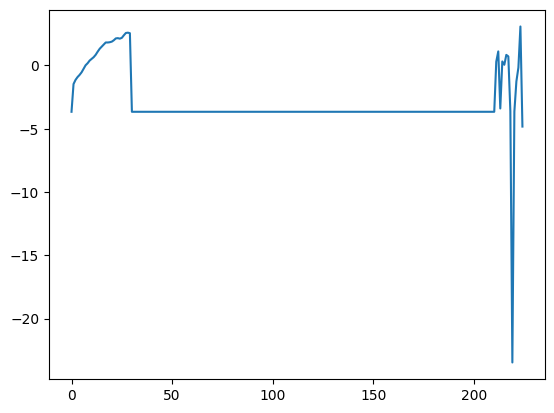

In [775]:
import matplotlib.pyplot as plt
plt.plot(energies)

In [740]:
import importlib
import compgraph.monte_carlo
importlib.reload(compgraph.monte_carlo)
import compgraph.monte_carlo
from compgraph.monte_carlo import MCMCSampler
from compgraph.monte_carlo import compute_phi_terms

In [ ]:
sampler_te=MCMCSampler(GT_batch_sym, template_graph,beta=0.07, edge_pairs=edge_pairs)


In [731]:
model_initv22=initialize_NQS_model_fromhyperparams(hyperparams.ansatz, {'hidden_size': 128, 'output_emb_size': 64, 'K_layer': 1})

In [776]:
phi_terms=compute_phi_terms(GT_batch_static,sampler_te, new_model)
phi_terms[0]

<tf.Tensor: shape=(), dtype=complex64, numpy=(0.15867122+0.042723246j)>

In [743]:
out_g0= new_model(g0)
tf.complex(real= out_g0[:,0] * tf.cos(out_g0[:,1]), imag=out_g0[:,0] * tf.sin(out_g0[:,1]))

<tf.Tensor: shape=(1,), dtype=complex64, numpy=array([0.03420804+0.00621235j], dtype=complex64)>

In [697]:
out_full_batch= sampler_te.model(GT_batch_static)
psi_coeffs=tf.complex(real= out_full_batch[:,0] * tf.cos(out_full_batch[:,1]), imag=out_full_batch[:,0] * tf.sin(out_full_batch[:,1]))

In [ ]:
tf.reduce_sum(tf.math.conj(psi_coeffs)*phi_terms) /(tf.norm(psi_coeffs)*tf.norm(phi_terms))

0.0

In [598]:
g0=get_single_graph_from_batch(GT_batch_3x3_full, 0)
new_graphs_g0, amplitudesg0j= graph_hamiltonian_jit_xla(g0, sampler_te.edge_pairs, j2=0.0, template_graph=sampler_te.template)
all_amplitudes0j=tf.cast(amplitudesg0j, tf.complex64)
sampler_te.ite_step(new_graphs_g0, all_amplitudes0j, g0), phi_terms[0]

(<tf.Tensor: shape=(), dtype=complex64, numpy=(-0.2544435-0.0452677j)>,
 <tf.Tensor: shape=(), dtype=complex64, numpy=(-0.25444347-0.04526771j)>)

In [746]:
psi_coeff_out=new_model(GT_batch_3x3_full)
psi_coeffs_full=tf.complex(
    real=psi_coeff_out[:, 0] * tf.cos(psi_coeff_out[:, 1]),
    imag=psi_coeff_out[:, 0] * tf.sin(psi_coeff_out[:, 1])
)
tf.norm(psi_norm)

<tf.Tensor: shape=(), dtype=complex64, numpy=(0.9999999-1.0683316e-10j)>

In [747]:
from compgraph.monte_carlo import compute_phi_terms
phi_terms=compute_phi_terms(GT_batch_3x3_full,sampler_te, new_model)
phi_norm=phi_terms/tf.norm(phi_terms)
psi_norm=psi_coeffs_full/tf.norm(psi_coeffs_full)
tf.reduce_sum(tf.math.conj(phi_norm) * psi_norm)**2

<tf.Tensor: shape=(), dtype=complex64, numpy=(1+1.8008554e-06j)>

In [ ]:
psi_normalized = psi_coeff / tf.norm(psi_coeff)
phi_normalized = phi_terms / tf.norm(phi_terms)
tf.reduce_sum(tf.math.conj(phi_normalized) * psi_normalized)

In [ ]:
GT_batch_3x3_full=initialize_graph_tuples_tf_opt(1,graph, sublattice_encoding=subl,full_size_hilbert='yes')
phi_full=compute_phi_terms(GT_batch_3x3_full,sampler_te, new_model)
phi_full

In [ ]:
psi_full = sampler_var.model(GT_batch_3x3_full)

# Convert output to complex coefficients
psi_coeff_full = tf.complex(
    real=psi_full[:, 0] * tf.cos(psi_full[:, 1]),
    imag=psi_full[:, 0] * tf.sin(psi_full[:, 1])
)
psi_coeff_full
outputs=sampler_var.model(GT_batch_static)
wave=tf.complex(
    outputs[:,0] * tf.cos(outputs[:,1]),
    outputs[:,0] * tf.sin(outputs[:,1])
)
tf.reduce_sum(tf.math.conj(psi_coeff_full/tf.norm(psi_coeff_full))*phi_full/tf.norm(phi_full))

In [487]:
psi = sampler_te.model(GT_batch_sym)

# Convert output to complex coefficients
psi_coeff = tf.complex(
    real=psi[:, 0] * tf.cos(psi[:, 1]),
    imag=psi[:, 0] * tf.sin(psi[:, 1])
)
psi_coeff

<tf.Tensor: shape=(64,), dtype=complex64, numpy=
array([-4.4149094 +0.35922673j, -3.5362275 -2.7089322j ,
        7.2901626 +5.4942894j ,  9.095603  -0.76841635j,
       -4.414908  +0.35922554j, -3.8015556 -2.9110658j ,
       -1.2727592 -0.8860949j , -3.5362337 -2.708926j  ,
       -3.5362346 -2.708943j  ,  4.068833  +3.3236406j ,
       -3.80156   -2.9110432j ,  9.095601  -0.76841426j,
        2.3707788 +1.7460958j , -3.5362337 -2.7089312j ,
       -3.5362318 -2.7089353j , -1.2727623 -0.8861002j ,
        7.290162  +5.494289j  , -3.5362358 -2.7089386j ,
        0.87679315+0.64270127j, -3.8015575 -2.91105j   ,
       -3.8015597 -2.9110458j ,  0.2769644 +0.29144546j,
        1.9779421 +1.4355237j , -0.85693496-0.79822344j,
        4.068834  +3.323632j  , -1.272761  -0.8860974j ,
        0.87679404+0.64270127j, -4.414909  +0.35922667j,
       -4.8325477 +0.5887513j , -4.832538  +0.5887548j ,
        4.0688324 +3.3236403j , -3.5362358 -2.7089279j ,
        7.2901807 +5.494271j  , -3.5362

In [777]:
import compgraph.monte_carlo
importlib.reload(compgraph.monte_carlo)
from compgraph.monte_carlo import MCMCSampler
from compgraph.monte_carlo import compute_phi_terms
sampler_var= MCMCSampler(GT_batch_mc)

In [ ]:
compute_exact_energy(model_var,GT_batch_3x3_full, edge_pairs, template_graph, J2=0.0)


<tf.Tensor: shape=(), dtype=complex64, numpy=(-2.023235+1.0579824e-06j)>

In [789]:
for i in range(200):
    GT_batch_sym, psi_coeff=sampler_var.monte_carlo_update_on_batch(model_var,GT_batch_sym)
compute_exact_energy(model_var,GT_batch_sym, edge_pairs, template_graph, J2=0.0)


<tf.Tensor: shape=(), dtype=complex64, numpy=(-2.805707+0.14609103j)>

In [797]:
# optimizer=tf.keras.optimizers.Adam(learning_rate=hyperparams.sim_params.learning_rate)
import sonnet as snt
# optimizer_snt=snt.optimizers.Adam(hyperparams.sim_params.learning_rate)

for step in range(40):
    copy_to_non_trainable(model_var, model_fix)
    print("step", step)
    for i in range(10):
        for j in range(4):
            GT_batch_sym, psi_coeff=sampler_var.monte_carlo_update_on_batch(model_var,GT_batch_sym)
            # _, psi_coeff=sampler_var.monte_carlo_update_on_batchv2(GT_batch_sym, 2)
        avg_spin=tf.cast(GT_batch_sym.n_node[0],tf.float32)*tf.reduce_mean(GT_batch_sym.nodes[:,0])
        print(avg_spin)
        en, std_en, loc_en=stochastic_energy_tf(psi_coeff, model_var, edge_pairs,template_graph, GT_batch_sym, J2=0.0)
        # stoch_grads=tape.gradient(en, sampler_var.model.trainable_variables)
        print("energy", en, std_en)
        phi_terms=compute_phi_terms(GT_batch_sym,sampler_te,model_fix)
        stoch_loss, stoch_grads, overlap, grad_norm=improved_stochastic_gradients(phi_terms, GT_batch_sym,model_var)
        print("overlap", overlap)
        
        # # # Apply gradients using Keras optimizer's API
        optimizer_snt.apply(stoch_grads, model_var.trainable_variables)  
        # # optimizer.apply_gradients(zip(stoch_grads, sampler_var.model.trainable_variables))    


step 0
tf.Tensor(-0.40625, shape=(), dtype=float32)
energy tf.Tensor((-2.478646-0.044175655j), shape=(), dtype=complex64) tf.Tensor(2.2289937, shape=(), dtype=float32)
overlap tf.Tensor(0.99519163, shape=(), dtype=float32)
tf.Tensor(0.09375, shape=(), dtype=float32)
energy tf.Tensor((-2.4402974+0.114509344j), shape=(), dtype=complex64) tf.Tensor(2.3282359, shape=(), dtype=float32)
overlap tf.Tensor(0.9958951, shape=(), dtype=float32)
tf.Tensor(0.0625, shape=(), dtype=float32)
energy tf.Tensor((-2.1779826-0.03669383j), shape=(), dtype=complex64) tf.Tensor(1.926048, shape=(), dtype=float32)
overlap tf.Tensor(0.99760985, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
energy tf.Tensor((-2.4176288-0.13072795j), shape=(), dtype=complex64) tf.Tensor(1.7696027, shape=(), dtype=float32)
overlap tf.Tensor(0.9974915, shape=(), dtype=float32)
tf.Tensor(-0.5625, shape=(), dtype=float32)
energy tf.Tensor((-2.8597527-0.13467836j), shape=(), dtype=complex64) tf.Tensor(1.7118797, shap

In [51]:
_, psi_coeff=sampler_var.monte_carlo_update_on_batchv2(GT_batch_sym, 2, True)


In [241]:
en, std_en, loc_en=stochastic_energy_tf(psi_new, sampler_var, edge_pairs,template_graph, GT_batch_sym, J2=0.0)
en, std_en

(<tf.Tensor: shape=(), dtype=complex64, numpy=(4.47314+0.003957983j)>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.1533726>)

In [44]:
optimizer_snt.apply(stoch_grads, sampler_var.model.trainable_variables)  
stoch_loss, stoch_grads, overlap, grad_norm=improved_stochastic_gradients(phi_terms, GT_batch_sym,sampler_var.model)
phi_terms=compute_phi_terms(GT_batch_sym,sampler_te)
en, std_en, loc_en=stochastic_energy_tf(psi_coeff, sampler_var, edge_pairs,template_graph, GT_batch_sym, J2=0.0)
_, psi_coeff=sampler_var.monte_carlo_update_on_batchv2(GT_batch_sym, 2)

psi_new2=sampler_var.model(GT_batch_sym)

psi_new2

<tf.Tensor: shape=(64, 2), dtype=float32, numpy=
array([[-0.24908383,  6.01952   ],
       [-0.2837029 ,  2.4377344 ],
       [-0.297812  ,  3.1605732 ],
       [-0.37149292,  0.4224616 ],
       [-0.278804  ,  5.042606  ],
       [-0.39239454,  7.3564568 ],
       [-0.31308818,  2.2849436 ],
       [-0.3923942 ,  7.356456  ],
       [-0.36524263,  7.148493  ],
       [-0.28494188,  4.9743733 ],
       [-0.26529673,  5.196221  ],
       [-0.28370282,  2.437736  ],
       [-0.21712206,  4.7338758 ],
       [-0.28061378,  5.318943  ],
       [-0.37023926,  2.561185  ],
       [-0.39239383,  7.35646   ],
       [-0.37149292,  0.42245883],
       [-0.39239416,  7.3564587 ],
       [-0.19557604,  4.8333797 ],
       [-0.3923943 ,  7.3564577 ],
       [-0.21712221,  4.733872  ],
       [-0.21712181,  4.73387   ],
       [-0.3496948 ,  5.926651  ],
       [-0.19557579,  4.833382  ],
       [-0.2806139 ,  5.3189425 ],
       [-0.37023953,  2.5611842 ],
       [-0.2652968 ,  5.1962237 ],
      

# Q. How is the MC convergence to the Ground state

## Step 1: Load one model
In order to do so we need to initialize a model with the same structure as the original one
We use the dataclass to initialize simulation parameters

In [180]:
from compgraph.tensorflow_version.model_loading import load_model_from_path, extract_hyperparams_from_path
from simulation.initializer import initialize_NQS_model_fromhyperparams
from simulation.initializer import create_graph_from_ham
from compgraph.tensorflow_version.graph_tuple_manipulation import initialize_graph_tuples_tf_opt

import sonnet as snt  
path_model_trained='/home/s3378209/data1/repfin/thesis_MSc/checkpointed_logs/system_Heisenberg/2dsquare_03_03_Neel/beta0.2__bs_128lr7.0e-05_loop256x18_overlap_VMC/GNN2adv_h128_e64_K2/checkpoints/ckpt-6'
hyperparams_from_path=extract_hyperparams_from_path(path_model_trained)
model_empty=initialize_NQS_model_fromhyperparams(hyperparams_from_path.ansatz, hyperparams_from_path.ansatz_params)
graph,subl=create_graph_from_ham(hyperparams_from_path.graph_params.graphType,(hyperparams_from_path.graph_params.n,hyperparams_from_path.graph_params.m)
                                 ,sublattice=hyperparams_from_path.graph_params.sublattice)
GT_batch_sym=initialize_graph_tuples_tf_opt(64, graph, subl)
optimizer_empty=snt.optimizers.Adam(hyperparams_from_path.sim_params.learning_rate)
before=(model_empty(GT_batch_sym)[0])
load_model_from_path(model_empty,path_model_trained,optimizer_empty)
model_empty(GT_batch_sym)[0],before


/home/s3378209/data1/envs/gnets2/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


(<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.01748912, 0.36321738], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 0.46810073, -0.8885348 ], dtype=float32)>)

In [2]:
GT_batch_complete=initialize_graph_tuples_tf_opt(1, graph, subl, full_size_hilbert='yes')

In [181]:
import tensorflow as tf
from tests.full_hilbert_malloc import compute_exact_energy
from compgraph.tensorflow_version.graph_tuple_manipulation import precompute_graph_structure
send, receiv, edge_pairs=precompute_graph_structure(graph)
template_graph=initialize_graph_tuples_tf_opt(tf.shape(edge_pairs)[0]+1, graph, sublattice_encoding=subl)
compute_exact_energy(model_empty, GT_batch_complete, edge_pairs, template_graph, J2=0.0)

<tf.Tensor: shape=(), dtype=float32, numpy=-1.8191575>

# Q2: Can I still apply exact training?


In [66]:
from tests.full_hilbert_malloc import phi_terms
from compgraph.useful import copy_to_non_trainable

model_te=initialize_NQS_model_fromhyperparams(hyperparams_from_path.ansatz, hyperparams_from_path.ansatz_params)
model_te(GT_batch_complete)
copy_to_non_trainable(model_empty, model_te)
model_te(GT_batch_complete), model_te(GT_batch_sym)[0]


/home/s3378209/data1/envs/gnets2/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


(<tf.Tensor: shape=(512, 2), dtype=float32, numpy=
 array([[-0.10266593,  0.38816774],
        [-0.02354845,  0.38878754],
        [ 0.02404265,  0.38529575],
        ...,
        [ 0.04045544, -0.50824046],
        [ 0.02808416, -0.5091125 ],
        [ 0.1575138 , -0.52514124]], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([-0.00339887,  0.16787513], dtype=float32)>)

In [67]:
from tests.full_hilbert_malloc import exact_gradients
energies=[]
std_energies=[]
overlaps=[]
magnetizations=[]
optimizer_empty2=snt.optimizers.Adam(hyperparams_from_path.sim_params.learning_rate)


In [ ]:
hyperparams_from_path.sim_params.learning_rate

In [ ]:
import time
from compgraph.useful import copy_to_non_trainable
steps=10
n_sites=hyperparams_from_path.graph_params.n*hyperparams_from_path.graph_params.m
for iteration in range(steps):
    copy_to_non_trainable(model_empty, model_te)
    phi_terms_norm=phi_terms(model_te, GT_batch_complete, template_graph, edge_pairs, 0.007,0)

    # Inner training loop
    for innerstep in range(hyperparams_from_path.sim_params.inner_loop):
        inner_start_time = time.time()
        

        if hyperparams_from_path.sim_params.gradient=='overlap':
            # Compute loss and gradients
            if inner_step==0:
                energy = compute_exact_energy(model_empty, GT_batch_complete, edge_pairs,template_graph)

            loss, gradients = exact_gradients(
                model_empty, GT_batch_complete, 
                phi_terms_norm)

            # Apply gradients
            optimizer_empty2.apply(gradients, model_empty.trainable_variables)
            
            # Compute energy
            

        # Evaluate model on all configurations
        outputs = model_empty(GT_batch_complete)
        amplitudes = outputs[:, 0]
        phases = outputs[:, 1]
        psi = tf.complex(
            real=amplitudes * tf.cos(phases),
            imag=amplitudes * tf.sin(phases)
        )
        
        # Compute probabilities
        probs = tf.abs(psi)**2
        probs = probs / tf.reduce_sum(probs)
        # Compute magnetization
        # Extract spins from all configurations
        configs = GT_batch_complete.nodes[:, 0]
        configs_reshaped = tf.reshape(configs, [2**n_sites, n_sites])
                        
        # Compute magnetization for each configuration
        config_mags = tf.reduce_sum(configs_reshaped, axis=1) / n_sites
        
        # Weight by probabilities
        magnetization = tf.reduce_sum(config_mags * tf.cast(probs, config_mags.dtype))
        

        print(energy)
        # Log metrics
        energies.append(energy.numpy())
        magnetizations.append(magnetization.numpy())
        
        # Print progress
        print(f"Iteration {iteration}.{innerstep}: Energy = {energy.numpy():.6f}, "
                f"Magnetization = {magnetization.numpy():.6f}, "
                f"Loss = {loss.numpy():.6f}")
        
        inner_end_time = time.time()
    

    outer_end_time = time.time()


tf.Tensor(-3.8222406, shape=(), dtype=float32)
Iteration 0.0: Energy = -3.822241, Magnetization = 0.107931, Loss = 0.000010
tf.Tensor(-3.7355027, shape=(), dtype=float32)
Iteration 0.1: Energy = -3.735503, Magnetization = 0.110169, Loss = 0.010392
tf.Tensor(-3.6243746, shape=(), dtype=float32)
Iteration 0.2: Energy = -3.624375, Magnetization = 0.109223, Loss = 0.025499
tf.Tensor(-3.615848, shape=(), dtype=float32)
Iteration 0.3: Energy = -3.615848, Magnetization = 0.109251, Loss = 0.024807
tf.Tensor(-3.7415159, shape=(), dtype=float32)
Iteration 0.4: Energy = -3.741516, Magnetization = 0.110125, Loss = 0.010463
tf.Tensor(-3.8162806, shape=(), dtype=float32)
Iteration 0.5: Energy = -3.816281, Magnetization = 0.108767, Loss = 0.000487
tf.Tensor(-3.7575493, shape=(), dtype=float32)
Iteration 0.6: Energy = -3.757549, Magnetization = 0.110575, Loss = 0.006880
tf.Tensor(-3.7075236, shape=(), dtype=float32)
Iteration 0.7: Energy = -3.707524, Magnetization = 0.109680, Loss = 0.013769
tf.Tensor

In [183]:
model_trained=initialize_NQS_model_fromhyperparams(hyperparams_from_path.ansatz, hyperparams_from_path.ansatz_params)
before=model_trained(GT_batch_complete)
copy_to_non_trainable(model_empty, model_trained)
model_trained(GT_batch_complete), before

/home/s3378209/data1/envs/gnets2/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


(<tf.Tensor: shape=(512, 2), dtype=float32, numpy=
 array([[-0.1026665 ,  0.3881675 ],
        [-0.02354827,  0.38878804],
        [ 0.0240426 ,  0.38529587],
        ...,
        [ 0.04045553, -0.50824046],
        [ 0.02808413, -0.50911236],
        [ 0.15751398, -0.52514106]], dtype=float32)>,
 <tf.Tensor: shape=(512, 2), dtype=float32, numpy=
 array([[ 0.38623005, -0.8916367 ],
        [ 0.3869656 , -0.8787532 ],
        [ 0.42839348, -0.9010998 ],
        ...,
        [ 0.9160185 , -0.86647785],
        [ 0.92643607, -0.87531126],
        [ 1.0573096 , -0.8721044 ]], dtype=float32)>)

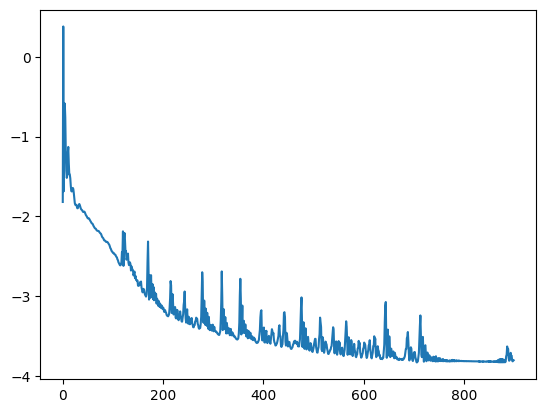

In [72]:
import matplotlib.pyplot as plt
plt.plot(energies)

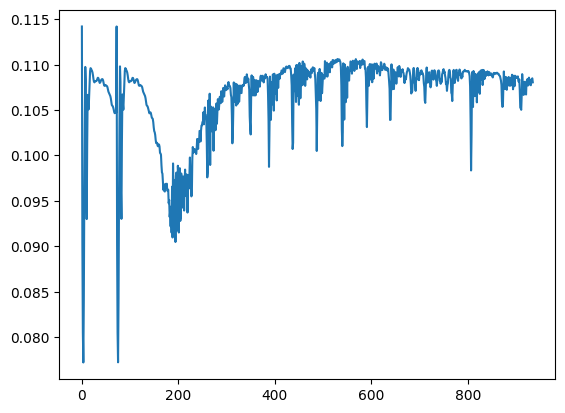

In [189]:
plt.plot(magnetizations)

# Q3: If training with exact overlap still works, how can I improve the gradients to achieve convergence?


## Q3.1 I want to see how well the monte carlo update does  in sampling the configurations
note - We assume model_empty was already loaded

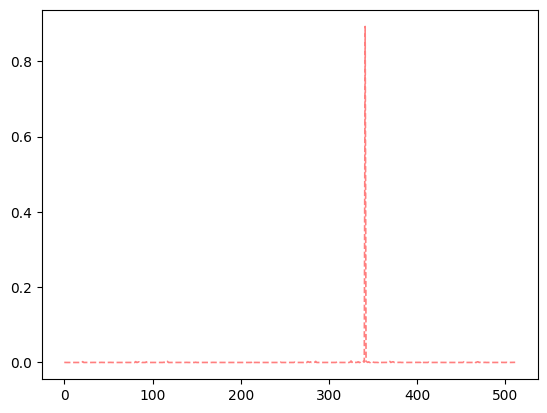

In [190]:
psi_coeff_out=model_empty(GT_batch_complete)
psi_coeff_full = tf.complex(
    real=psi_coeff_out[:, 0] * tf.cos(psi_coeff_out[:, 1]),
    imag=psi_coeff_out[:, 0] * tf.sin(psi_coeff_out[:, 1])
)
prob_ampl=tf.abs(psi_coeff_full)**2

num_bins=2**n_sites

plt.plot(
    np.arange(num_bins),
    prob_coeff,
    color='red',
    linestyle='--',  # dashed line
    linewidth=1.2,   # thinner line
    alpha=0.5,       # partially transparent
    label='Graph Quantum State Probabilities'
)


In [192]:
en, std_en, loc_en=stochastic_energy_tf(psi_coeff_out, model_trained, edge_pairs,template_graph, GT_batch_complete, J2=0.0)

/home/s3378209/data1/envs/gnets2/lib/python3.11/site-packages/tensorflow/python/framework/ops.py:294: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._numpy())
/home/s3378209/data1/envs/gnets2/lib/python3.11/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


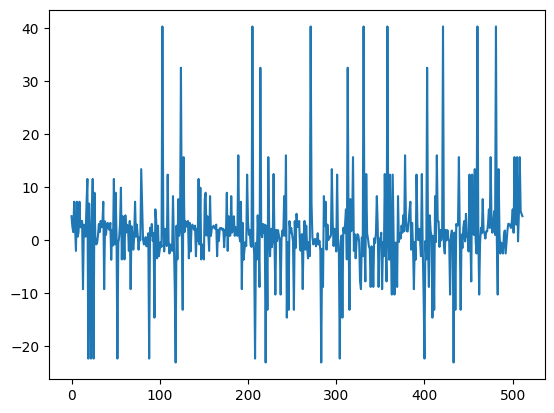

In [193]:
plt.plot(loc_en)

In [184]:

from compgraph.monte_carlo import MCMCSampler
from compgraph.tensorflow_version.hamiltonian_operations import stochastic_energy_tf
GT_batch_mc=initialize_graph_tuples_tf_opt(128,graph, sublattice_encoding=subl)

sampler_var= MCMCSampler(GT_batch_mc)
thermalization=1000
for i in range(thermalization):
    GT_batch_mc, psi_coeff=sampler_var.monte_carlo_update_on_batch(model_empty,GT_batch_mc)


This is the shape, dummy check for retracing! Tensor("strided_slice:0", shape=(), dtype=int32)


In [5]:
for i in range(thermalization):
    GT_batch_mc, psi_coeff=sampler_var.monte_carlo_update_on_batch(model_empty,GT_batch_mc)


In [17]:
import numpy as np
import tensorflow as tf
# np.sqrt(loc_en.shape[0])

<tf.Tensor: shape=(), dtype=float32, numpy=11.313708>

In [185]:
# thermalization=1000
# for i in range(thermalization):
#     GT_batch_mc, psi_coeff=sampler_var.monte_carlo_update_on_batch(model_empty,GT_batch_mc)

GT_batch_mc, psi_coeff=sampler_var.monte_carlo_update_on_batch(model_empty,GT_batch_mc)
en, std_en, loc_en=stochastic_energy_tf(psi_coeff, model_empty, edge_pairs,template_graph, GT_batch_mc, J2=0.0)
en, std_en/tf.math.sqrt(tf.cast(loc_en.shape[0], tf.float32))


(<tf.Tensor: shape=(), dtype=complex64, numpy=(-1.9947183+0.06031894j)>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.15404795>)

In [ ]:

en, std_en, loc_en=stochastic_energy_tf(psi_coeff, model_empty, edge_pairs,template_graph, GT_batch_mc, J2=0.0)


In [187]:
loc_en

<tf.Tensor: shape=(128,), dtype=complex64, numpy=
array([-8.852443  +0.8698884j , -1.802497  +0.00961374j,
       -3.4554513 -4.316443j  , -1.8024956 +0.009621j  ,
       -1.8024979 +0.00960866j, -1.8024973 +0.00961124j,
       -1.8024971 +0.00961175j, -1.8024975 +0.00961139j,
       -8.852462  +0.8698459j , -1.8024981 +0.00960861j,
       -8.852465  +0.86985517j, -1.8024962 +0.00962044j,
       -1.8024975 +0.00960953j, -1.8024975 +0.00961013j,
       -1.8024976 +0.00961024j, -1.8024964 +0.00961577j,
       -1.8024961 +0.00961911j, -1.802499  +0.00960295j,
       -1.8024969 +0.00961323j, -1.8024976 +0.00960946j,
       -1.8024983 +0.00960546j, -1.8024976 +0.00960816j,
       -8.85245   +0.86988866j, -1.8024976 +0.00961097j,
        0.47540873+1.8432419j , -1.8024977 +0.0096048j ,
       -1.8024967 +0.00961344j, -1.8024971 +0.00961173j,
       -1.8024974 +0.00961112j, -1.8024971 +0.00961376j,
       -1.8024974 +0.00961159j,  1.2814214 +0.81041175j,
       -8.85245   +0.86988366j, -1.802

In [186]:
compute_exact_energy(model_empty, GT_batch_complete, edge_pairs, template_graph, J2=0.0)

<tf.Tensor: shape=(), dtype=float32, numpy=-1.8191563>

In [188]:
def extract_configs_as_indices(GT_batch):
    """
    Extract configurations from GraphTuple and convert to integer indices
    for comparison with the full Hilbert space.
    """
    # Extract spin configurations (assuming they're in the first column of nodes)
    configs = tf.reshape(GT_batch.nodes[:, 0], (-1, GT_batch.n_node[0]))
    
    # Convert from [-1,1] format to [0,1] format
    configs_01 = tf.cast((configs + 1) / 2, tf.int32)
    
    # Convert each configuration to an integer index in the Hilbert space
    # Using binary representation: each config maps to a unique integer
    indices = tf.zeros(tf.shape(configs)[0], dtype=tf.int32)
    
    for i in range(tf.shape(configs)[1]):
        bit_value = tf.cast(configs_01[:, i], tf.int32) * (2 ** i)
        indices += bit_value
    
    return indices


In [277]:
import compgraph.monte_carlo
importlib.reload(compgraph.monte_carlo)

import compgraph.tensorflow_version.model_loading
thermalization=500
GT_batch_mc=initialize_graph_tuples_tf_opt(128,graph, sublattice_encoding=subl)
sampler_var= MCMCSampler(GT_batch_mc)
for i in range(thermalization):
    GT_batch_mc, psi_coeff=sampler_var.monte_carlo_update_on_batch(model_empty,GT_batch_mc)


This is the shape, dummy check for retracing! Tensor("strided_slice:0", shape=(), dtype=int32)


In [278]:
num_nodes=hyperparams_from_path.graph_params.n*hyperparams_from_path.graph_params.m 
num_bins = 2 ** num_nodes
# Create a histogram (count per configuration index)
hist_counts = np.zeros(num_bins)
samples=500
for i in range(samples):
    for l in range(num_nodes):
        GT_batch_mc, psi_coeff=sampler_var.monte_carlo_update_on_batch(model_empty,GT_batch_mc)

    config_indices_np=extract_configs_as_indices(GT_batch_mc).numpy()
    for idx in config_indices_np:
        hist_counts[idx] += 1


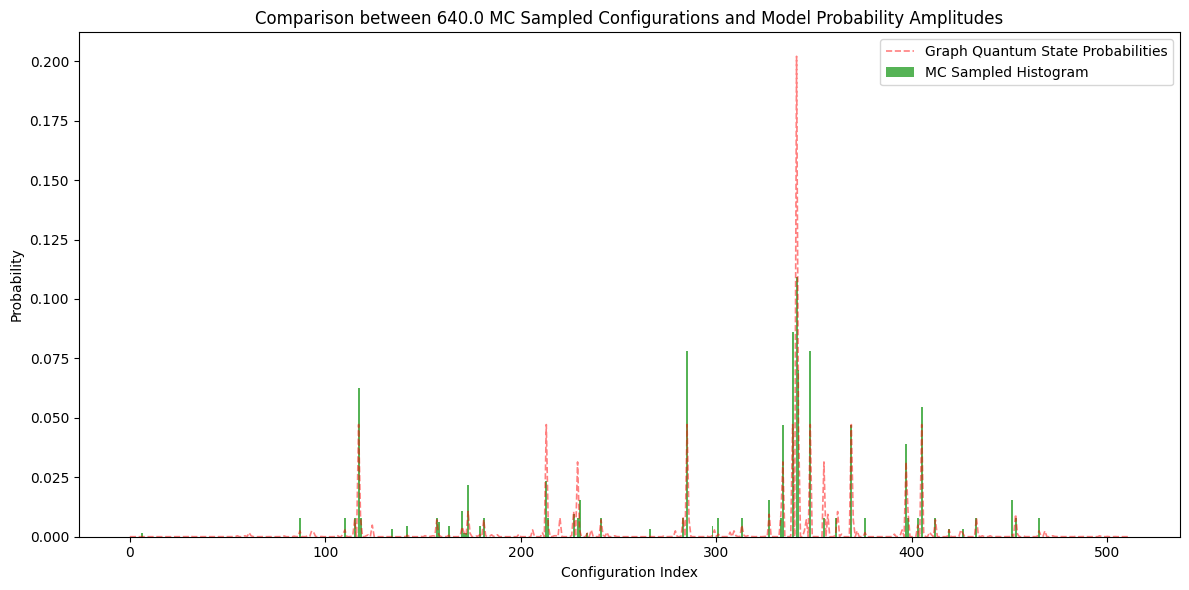

In [279]:
import numpy as np
import matplotlib.pyplot as plt
hist_prob = hist_counts2 / np.sum(hist_counts2)  # Normalize to get probabilities
num_bins = 2 ** num_nodes  # total number of configurations

plt.figure(figsize=(12, 6))

# Histogram from Monte Carlo sampling (bar plot)
plt.bar(
    np.arange(num_bins),
    hist_prob,
    width=1.0,
    alpha=0.8,
    color='tab:green',
    label='MC Sampled Histogram'
)

# Probability amplitudes from the full Hilbert space (dashed line plot)
# Use a dashed linestyle ('--'), reduce line width, and possibly reduce alpha
plt.plot(
    np.arange(num_bins),
    prob_coeff,
    color='red',
    linestyle='--',  # dashed line
    linewidth=1.2,   # thinner line
    alpha=0.5,       # partially transparent
    label='Graph Quantum State Probabilities'
)

plt.xlabel("Configuration Index")
plt.ylabel("Probability")
plt.title(f"Comparison between {(np.sum(hist_counts2))} MC Sampled Configurations and Model Probability Amplitudes")
plt.legend()
plt.tight_layout()
plt.show()


In [24]:
GT_batch_mc_32=initialize_graph_tuples_tf_opt(32,graph, sublattice_encoding=subl)
thermalization=1000
for i in range(thermalization):
    GT_batch_mc_32, psi_coeff=sampler_var.monte_carlo_update_on_batch(model_empty,GT_batch_mc_32)

samples=100
energy_values=[]
std_values=[]
im_values=[]
for it in range(samples):
    for i in range(4):
        GT_batch_mc_32, psi_coeff=sampler_var.monte_carlo_update_on_batch(model_empty,GT_batch_mc_32)
    en, std, loc_en= stochastic_energy_tf(psi_coeff, model_empty, edge_pairs,template_graph, GT_batch_mc_32, J2=0.0)
    std=std/tf.math.sqrt(tf.cast(loc_en.shape[0], tf.float32))
    energy_values.append(tf.math.real(en).numpy())
    im_values.append(tf.math.imag(en).numpy())
    std_values.append(std.numpy())


In [28]:
GT_batch_mc=initialize_graph_tuples_tf_opt(256,graph, sublattice_encoding=subl)


In [29]:
# thermalization=1000
# for i in range(thermalization):
#     GT_batch_mc, psi_coeff=sampler_var.monte_carlo_update_on_batch(model_empty,GT_batch_mc)

samples=100
energy_values=[]
std_values=[]
im_values=[]
for it in range(samples):
    for i in range(4):
        GT_batch_mc, psi_coeff=sampler_var.monte_carlo_update_on_batch(model_empty,GT_batch_mc)
    en, std, loc_en= stochastic_energy_tf(psi_coeff, model_empty, edge_pairs,template_graph, GT_batch_mc, J2=0.0)
    std=std/tf.math.sqrt(tf.cast(loc_en.shape[0], tf.float32))
    energy_values.append(tf.math.real(en).numpy())
    im_values.append(tf.math.imag(en).numpy())
    std_values.append(std.numpy())

This is the shape, dummy check for retracing! Tensor("strided_slice:0", shape=(), dtype=int32)


In [21]:
exact_energy=compute_exact_energy(model_empty, GT_batch_complete, edge_pairs, template_graph, J2=0.0)
exact_energy

<tf.Tensor: shape=(), dtype=float32, numpy=-1.8191574>

/tmp/ipykernel_3725068/1431480051.py:102: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


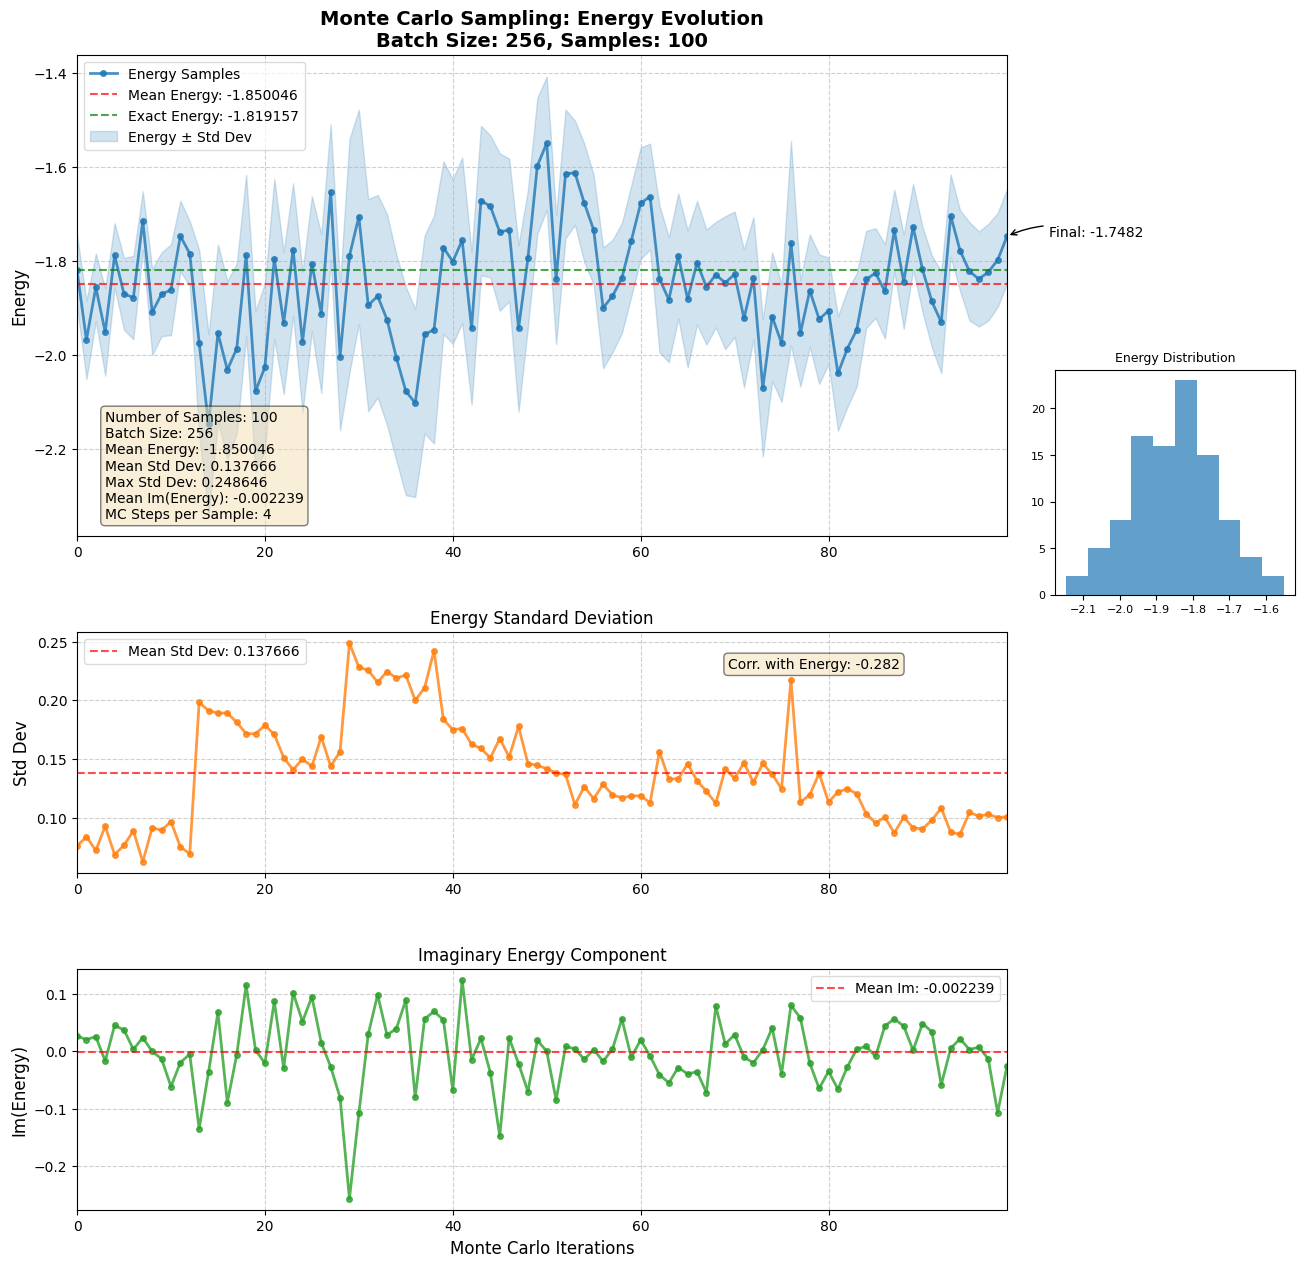

In [30]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec

# Create figure with subplots in a vertical arrangement
fig = plt.figure(figsize=(12, 15))
gs = GridSpec(3, 1, height_ratios=[2, 1, 1], hspace=0.3)

# Extract batch size from your code
batch_size = GT_batch_mc.n_node.shape[0]

# Calculate statistics
mean_energy = np.mean(energy_values)
final_energy = energy_values[-1]
mean_std = np.mean(std_values)
mean_im = np.mean(im_values)
max_std = np.max(std_values)

# Create iterations array
iterations = np.arange(len(energy_values))

# Plot 1: Energy Values
ax1 = fig.add_subplot(gs[0])
ax1.plot(iterations, energy_values, 'o-', color='#1f77b4', markersize=4, 
         label='Energy Samples', alpha=0.8, linewidth=2)
ax1.axhline(y=mean_energy, color='r', linestyle='--', 
            label=f'Mean Energy: {mean_energy:.6f}', alpha=0.7)
ax1.axhline(y=exact_energy, color='g', linestyle='--',
            label=f'Exact Energy: {exact_energy:.6f}', alpha=0.7)
# Add shaded region for energy variance
ax1.fill_between(iterations, 
                np.array(energy_values) - np.array(std_values),
                np.array(energy_values) + np.array(std_values),
                color='#1f77b4', alpha=0.2,
                label='Energy ± Std Dev')

ax1.set_title(f'Monte Carlo Sampling: Energy Evolution\nBatch Size: {batch_size}, Samples: {samples}', 
              fontsize=14, fontweight='bold')
ax1.set_ylabel('Energy', fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.legend(loc='best', framealpha=0.7)

# Annotate key statistics
ax1.annotate(f'Final: {final_energy:.4f}', 
            xy=(len(energy_values)-1, energy_values[-1]), 
            xytext=(30, 0), 
            textcoords='offset points', fontsize=10,
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'))

# Plot 2: Standard Deviation
ax2 = fig.add_subplot(gs[1])
ax2.plot(iterations, std_values, 'o-', color='#ff7f0e', markersize=4, alpha=0.8, linewidth=2)
ax2.axhline(y=mean_std, color='r', linestyle='--', 
            label=f'Mean Std Dev: {mean_std:.6f}', alpha=0.7)
ax2.set_title('Energy Standard Deviation', fontsize=12)
ax2.set_ylabel('Std Dev', fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.6)
ax2.legend(loc='best', framealpha=0.7)

# Plot 3: Imaginary Component
ax3 = fig.add_subplot(gs[2])
ax3.plot(iterations, im_values, 'o-', color='#2ca02c', markersize=4, alpha=0.8, linewidth=2)
ax3.axhline(y=mean_im, color='r', linestyle='--', 
            label=f'Mean Im: {mean_im:.6f}', alpha=0.7)
ax3.set_title('Imaginary Energy Component', fontsize=12)
ax3.set_xlabel('Monte Carlo Iterations', fontsize=12)
ax3.set_ylabel('Im(Energy)', fontsize=12)
ax3.grid(True, linestyle='--', alpha=0.6)
ax3.legend(loc='best', framealpha=0.7)

# Add text box with simulation summary
textstr = '\n'.join((
    f'Number of Samples: {samples}',
    f'Batch Size: {batch_size}',
    f'Mean Energy: {mean_energy:.6f}',
    f'Mean Std Dev: {mean_std:.6f}',
    f'Max Std Dev: {max_std:.6f}',
    f'Mean Im(Energy): {mean_im:.6f}',
    f'MC Steps per Sample: 4'
))

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax1.text(0.03, 0.03, textstr, transform=ax1.transAxes, fontsize=10,
        verticalalignment='bottom', bbox=props)

# Ensure x-axis has same range for all subplots
for ax in [ax1, ax2, ax3]:
    ax.set_xlim(0, len(energy_values)-1)
    
# Calculate correlation between standard deviation and energy
corr_coef = np.corrcoef(std_values, energy_values)[0, 1]
ax2.text(0.7, 0.85, f'Corr. with Energy: {corr_coef:.3f}', 
         transform=ax2.transAxes, fontsize=10, bbox=props)

# Add histogram insets for energy distribution
inset_ax = fig.add_axes([0.94, 0.52, 0.2, 0.15])
inset_ax.hist(energy_values, bins=10, color='#1f77b4', alpha=0.7)
inset_ax.set_title('Energy Distribution', fontsize=9)
inset_ax.tick_params(axis='both', which='major', labelsize=8)

# Add tight layout and save with high DPI
plt.tight_layout()
plt.savefig(f'monte_carlo_sampling_b{batch_size}_s{samples}.png', dpi=300)

# Show plot
plt.show()

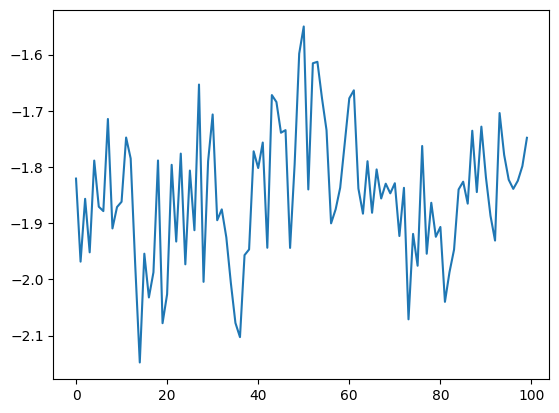

In [32]:
import matplotlib.pyplot as plt  
plt.plot(energy_values)

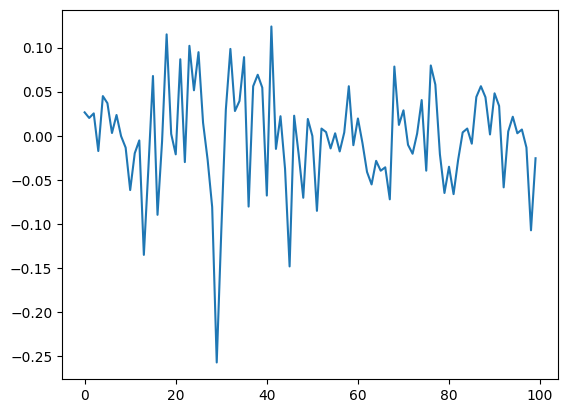

In [31]:
plt.plot(im_values)

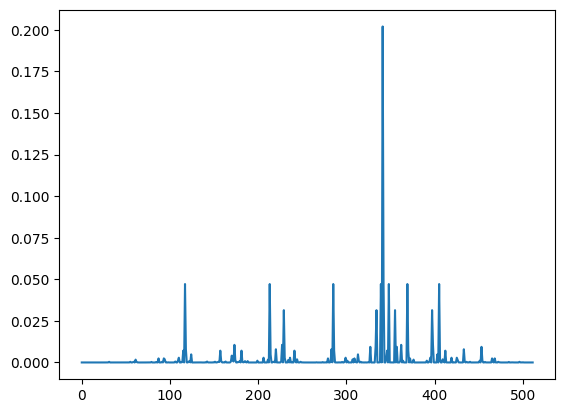

In [134]:
import matplotlib.pyplot as plt

outputs=model_empty(GT_batch_complete)
prob_ampl=tf.abs(tf.complex(outputs[:,0] * tf.cos(outputs[:,1]),outputs[:,0] * tf.sin(outputs[:,1])))**2
prob_coeff=prob_ampl/tf.reduce_sum(prob_ampl)
plt.plot(prob_coeff)

In [ ]:
GT_batch_mc=initialize_graph_tuples_tf_opt(128,graph, sublattice_encoding=subl)
GT_batch_mc, psi_coeff=sampler_var.monte_carlo_update_on_batch(model_empty,GT_batch_mc)


## Training from the chekpoint with stoch grad

In [205]:
compute_exact_energy(model_empty, GT_batch_mc, edge_pairs, template_graph, J2=0.0)

<tf.Tensor: shape=(), dtype=float32, numpy=-1.8024287>

In [34]:
import importlib

import compgraph.tensorflow_version.model_loading
importlib.reload(compgraph.tensorflow_version.model_loading)

from compgraph.monte_carlo import MCMCSampler, compute_phi_terms
from simulation.tf_simulation_checkpoints import improved_stochastic_gradients


In [42]:
from compgraph.tensorflow_version.model_loading import load_model_from_path, extract_hyperparams_from_path
from simulation.initializer import initialize_NQS_model_fromhyperparams
from simulation.initializer import create_graph_from_ham
import sonnet as snt  

path_model_trained='/home/s3378209/data1/repfin/thesis_MSc/checkpointed_logs/system_Heisenberg/2dsquare_03_03_Neel/beta0.2__bs_128lr7.0e-05_loop256x18_overlap_VMC/GNN2adv_h128_e64_K2/checkpoints/ckpt-6'
hyperparams_from_path=extract_hyperparams_from_path(path_model_trained)
model_empty=initialize_NQS_model_fromhyperparams(hyperparams_from_path.ansatz, hyperparams_from_path.ansatz_params)
model_fix=initialize_NQS_model_fromhyperparams(hyperparams_from_path.ansatz, hyperparams_from_path.ansatz_params)
graph,subl=create_graph_from_ham(hyperparams_from_path.graph_params.graphType,(hyperparams_from_path.graph_params.n,hyperparams_from_path.graph_params.m)
                                 ,sublattice=hyperparams_from_path.graph_params.sublattice)
GT_batch_sym=initialize_graph_tuples_tf_opt(64, graph, subl)
optimizer_empty=snt.optimizers.Adam(hyperparams_from_path.sim_params.learning_rate)
before=(model_empty(GT_batch_sym)[0])
load_model_from_path(model_empty,path_model_trained,optimizer_empty)
model_empty(GT_batch_sym)[0],before


/home/s3378209/data1/envs/gnets2/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


(<tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 0.01485351, -0.3464495 ], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 0.6914342, -0.8827515], dtype=float32)>)

In [36]:
compute_exact_energy(model_empty, GT_batch_complete, edge_pairs, template_graph, J2=0.0)

<tf.Tensor: shape=(), dtype=float32, numpy=-1.8191572>

In [40]:
GT_batch_update=initialize_graph_tuples_tf_opt(32, graph, subl)
model_w=model_empty
thermalization=1000
for i in range(thermalization):
    GT_batch_update, psi_new=sampler_var.monte_carlo_update_on_batch(model_w,GT_batch_update)
en, std, loc_en= stochastic_energy_tf(psi_new, model_w, edge_pairs,template_graph, GT_batch_update, J2=0.0)
en, std

(<tf.Tensor: shape=(), dtype=complex64, numpy=(-1.6626925+0.08481736j)>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.7228278>)

In [73]:
GT_batch_update=initialize_graph_tuples_tf_opt(2048, graph, subl)


In [74]:
get_single_graph_from_batch(GT_batch_update, 217).nodes[:,0]

<tf.Tensor: shape=(9,), dtype=float32, numpy=array([-1.,  1.,  1., -1.,  1., -1.,  1., -1., -1.], dtype=float32)>

In [147]:
from compgraph.tensorflow_version.hamiltonian_operations import graph_hamiltonian_jit_xla
from compgraph.tensorflow_version.graph_tuple_manipulation import get_single_graph_from_batch

@tf.function()
def stochastic_energy_tf(psi_new,model_var, edge_pairs,template_graph, GT_Batch,J2):

    batch_size = tf.shape(GT_Batch.n_node)[0]
    psi_coeff=tf.complex(
            psi_new[:,0] * tf.cos( psi_new[:,1] ),
            psi_new[:,0]  * tf.sin( psi_new[:,1] ))
    def compute_local_energy(gt,i,model_var):
        """
        Compute the local energy for a single graph in the batch:
        1. Generate all Hamiltonian configurations/amplitudes for this graph.
        2. Evaluate ψ(s) for original configuration.
        3. Batch evaluate ψ(s') for all H-induced configurations.
        4. Compute local energy: Σ (ham_coeff * ψ(s')/ψ(s)) 
        5. Return the local energy.
        """

        new_graphs, ham_amplitudes = graph_hamiltonian_jit_xla(gt, edge_pairs, J2, template_graph)

        psi_s=psi_coeff[i]

        model_outputs = model_var(new_graphs)  
        amplitudes = model_outputs[:, 0]
        phases = model_outputs[:, 1]
        psi_s_prime = tf.complex(
            amplitudes * tf.cos(phases),
            amplitudes * tf.sin(phases))

        ratios = psi_s_prime / psi_s
        ham_amplitudes = tf.cast(ham_amplitudes, tf.complex64)
        # del psi_s, psi_s_prime
        return tf.reduce_sum(ham_amplitudes * ratios)
    def single_graph_energy(i):
        single_graph = get_single_graph_from_batch(GT_Batch, i)
        return compute_local_energy(single_graph,i,model_var)
    local_energies = tf.map_fn(
        single_graph_energy,
            tf.range(batch_size),
         dtype=tf.complex64
    )
    del psi_coeff
    mean_energy=tf.reduce_mean(local_energies)
    energy_std=tf.sqrt(tf.reduce_mean(tf.abs(local_energies - mean_energy)**2))    
    return mean_energy, energy_std, local_energies



In [200]:
GT_batch_mc_v9=initialize_graph_tuples_tf_opt(64,graph, sublattice_encoding=subl)
GT_batch_mc_v9, psi_new = sampler_var.monte_carlo_update_on_batch(model_w, GT_batch_mc_v9)

%timeit for i in range(15): sampler_var.monte_carlo_update_on_batch(model_w,GT_batch_mc_v9)
%timeit stochastic_energy_tf(psi_new, model_w, edge_pairs, template_graphs_output, GT_batch_mc_v9, 0.0)
%timeit stochastic_energy_tf(psi_new, model_w, edge_pairs, template_graphs_output, GT_batch_mc_v9, 0.0)

41.7 ms ± 214 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
128 ms ± 1.67 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
133 ms ± 1.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [201]:
@tf.function()
def compute_phi_terms(batched_graphs, sampler, model):
    batch_size = tf.shape(batched_graphs.n_node)[0]
    # print("This is the batch size",batch_size)
    # print("This is the batched graphs",batched_graphs)
    # Map over each graph in the batch.

    def single_graph_phi(i):
        single_graph = get_single_graph_from_batch(batched_graphs, i)
        # print("This is the single graph",single_graph)
        return sampler.time_evoluted_config_amplitude_tf(single_graph, model)
    
    # tf.map_fn will execute single_graph_phi for each index in [0, batch_size)
    return tf.map_fn(single_graph_phi, tf.range(batch_size), dtype=tf.complex64)


In [202]:
compute_exact_energy(model_w, GT_batch_complete, edge_pairs, template_graph, J2=0.0)

<tf.Tensor: shape=(), dtype=float32, numpy=4.483334>

In [207]:
model_w=initialize_NQS_model_fromhyperparams(hyperparams_from_path.ansatz, hyperparams_from_path.ansatz_params)
compute_exact_energy(model_w, GT_batch_complete, edge_pairs, template_graph, J2=0.0)

/home/s3378209/data1/envs/gnets2/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


<tf.Tensor: shape=(), dtype=float32, numpy=4.4833345>

In [208]:
import time
from compgraph.useful import copy_to_non_trainable

@tf.function()
def stochastic_gradients_tfv3(phi_terms, GT_Batch_update, model):
        with tf.GradientTape() as tape:
            psi = model(GT_Batch_update)
            psi_coeff=tf.complex(
                 real=psi[:, 0] * tf.cos(psi[:, 1]),
                 imag=psi[:, 0] * tf.sin(psi[:, 1]))
            # Compute the loss function
            log_psi_conj = tf.math.log(tf.math.conj(psi_coeff))
            ratio_phi_psi = tf.stop_gradient(phi_terms / psi_coeff)
            # print(ratio_phi_psi)
            stoch_loss= tf.reduce_mean(log_psi_conj) - tf.reduce_mean(ratio_phi_psi*log_psi_conj)/tf.reduce_mean(ratio_phi_psi)
            gradients = tape.gradient(tf.math.real(stoch_loss), model.trainable_variables)
        del tape, psi, psi_coeff, log_psi_conj, ratio_phi_psi

        return stoch_loss,gradients

hyperparams=hyperparams_from_path
optimizer=snt.optimizers.Adam(7e-4, 0.9,0.99)

GT_Batch_update=initialize_graph_tuples_tf_opt(128,graph, sublattice_encoding=subl)
sampler_var= MCMCSampler(GT_Batch_update)
sampler_te=MCMCSampler(GT_Batch_update, template_graphs_output,beta=0.07, edge_pairs=edge_pairs)
template_graphs_output=initialize_graph_tuples_tf_opt(tf.shape(edge_pairs)[0]+1, graph, sublattice_encoding=subl)
energy_real=[]
energy_imag=[]
std_energies=[]
magnetization=[]
grad_norms=[]
n_sites=hyperparams.graph_params.n*hyperparams.graph_params.m
thermalization=1000
for i in range(thermalization):
    GT_Batch_update, psi_new=sampler_var.monte_carlo_update_on_batch(model_w,GT_Batch_update)

for step in range(10):

    # Track timing and metrics for outer loop
    outer_start_time = time.time()
    # Update target model
    copy_to_non_trainable(model_w, model_fix)
    
    for innerstep in range(10):
        # Track all timings
        timing_metrics = {}
        global_step = step * hyperparams.sim_params.inner_loop + innerstep
        inner_start_time = time.time()
        
        # Monte Carlo updates
        mc_start = time.time()
        for i in range(2*n_sites):
            GT_Batch_update, psi_new = sampler_var.monte_carlo_update_on_batch(model_w, GT_Batch_update)
        timing_metrics['mc_duration'] = time.time() - mc_start
        print("Monte Carlo update duration:", timing_metrics['mc_duration'])
        # Phi terms computation
        phi_start = time.time()
        phi_terms = compute_phi_terms(GT_Batch_update, sampler_te, model_fix)
        timing_metrics['phi_terms_duration'] = time.time() - phi_start
        print("Phi terms computation duration:", timing_metrics['phi_terms_duration'])
        # Energy calculation
        energy_start = time.time()
        energy, std_energy, loc_energies = stochastic_energy_tf(
            psi_new, model_w, edge_pairs, template_graphs_output, GT_Batch_update, 0.0)
        timing_metrics['energy_duration'] = time.time() - energy_start
        print("Energy calculation duration:", timing_metrics['energy_duration'])
        # Gradient computation and optimization
        grad_start = time.time()
        # stoch_loss, stoch_grads, stoch_overlap, grad_norms = improved_stochastic_gradients(
        #     phi_terms, GT_Batch_update, model_w)
        stoch_loss, stoch_grads = stochastic_gradients_tfv3(
            phi_terms, GT_Batch_update, model_w)
        optimizer.apply(stoch_grads, model_w.trainable_variables)
        timing_metrics['gradient_duration'] = time.time() - grad_start
        print("Gradient computation duration:", timing_metrics['gradient_duration'])
        # Calculate magnetization
        spins = GT_Batch_update.nodes[:, 0]
        avg_spin = tf.reduce_mean(spins)
        timing_metrics['inner_step_duration'] = time.time() - inner_start_time
        
        # Collect training metrics
        training_metrics = {
            'energy_real': tf.math.real(energy),
            'energy_imag': tf.math.imag(energy),
            'std_energy': std_energy,
            'magnetization': avg_spin,
            'grad_norm': grad_norms
        }
        


        energy_real.append(tf.math.real(energy).numpy())
        energy_imag.append(tf.math.imag(energy).numpy())
        std_energies.append(std_energy.numpy())
        magnetization.append(avg_spin.numpy())
        print(f"Iteration {step}.{innerstep}: Energy = {energy.numpy():.6f}, "
                f"Magnetization = {avg_spin.numpy():.6f}, "
                f"Loss = {stoch_loss.numpy():.6f}")
        # Print timing metrics  
        for metric, duration in timing_metrics.items():
            print(f"{metric} duration:", duration)

        # Clean up temporary variables
        del stoch_loss, stoch_grads, energy, loc_energies, spins, avg_spin
        del psi_new, phi_terms
    
    # Track outer loop duration
    outer_duration = time.time() - outer_start_time
    print("Outer loop duration:", outer_duration)

    




This is the shape, dummy check for retracing! Tensor("strided_slice:0", shape=(), dtype=int32)
Monte Carlo update duration: 0.07332181930541992
Phi terms computation duration: 0.9517683982849121
Energy calculation duration: 0.7683053016662598


W0000 00:00:1744405572.013588 3729878 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Gradient computation duration: 5.9049036502838135
Iteration 0.0: Energy = 4.479502-0.000091j, Magnetization = 0.123264, Loss = -0.001248-0.000017j
mc_duration duration: 0.07332181930541992
phi_terms_duration duration: 0.9517683982849121
energy_duration duration: 0.7683053016662598
gradient_duration duration: 5.9049036502838135
inner_step_duration duration: 7.699238300323486
Monte Carlo update duration: 0.13049697875976562
Phi terms computation duration: 0.32149553298950195
Energy calculation duration: 0.2651996612548828
Gradient computation duration: 0.12117242813110352
Iteration 0.1: Energy = 3.090695-0.001439j, Magnetization = -0.090278, Loss = 0.180501-0.888586j
mc_duration duration: 0.13049697875976562
phi_terms_duration duration: 0.32149553298950195
energy_duration duration: 0.2651996612548828
gradient_duration duration: 0.12117242813110352
inner_step_duration duration: 0.8390927314758301
Monte Carlo update duration: 0.07978415489196777
Phi terms computation duration: 0.2656209468

In [242]:
psi_coeff=model_w(GT_batch_mc)
stochastic_energy_tf(psi_coeff, model_w, edge_pairs, template_graphs_output, GT_batch_mc, J2=0.0)


(<tf.Tensor: shape=(), dtype=complex64, numpy=(4.475883+0.0016468099j)>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.20488515>,
 <tf.Tensor: shape=(128,), dtype=complex64, numpy=
 array([4.3735566+1.46479411e-02j, 4.603059 -4.59487066e-02j,
        4.603886 +4.26994152e-02j, 4.2655344+3.33851278e-02j,
        4.3735614+1.46479988e-02j, 4.5294666-2.70251967e-02j,
        4.2560434+2.29294728e-02j, 4.506279 +4.16747481e-03j,
        4.4261265-8.31195805e-03j, 4.5      -2.92669045e-09j,
        4.427076 +1.37757659e-02j, 4.8196836-1.34527674e-02j,
        4.182414 +1.23746982e-02j, 4.382716 +1.49497986e-02j,
        4.5474796+4.65556933e-03j, 4.494162 -3.02504152e-02j,
        4.265836 +3.80374305e-02j, 4.3667235+1.68178286e-02j,
        5.005846 -9.07546058e-02j, 4.4115305+1.51965339e-02j,
        4.391493 +1.92959402e-02j, 4.5507073-4.96300869e-03j,
        4.411533 +1.51963299e-02j, 4.4270744+1.37759522e-02j,
        4.7213616+1.05353519e-02j, 4.524742 -4.88485694e-02j,
        4.809

In [241]:


termalization=1000
GT_batch_mc=initialize_graph_tuples_tf_opt(128,graph, sublattice_encoding=subl)
for i in range(thermalization):
    GT_batch_mc, psi_coeff=sampler_var.monte_carlo_update_on_batch(model_w,GT_batch_mc)



/home/s3378209/data1/envs/gnets2/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


This is the shape, dummy check for retracing! Tensor("strided_slice:0", shape=(), dtype=int32)


In [246]:
hist_counts, prob_coeff=get_prob_amplitudes_from_mc_sampling(GT_batch_mc, model_w, GT_batch_complete, n_samples=500)


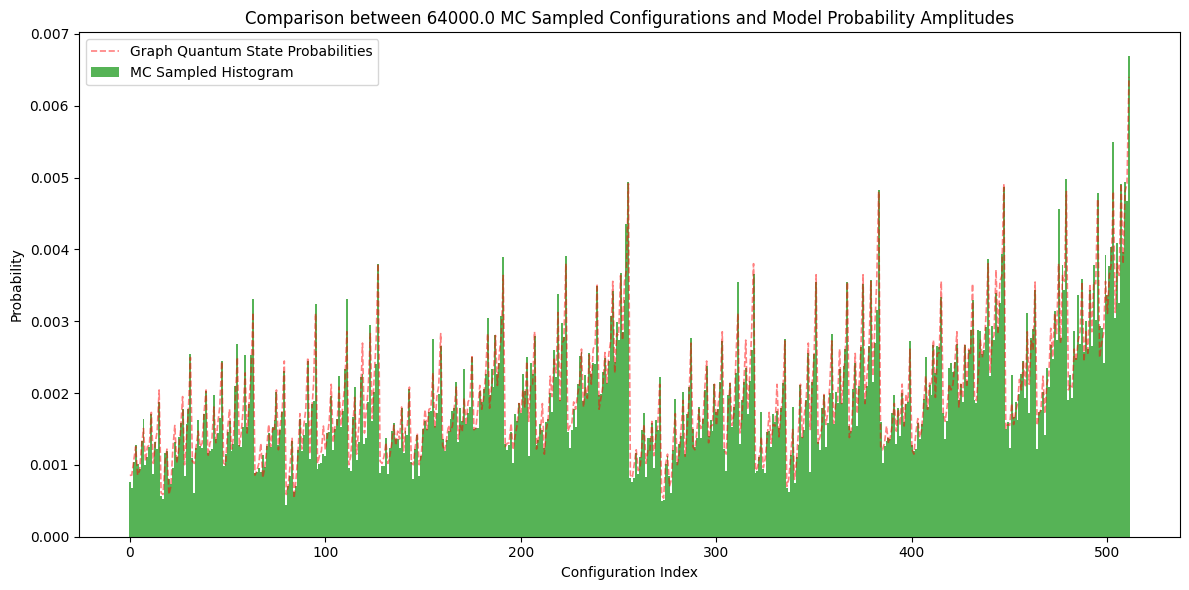

In [247]:
import numpy as np
import matplotlib.pyplot as plt
hist_prob = hist_counts/ np.sum(hist_counts)  # Normalize to get probabilities
num_bins = 2 ** num_nodes  # total number of configurations

plt.figure(figsize=(12, 6))

# Histogram from Monte Carlo sampling (bar plot)
plt.bar(
    np.arange(num_bins),
    hist_prob,
    width=1.0,
    alpha=0.8,
    color='tab:green',
    label='MC Sampled Histogram'
)

# Probability amplitudes from the full Hilbert space (dashed line plot)
# Use a dashed linestyle ('--'), reduce line width, and possibly reduce alpha
plt.plot(
    np.arange(num_bins),
    prob_coeff,
    color='red',
    linestyle='--',  # dashed line
    linewidth=1.2,   # thinner line
    alpha=0.5,       # partially transparent
    label='Graph Quantum State Probabilities'
)

plt.xlabel("Configuration Index")
plt.ylabel("Probability")
plt.title(f"Comparison between {(np.sum(hist_counts))} MC Sampled Configurations and Model Probability Amplitudes")
plt.legend()
plt.tight_layout()
plt.show()


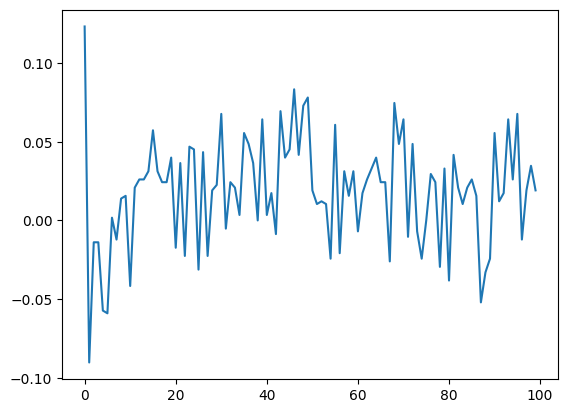

In [239]:
plt.plot(magnetization)

In [ ]:
    # copy_to_non_trainable(model_w, model_fix)


In [263]:
optimizer

Adam(learning_rate=0.0007, beta2=0.99)

In [352]:
#Keep going with the training
for step in range(400):

    # Track timing and metrics for outer loop
    outer_start_time = time.time()
    # Update target model
    copy_to_non_trainable(model_w, model_fix)
    
    for innerstep in range(10):
        # Track all timings
        global_step = step * hyperparams.sim_params.inner_loop + innerstep
        
        # Monte Carlo updates
        for i in range(2*n_sites):
            GT_Batch_update, psi_new = sampler_var.monte_carlo_update_on_batch(model_w, GT_Batch_update)
        # Phi terms computation
        phi_terms = compute_phi_terms(GT_Batch_update, sampler_te, model_fix)
        # Energy calculation
        energy, std_energy, loc_energies = stochastic_energy_tf(
            psi_new, model_w, edge_pairs, template_graphs_output, GT_Batch_update, 0.0)
        # Gradient computation and optimization
        stoch_loss, stoch_grads = stochastic_gradients_tfv3(
            phi_terms, GT_Batch_update, model_w)
        optimizer.apply(stoch_grads, model_w.trainable_variables)

        # Calculate magnetization
        spins = GT_Batch_update.nodes[:, 0]
        avg_spin = tf.reduce_mean(spins)
        
        # Collect training metrics
        training_metrics = {
            'energy_real': tf.math.real(energy),
            'energy_imag': tf.math.imag(energy),
            'std_energy': std_energy,
            'magnetization': avg_spin,
            'grad_norm': grad_norms
        }
        
        energy_real.append(tf.math.real(energy).numpy())
        energy_imag.append(tf.math.imag(energy).numpy())
        std_energies.append(std_energy.numpy())
        magnetization.append(avg_spin.numpy())
        print(f"Iteration {step}.{innerstep}: Energy = {energy.numpy():.6f}, "
                f"Magnetization = {avg_spin.numpy():.6f}, "
                f"Loss = {stoch_loss.numpy():.6f}")

        # Clean up temporary variables
        del stoch_loss, stoch_grads, energy, loc_energies, spins, avg_spin
        del psi_new, phi_terms
    
    # Track outer loop duration
    outer_duration = time.time() - outer_start_time
    print("Outer loop duration:", outer_duration)

Iteration 0.0: Energy = -3.755170-0.003129j, Magnetization = 0.012153, Loss = -0.011411+0.000428j
Iteration 0.1: Energy = -3.746412-0.007723j, Magnetization = 0.027778, Loss = -0.004025-0.021380j
Iteration 0.2: Energy = -3.704027+0.005208j, Magnetization = 0.012153, Loss = -0.044056+0.010589j
Iteration 0.3: Energy = -3.765694+0.003697j, Magnetization = -0.003472, Loss = -0.018283+0.013291j
Iteration 0.4: Energy = -3.822591-0.001359j, Magnetization = 0.003472, Loss = 0.014183-0.006425j
Iteration 0.5: Energy = -3.804169-0.008488j, Magnetization = 0.017361, Loss = -0.003955-0.002808j
Iteration 0.6: Energy = -3.795871-0.030014j, Magnetization = 0.019097, Loss = 0.016253-0.017391j
Iteration 0.7: Energy = -3.860381+0.002602j, Magnetization = 0.005208, Loss = 0.012004-0.003377j
Iteration 0.8: Energy = -3.778307+0.003411j, Magnetization = 0.013889, Loss = -0.000574+0.009470j
Iteration 0.9: Energy = -3.787211-0.002580j, Magnetization = 0.010417, Loss = 0.008504-0.003175j
Outer loop duration: 7.

In [339]:
def plot_energy_evolution(energy_values, std_values, batch_size, save_path=None):
    """
    Plot energy evolution over training with standard deviation.
    
    Parameters:
    -----------
    energy_values : list or array
        Energy values for each iteration
    std_values : list or array
        Standard deviation of energy at each iteration
    batch_size : int
        Batch size used in training
    samples : int
        Number of samples
    save_path : str, optional
        Path to save the figure
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Create iterations array
    iterations = np.arange(len(energy_values))
    
    # Plot energy values
    ax.plot(iterations, energy_values, 'o-', color='#1f77b4', markersize=1, 
            label='Energy Samples', alpha=0.4, linewidth=2)
    
    # Add shaded region for energy variance
    ax.fill_between(iterations, 
                    np.array(energy_values) - np.array(std_values),
                    np.array(energy_values) + np.array(std_values),
                    color='#ff7f0e', alpha=0.8,
                    label='Energy ± Std Dev')
    
    # Set labels and title
    ax.set_title(f'Energy Evolution during training for Batch Size: {batch_size}', 
                fontsize=14, fontweight='bold')
    ax.set_xlabel('Training Iterations', fontsize=12)
    ax.set_ylabel('Energy', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend(loc='best', framealpha=0.7)
    
    # Add text box with simulation summary
    textstr = '\n'.join((
        f'Batch Size: {batch_size}',
        f'Final Energy: {energy_values[-1]:.6f}'
    ))
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.03, 0.03, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='bottom', bbox=props)
    
    # Ensure good layout
    plt.tight_layout()
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=300)
    
    return fig, ax


In [353]:
std_en_of_mean=std_energies/tf.math.sqrt(tf.cast(GT_Batch_update.n_node.shape[0], dtype=tf.float32))

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Energy Evolution during training for Batch Size: 128'}, xlabel='Training Iterations', ylabel='Energy'>)

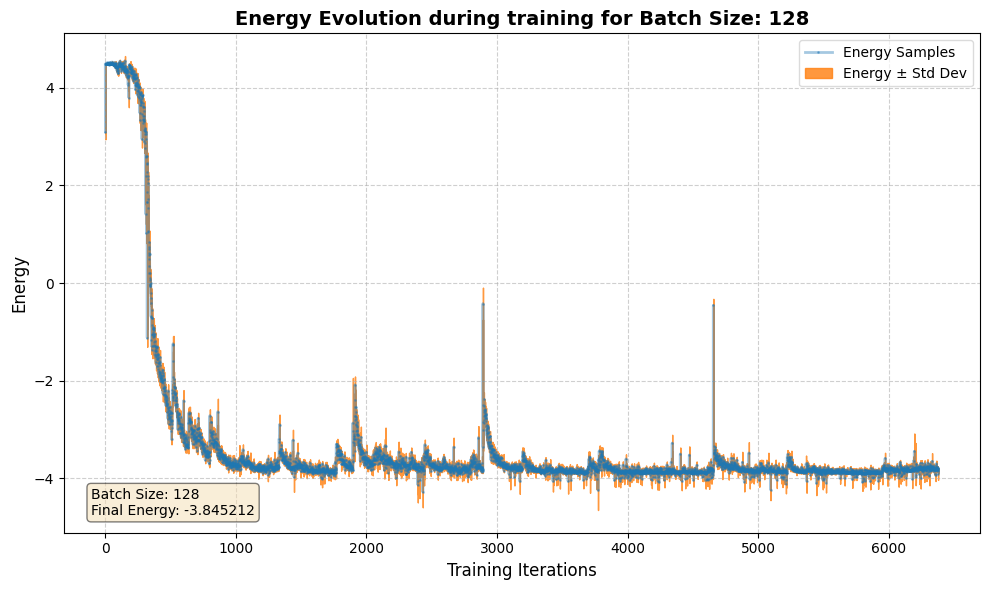

In [356]:
plot_energy_evolution(energy_real, std_en_of_mean, 128,  save_path='energy_evolution.png')

In [355]:
compute_exact_energy(model_w, GT_batch_complete, edge_pairs, template_graph, J2=0.0)

<tf.Tensor: shape=(), dtype=float32, numpy=-3.8350413>

In [348]:
psi_coeff=model_w(GT_batch_complete)
en, std_en, loc_en=stochastic_energy_tf(psi_coeff, model_w, edge_pairs, template_graphs_output, GT_batch_complete, J2=0.0)


(<tf.Tensor: shape=(), dtype=complex64, numpy=(-2.201451+17.762548j)>,
 <tf.Tensor: shape=(), dtype=float32, numpy=157.58871>,
 <tf.Tensor: shape=(128,), dtype=complex64, numpy=
 array([-1.14548512e+01-2.44285941e+00j,  6.96570435e+01+6.64647980e+01j,
        -1.67936844e+02-1.18454552e+01j, -5.51624451e+01+7.70972443e+01j,
        -8.73196697e+00+8.73003578e+00j,  4.40849915e+01-7.50359879e+01j,
         2.92248130e-01+7.37134695e+00j, -1.95217264e+00-1.04694259e+00j,
         4.41620140e+01-1.88637042e+00j, -1.51153028e-01-4.32019377e+00j,
        -1.41976047e+00+3.58084297e+00j, -6.32885284e+01+4.80719681e+01j,
        -2.94810963e+01+5.70624352e+00j, -3.14068970e+02+7.17303894e+02j,
        -4.10921431e+00-3.45316029e+00j, -1.36119747e+00+7.41893947e-02j,
         4.19459534e+00-6.29649544e+00j, -6.36959982e+00-4.66086245e+00j,
        -5.76741638e+02+2.59003754e+02j,  3.47996831e-01-4.40836668e-01j,
         1.16606264e+01-4.04043531e+00j, -4.16306257e+00+2.04276419e+00j,
        

/home/s3378209/data1/envs/gnets2/lib/python3.11/site-packages/tensorflow/python/framework/ops.py:294: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._numpy())
/home/s3378209/data1/envs/gnets2/lib/python3.11/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


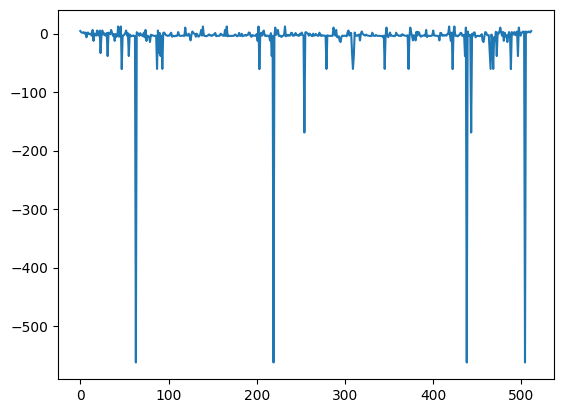

In [349]:
plt.plot(loc_en)

In [337]:
3.82/3.96

0.9646464646464646

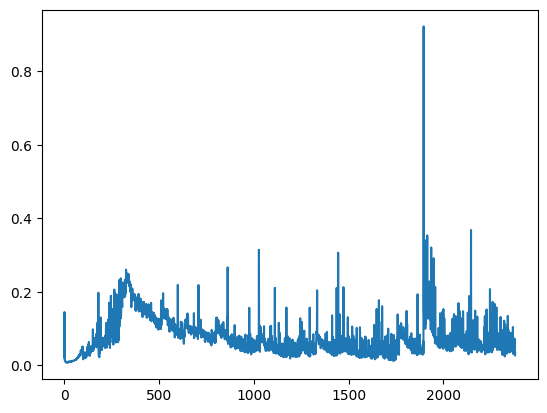

In [350]:
plt.plot(std_energies/tf.math.sqrt(tf.cast(GT_Batch_update.n_node.shape[0], dtype=tf.float32)))

In [316]:
hist_counts, prob_coeff=get_prob_amplitudes_from_mc_sampling(GT_batch_mc, model_w, GT_batch_complete, n_samples=500)


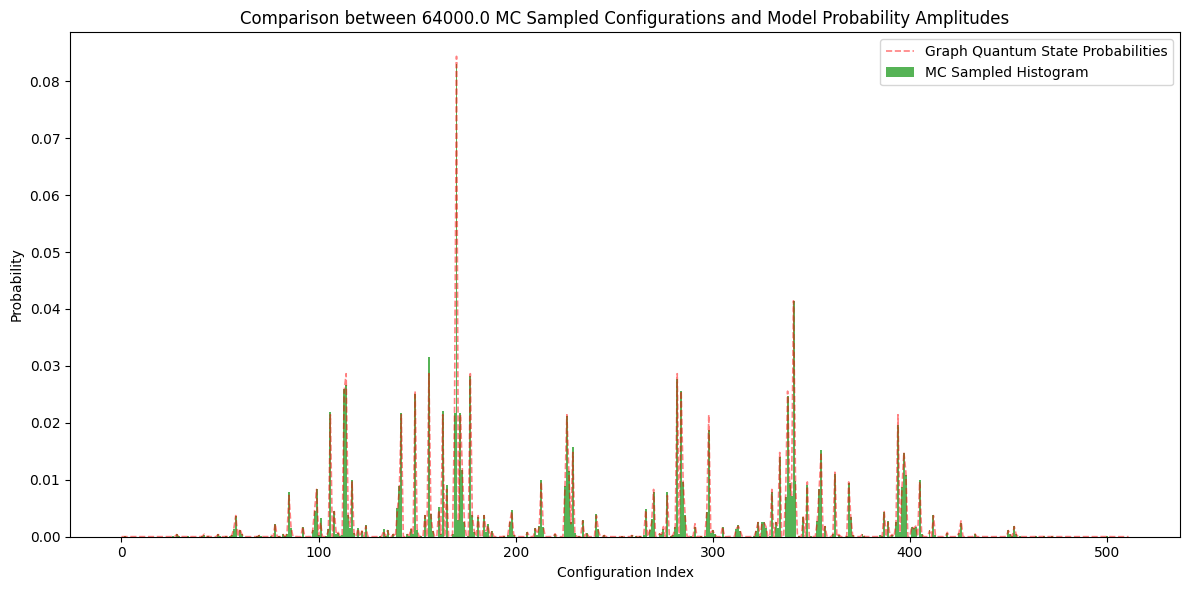

In [317]:
import numpy as np
import matplotlib.pyplot as plt
hist_prob = hist_counts/ np.sum(hist_counts)  # Normalize to get probabilities
num_bins = 2 ** num_nodes  # total number of configurations

plt.figure(figsize=(12, 6))

# Histogram from Monte Carlo sampling (bar plot)
plt.bar(
    np.arange(num_bins),
    hist_prob,
    width=1.0,
    alpha=0.8,
    color='tab:green',
    label='MC Sampled Histogram'
)

# Probability amplitudes from the full Hilbert space (dashed line plot)
# Use a dashed linestyle ('--'), reduce line width, and possibly reduce alpha
plt.plot(
    np.arange(num_bins),
    prob_coeff,
    color='red',
    linestyle='--',  # dashed line
    linewidth=1.2,   # thinner line
    alpha=0.5,       # partially transparent
    label='Graph Quantum State Probabilities'
)

plt.xlabel("Configuration Index")
plt.ylabel("Probability")
plt.title(f"Comparison between {(np.sum(hist_counts))} MC Sampled Configurations and Model Probability Amplitudes")
plt.legend()
plt.tight_layout()
plt.show()


In [318]:
compute_exact_energy(model_empty, GT_batch_complete, edge_pairs, template_graph, J2=0.0)

<tf.Tensor: shape=(), dtype=float32, numpy=-1.8191575>

In [319]:
compute_exact_energy(model_w, GT_batch_complete, edge_pairs, template_graph, J2=0.0)

<tf.Tensor: shape=(), dtype=float32, numpy=-3.825965>

In [132]:
outputs = model_empty(GT_batch_complete)
amplitudes = outputs[:, 0]
phases = outputs[:, 1]
psi = tf.complex(
    real=amplitudes * tf.cos(phases),
    imag=amplitudes * tf.sin(phases)
)

# Compute probabilities
probs = tf.abs(psi)**2
probs = probs / tf.reduce_sum(probs)

In [133]:
configs = GT_batch_complete.nodes[:, 0]
configs_reshaped = tf.reshape(configs, [2**n_sites, n_sites])
print(configs_reshaped)         
# Compute magnetization for each configuration
config_mags = tf.reduce_sum(configs_reshaped, axis=1) / n_sites

tf.Tensor(
[[-1. -1. -1. ... -1. -1. -1.]
 [ 1. -1. -1. ... -1. -1. -1.]
 [-1.  1. -1. ... -1. -1. -1.]
 ...
 [ 1. -1.  1. ...  1.  1.  1.]
 [-1.  1.  1. ...  1.  1.  1.]
 [ 1.  1.  1. ...  1.  1.  1.]], shape=(512, 9), dtype=float32)


In [134]:
magnetization = tf.reduce_sum(config_mags * tf.cast(probs, config_mags.dtype))
magnetization

<tf.Tensor: shape=(), dtype=float32, numpy=-8.121133e-06>

In [116]:
compute_exact_energy(model_w, GT_batch_complete, edge_pairs, template_graph, J2=0.0)

<tf.Tensor: shape=(), dtype=float32, numpy=-0.7604507>

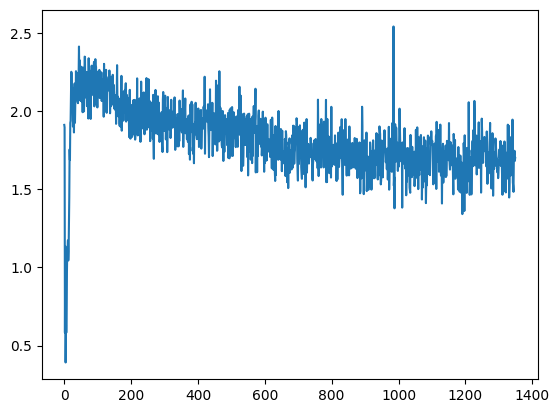

In [119]:
plt.plot(std_energies)

# Analyzing initialization issue in 4x4

In [58]:

import compgraph.tensorflow_version.model_loading
from compgraph.tensorflow_version.model_loading import check_and_reinitialize_model, load_model_from_path,extract_hyperparams_from_path
from simulation.initializer import create_graph_from_ham, initialize_NQS_model_fromhyperparams, initialize_hamiltonian_and_groundstate
from compgraph.tensorflow_version.graph_tuple_manipulation import initialize_graph_tuples_tf_opt, precompute_graph_structure
import sonnet as snt

path_ckpt='checkpointed_logs/system_Heisenberg/2dsquare_04_04_Neel/beta0.2__bs_128lr7.0e-04_loop1024x15_overlap_VMC/GNN2adv_h128_e64_K3/checkpoints/initial_model-1'
hyperparams=extract_hyperparams_from_path(path_ckpt)
graph,subl=create_graph_from_ham(hyperparams.graph_params.graphType,(hyperparams.graph_params.n,hyperparams.graph_params.m)
                                 ,sublattice=hyperparams.graph_params.sublattice)
GT_Batch_init=initialize_graph_tuples_tf_opt(128, graph, sublattice_encoding=subl)
model_w_from_training=initialize_NQS_model_fromhyperparams(hyperparams.ansatz, hyperparams.ansatz_params)
optimizer=snt.optimizers.Adam(hyperparams.sim_params.learning_rate,0.9,0.99)
before_loading=model_w_from_training(GT_Batch_init)[0]
load_model_from_path(model_w_from_training, path_ckpt,optimizer)
print(before_loading)
print("after loading",model_w_from_training(GT_Batch_init)[0])
# print(model_w_from_training(GT_Batch_init))
sen, rec, edge_pairs=precompute_graph_structure(graph)


tf.Tensor([-0.99537045 22.143848  ], shape=(2,), dtype=float32)
after loading tf.Tensor([-0.56789327 -0.5505771 ], shape=(2,), dtype=float32)


In [76]:
import importlib
importlib.reload(compgraph.tensorflow_version.model_loading)
from compgraph.tensorflow_version.model_loading import check_and_reinitialize_model, load_model_from_path,extract_hyperparams_from_path
import gc
gc.collect()
model_w_from_training=check_and_reinitialize_model(model_w_from_training, GT_Batch_init, hyperparams, tolerance=0.2, max_attempts=50)


Ciao first trial seconmd
Initial std: 0.001225 (tolerance: 0.2), attempt: 0/50,False


/home/s3378209/data1/envs/gnets2/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


tf.Tensor([-0.99537045 22.143848  ], shape=(2,), dtype=float32)
tf.Tensor([-0.99537045 22.143848  ], shape=(2,), dtype=float32)
tf.Tensor([-0.99537045 22.143845  ], shape=(2,), dtype=float32)
tf.Tensor([-0.99537045 22.143848  ], shape=(2,), dtype=float32)
tf.Tensor([-0.99537045 22.143848  ], shape=(2,), dtype=float32)
tf.Tensor([-0.99537045 22.143848  ], shape=(2,), dtype=float32)
tf.Tensor([-0.99537045 22.143848  ], shape=(2,), dtype=float32)
tf.Tensor([-0.99537045 22.143847  ], shape=(2,), dtype=float32)
tf.Tensor([-0.99537045 22.143845  ], shape=(2,), dtype=float32)


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x15555258b9d0>>
Traceback (most recent call last):
  File "/home/s3378209/data1/envs/gnets2/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


tf.Tensor([-0.99537045 22.143848  ], shape=(2,), dtype=float32)
tf.Tensor([-0.99537045 22.14385   ], shape=(2,), dtype=float32)
tf.Tensor([-0.99537045 22.143847  ], shape=(2,), dtype=float32)
tf.Tensor([-0.99537045 22.143848  ], shape=(2,), dtype=float32)
tf.Tensor([-0.99537045 22.143848  ], shape=(2,), dtype=float32)
tf.Tensor([-0.99537045 22.143848  ], shape=(2,), dtype=float32)
tf.Tensor([-0.99537045 22.143848  ], shape=(2,), dtype=float32)
tf.Tensor([-0.99537045 22.143848  ], shape=(2,), dtype=float32)
tf.Tensor([-0.99537045 22.14385   ], shape=(2,), dtype=float32)
tf.Tensor([-0.99537045 22.143848  ], shape=(2,), dtype=float32)
tf.Tensor([-0.99537045 22.143848  ], shape=(2,), dtype=float32)
tf.Tensor([-0.99537045 22.143848  ], shape=(2,), dtype=float32)
tf.Tensor([-0.99537045 22.143848  ], shape=(2,), dtype=float32)
tf.Tensor([-0.99537045 22.143848  ], shape=(2,), dtype=float32)
tf.Tensor([-0.99537045 22.14385   ], shape=(2,), dtype=float32)
tf.Tensor([-0.99537045 22.143848  ], sha

KeyboardInterrupt: 

In [68]:
outputs = model_w_from_training(GT_Batch_init)
std_output= tf.math.reduce_std(outputs[:,0]), tf.math.reduce_std(outputs[:,1])
std_output

(<tf.Tensor: shape=(), dtype=float32, numpy=0.0012250924>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.4251799>)

In [46]:
output=model_w_from_training(GT_Batch_init)
mean_output = tf.reduce_mean(output[:,0]), tf.reduce_mean(output[:,1])
mean_output

(<tf.Tensor: shape=(), dtype=float32, numpy=-0.58570385>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-0.56045055>)

In [51]:
std_output= tf.math.reduce_std(output[:,0]), tf.math.reduce_std(output[:,1])
tf.reduce_sum(std_output)

<tf.Tensor: shape=(), dtype=float32, numpy=0.06711807>

In [40]:
tf.math.(model_w_from_training(GT_Batch_init)[:,0])

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([-0.53002846, -0.5553243 , -0.558358  , -0.6254651 , -0.65473384,
       -0.64865655, -0.5856116 , -0.54233944, -0.55825496, -0.6845365 ,
       -0.5810403 , -0.52655226, -0.59557086, -0.527483  , -0.57658297,
       -0.5616044 , -0.6330822 , -0.5941429 , -0.59688866, -0.68484014,
       -0.549506  , -0.5582551 , -0.58483934, -0.5965739 , -0.6536532 ,
       -0.4828374 , -0.49361956, -0.5660297 , -0.49724236, -0.56519955,
       -0.57344615, -0.5873299 , -0.66810435, -0.49204448, -0.61496985,
       -0.6252847 , -0.5492416 , -0.59595   , -0.5928439 , -0.55988073,
       -0.5481079 , -0.521999  , -0.66269046, -0.59984636, -0.49204448,
       -0.6336192 , -0.67094153, -0.64253163, -0.56697506, -0.57729876,
       -0.5810404 , -0.717405  , -0.5014033 , -0.56559527, -0.49982324,
       -0.67101175, -0.5624623 , -0.5558609 , -0.6596995 , -0.60311157,
       -0.62120575, -0.59657395, -0.64732337, -0.57930213, -0.6591717 ,
       -0.533061

In [34]:
en, std_en, loc_en=stochastic_energy_tf(psi_new, model_w_from_training, edge_pairs, template_graphs_output, GT_Batch_init, J2=0.0)

In [35]:
std_en/tf.math.sqrt(tf.cast(loc_en.shape[0], tf.float32))

<tf.Tensor: shape=(), dtype=float32, numpy=0.097577855>

In [81]:
from compgraph.monte_carlo import MCMCSampler, compute_phi_terms
import tensorflow as tf
import time
from compgraph.useful import copy_to_non_trainable
from compgraph.tensorflow_version.hamiltonian_operations import stochastic_energy_tf
from compgraph.tensorflow_version.hamiltonian_operations import stochastic_gradients_tfv3,stochastic_overlap_gradient,stochastic_energy_tf
# model_fix=initialize_NQS_model_fromhyperparams(hyperparams.ansatz, hyperparams.ansatz_params)
# model_fix(GT_Batch_init)
GT_Batch_update=initialize_graph_tuples_tf_opt(128,graph, sublattice_encoding=subl)
sampler_var= MCMCSampler(GT_Batch_update)
template_graphs_output=initialize_graph_tuples_tf_opt(tf.shape(edge_pairs)[0]+1, graph, sublattice_encoding=subl)

sampler_te=MCMCSampler(GT_Batch_update, template_graphs_output,beta=0.07, edge_pairs=edge_pairs)
energy_real=[]
energy_imag=[]
std_energies=[]
magnetization=[]
grad_norms=[]
n_sites=hyperparams.graph_params.n*hyperparams.graph_params.m
thermalization=1000
for i in range(thermalization):
    GT_Batch_update, psi_new=sampler_var.monte_carlo_update_on_batch(model_w_from_training,GT_Batch_update)

for step in range(10):

    # Track timing and metrics for outer loop
    outer_start_time = time.time()
    # Update target model
    copy_to_non_trainable(model_w_from_training, model_fix)
    
    for innerstep in range(10):
        # Track all timings
        timing_metrics = {}
        global_step = step * hyperparams.sim_params.inner_loop + innerstep
        inner_start_time = time.time()
        
        # Monte Carlo updates
        mc_start = time.time()
        for i in range(2*n_sites):
            GT_Batch_update, psi_new = sampler_var.monte_carlo_update_on_batch(model_w_from_training, GT_Batch_update)
        timing_metrics['mc_duration'] = time.time() - mc_start
        # Phi terms computation
        phi_start = time.time()
        phi_terms = compute_phi_terms(GT_Batch_update, sampler_te, model_fix)
        timing_metrics['phi_terms_duration'] = time.time() - phi_start
        # Energy calculation
        energy_start = time.time()
        energy, std_energy, loc_energies = stochastic_energy_tf(
            psi_new, model_w_from_training, edge_pairs, template_graphs_output, GT_Batch_update, 0.0)
        timing_metrics['energy_duration'] = time.time() - energy_start
        print(energy,std_energy)
        grad_start=time.time()
        stoch_loss, stoch_grads = stochastic_gradients_tfv3(
            phi_terms, GT_Batch_update, model_w)
        optimizer.apply(stoch_grads, model_w.trainable_variables)
        timing_metrics['gradient_duration'] = time.time() - grad_start
        # Calculate magnetization
        spins = GT_Batch_update.nodes[:, 0]
        avg_spin = tf.reduce_mean(spins)
        timing_metrics['inner_step_duration'] = time.time() - inner_start_time
        
        # Collect training metrics
        training_metrics = {
            'energy_real': tf.math.real(energy),
            'energy_imag': tf.math.imag(energy),
            'std_energy': std_energy,
            'magnetization': avg_spin,
            'grad_norm': grad_norms
        }
        


        energy_real.append(tf.math.real(energy).numpy())
        energy_imag.append(tf.math.imag(energy).numpy())
        std_energies.append(std_energy.numpy())
        magnetization.append(avg_spin.numpy())
        print(f"Iteration {step}.{innerstep}: Energy = {energy.numpy():.6f}, "
                f"Magnetization = {avg_spin.numpy():.6f}, "
                f"Loss = {stoch_loss.numpy():.6f}")
        # Print timing metrics  
        for metric, duration in timing_metrics.items():
            print(f"{metric}:", duration)

        # Clean up temporary variables
        del stoch_loss, stoch_grads, energy, loc_energies, spins, avg_spin
        del psi_new, phi_terms
    
    # Track outer loop duration
    outer_duration = time.time() - outer_start_time
    print("Outer loop duration:", outer_duration)


This is the shape, dummy check for retracing! Tensor("strided_slice:0", shape=(), dtype=int32)
Monte Carlo update duration: 0.24862313270568848
Phi terms computation duration: 1.1299731731414795
Energy calculation duration: 0.3205749988555908
tf.Tensor((7.7797794+0.07682793j), shape=(), dtype=complex64) tf.Tensor(0.9911978, shape=(), dtype=float32)
Gradient computation duration: 0.131575345993042
Iteration 0.0: Energy = 7.779779+0.076828j, Magnetization = 0.008789, Loss = -0.011008-0.000068j
mc_duration duration: 0.24862313270568848
phi_terms_duration duration: 1.1299731731414795
energy_duration duration: 0.3205749988555908
gradient_duration duration: 0.131575345993042
inner_step_duration duration: 1.831847906112671
Monte Carlo update duration: 0.24753785133361816
Phi terms computation duration: 0.3477299213409424
Energy calculation duration: 0.32317614555358887
tf.Tensor((7.769925-0.13555516j), shape=(), dtype=complex64) tf.Tensor(1.0150495, shape=(), dtype=float32)
Gradient computati

In [411]:
import time
from compgraph.useful import copy_to_non_trainable

@tf.function()
def stochastic_gradients_tfv3(phi_terms, GT_Batch_update, model):
        with tf.GradientTape() as tape:
            psi = model(GT_Batch_update)
            psi_coeff=tf.complex(
                 real=psi[:, 0] * tf.cos(psi[:, 1]),
                 imag=psi[:, 0] * tf.sin(psi[:, 1]))
            # Compute the loss function
            log_psi_conj = tf.math.log(tf.math.conj(psi_coeff))
            ratio_phi_psi = tf.stop_gradient(phi_terms / psi_coeff)
            # print(ratio_phi_psi)
            stoch_loss= tf.reduce_mean(log_psi_conj) - tf.reduce_mean(ratio_phi_psi*log_psi_conj)/tf.reduce_mean(ratio_phi_psi)
            gradients = tape.gradient(tf.math.real(stoch_loss), model.trainable_variables)
        del tape, psi, psi_coeff, log_psi_conj, ratio_phi_psi

        return stoch_loss,gradients


GT_Batch_update=initialize_graph_tuples_tf_opt(128,graph, sublattice_encoding=subl)
sampler_var= MCMCSampler(GT_Batch_update)
sampler_te=MCMCSampler(GT_Batch_update, template_graphs_output,beta=0.07, edge_pairs=edge_pairs)
template_graphs_output=initialize_graph_tuples_tf_opt(tf.shape(edge_pairs)[0]+1, graph, sublattice_encoding=subl)
energy_real=[]
energy_imag=[]
std_energies=[]
magnetization=[]
grad_norms=[]
n_sites=hyperparams.graph_params.n*hyperparams.graph_params.m
thermalization=1000
for i in range(thermalization):
    GT_Batch_update, psi_new=sampler_var.monte_carlo_update_on_batch(model_w,GT_Batch_update)

for step in range(10):

    # Track timing and metrics for outer loop
    outer_start_time = time.time()
    # Update target model
    copy_to_non_trainable(model_w, model_fix)
    
    for innerstep in range(10):
        # Track all timings
        timing_metrics = {}
        global_step = step * hyperparams.sim_params.inner_loop + innerstep
        inner_start_time = time.time()
        
        # Monte Carlo updates
        mc_start = time.time()
        for i in range(2*n_sites):
            GT_Batch_update, psi_new = sampler_var.monte_carlo_update_on_batch(model_w, GT_Batch_update)
        timing_metrics['mc_duration'] = time.time() - mc_start
        print("Monte Carlo update duration:", timing_metrics['mc_duration'])
        # Phi terms computation
        phi_start = time.time()
        phi_terms = compute_phi_terms(GT_Batch_update, sampler_te, model_fix)
        timing_metrics['phi_terms_duration'] = time.time() - phi_start
        print("Phi terms computation duration:", timing_metrics['phi_terms_duration'])
        # Energy calculation
        energy_start = time.time()
        energy, std_energy, loc_energies = stochastic_energy_tf(
            psi_new, model_w, edge_pairs, template_graphs_output, GT_Batch_update, 0.0)
        timing_metrics['energy_duration'] = time.time() - energy_start
        print("Energy calculation duration:", timing_metrics['energy_duration'])
        # Gradient computation and optimization
        grad_start = time.time()
        # stoch_loss, stoch_grads, stoch_overlap, grad_norms = improved_stochastic_gradients(
        #     phi_terms, GT_Batch_update, model_w)
        stoch_loss, stoch_grads = stochastic_gradients_tfv3(
            phi_terms, GT_Batch_update, model_w)
        optimizer.apply(stoch_grads, model_w.trainable_variables)
        timing_metrics['gradient_duration'] = time.time() - grad_start
        print("Gradient computation duration:", timing_metrics['gradient_duration'])
        # Calculate magnetization
        spins = GT_Batch_update.nodes[:, 0]
        avg_spin = tf.reduce_mean(spins)
        timing_metrics['inner_step_duration'] = time.time() - inner_start_time
        
        # Collect training metrics
        training_metrics = {
            'energy_real': tf.math.real(energy),
            'energy_imag': tf.math.imag(energy),
            'std_energy': std_energy,
            'magnetization': avg_spin,
            'grad_norm': grad_norms
        }
        


        energy_real.append(tf.math.real(energy).numpy())
        energy_imag.append(tf.math.imag(energy).numpy())
        std_energies.append(std_energy.numpy())
        magnetization.append(avg_spin.numpy())
        print(f"Iteration {step}.{innerstep}: Energy = {energy.numpy():.6f}, "
                f"Magnetization = {avg_spin.numpy():.6f}, "
                f"Loss = {stoch_loss.numpy():.6f}")
        # Print timing metrics  
        for metric, duration in timing_metrics.items():
            print(f"{metric} duration:", duration)

        # Clean up temporary variables
        del stoch_loss, stoch_grads, energy, loc_energies, spins, avg_spin
        del psi_new, phi_terms
    
    # Track outer loop duration
    outer_duration = time.time() - outer_start_time
    print("Outer loop duration:", outer_duration)

    




This is the shape, dummy check for retracing! Tensor("strided_slice:0", shape=(), dtype=int32)


: 

In [400]:
stochastic_energy_tf(psi_coeff, model_w, edge_pairs, template_graphs_output, GT_batch_full, J2=0.0)

2025-04-12 02:40:58.050049: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at xla_ops.cc:574 : INVALID_ARGUMENT: Input to reshape is a tensor with 304 values, but the requested shape has 171

Stack trace for op definition: 
File "<frozen runpy>", line 198, in _run_module_as_main
File "<frozen runpy>", line 88, in _run_code
File "/home/s3378209/data1/envs/gnets2/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
File "/home/s3378209/data1/envs/gnets2/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
File "/home/s3378209/data1/envs/gnets2/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start
File "/home/s3378209/data1/envs/gnets2/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start
File "/home/s3378209/data1/envs/gnets2/lib/python3.11/asyncio/base_events.py", line 608, in run_forever
File "/home/s3378209/data1/envs/gnets2/lib/python3.11/asyncio/base_events.py",

InvalidArgumentError: Graph execution error:

Detected at node Reshape defined at (most recent call last):
<stack traces unavailable>
Detected at node Reshape defined at (most recent call last):
<stack traces unavailable>
2 root error(s) found.
  (0) INVALID_ARGUMENT:  Input to reshape is a tensor with 304 values, but the requested shape has 171

Stack trace for op definition: 
File "<frozen runpy>", line 198, in _run_module_as_main
File "<frozen runpy>", line 88, in _run_code
File "/home/s3378209/data1/envs/gnets2/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
File "/home/s3378209/data1/envs/gnets2/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
File "/home/s3378209/data1/envs/gnets2/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start
File "/home/s3378209/data1/envs/gnets2/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start
File "/home/s3378209/data1/envs/gnets2/lib/python3.11/asyncio/base_events.py", line 608, in run_forever
File "/home/s3378209/data1/envs/gnets2/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once
File "/home/s3378209/data1/envs/gnets2/lib/python3.11/asyncio/events.py", line 84, in _run
File "/home/s3378209/data1/envs/gnets2/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue
File "/home/s3378209/data1/envs/gnets2/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 534, in process_one
File "/home/s3378209/data1/envs/gnets2/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell
File "/home/s3378209/data1/envs/gnets2/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 362, in execute_request
File "/home/s3378209/data1/envs/gnets2/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 778, in execute_request
File "/home/s3378209/data1/envs/gnets2/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 449, in do_execute
File "/home/s3378209/data1/envs/gnets2/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
File "/home/s3378209/data1/envs/gnets2/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell
File "/home/s3378209/data1/envs/gnets2/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell
File "/home/s3378209/data1/envs/gnets2/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner
File "/home/s3378209/data1/envs/gnets2/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async
File "/home/s3378209/data1/envs/gnets2/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes
File "/home/s3378209/data1/envs/gnets2/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
File "/tmp/ipykernel_3725068/4119702115.py", line 6, in <module>
File "/home/s3378209/data1/repfin/thesis_MSc/tests/full_hilbert_malloc.py", line 138, in compute_exact_energy
File "/home/s3378209/data1/repfin/thesis_MSc/tests/full_hilbert_malloc.py", line 139, in compute_exact_energy
File "/home/s3378209/data1/repfin/thesis_MSc/tests/full_hilbert_malloc.py", line 86, in compute_local_energy
File "/home/s3378209/data1/repfin/thesis_MSc/compgraph/tensorflow_version/hamiltonian_operations.py", line 174, in graph_hamiltonian_jit_xla
File "/home/s3378209/data1/repfin/thesis_MSc/compgraph/tensorflow_version/graph_tuple_manipulation.py", line 115, in update_graph_tuples_config_jit

	 [[{{node Reshape}}]]
	tf2xla conversion failed while converting __inference_graph_hamiltonian_jit_xla_20199[]. Run with TF_DUMP_GRAPH_PREFIX=/path/to/dump/dir and --vmodule=xla_compiler=2 to obtain a dump of the compiled functions.
	 [[map/while/body/_1/map/while/PartitionedCall]]
	 [[map/while/loop_body_control/_130/_23]]
  (1) INVALID_ARGUMENT:  Input to reshape is a tensor with 304 values, but the requested shape has 171

Stack trace for op definition: 
File "<frozen runpy>", line 198, in _run_module_as_main
File "<frozen runpy>", line 88, in _run_code
File "/home/s3378209/data1/envs/gnets2/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
File "/home/s3378209/data1/envs/gnets2/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
File "/home/s3378209/data1/envs/gnets2/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start
File "/home/s3378209/data1/envs/gnets2/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start
File "/home/s3378209/data1/envs/gnets2/lib/python3.11/asyncio/base_events.py", line 608, in run_forever
File "/home/s3378209/data1/envs/gnets2/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once
File "/home/s3378209/data1/envs/gnets2/lib/python3.11/asyncio/events.py", line 84, in _run
File "/home/s3378209/data1/envs/gnets2/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue
File "/home/s3378209/data1/envs/gnets2/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 534, in process_one
File "/home/s3378209/data1/envs/gnets2/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell
File "/home/s3378209/data1/envs/gnets2/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 362, in execute_request
File "/home/s3378209/data1/envs/gnets2/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 778, in execute_request
File "/home/s3378209/data1/envs/gnets2/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 449, in do_execute
File "/home/s3378209/data1/envs/gnets2/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
File "/home/s3378209/data1/envs/gnets2/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell
File "/home/s3378209/data1/envs/gnets2/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell
File "/home/s3378209/data1/envs/gnets2/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner
File "/home/s3378209/data1/envs/gnets2/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async
File "/home/s3378209/data1/envs/gnets2/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes
File "/home/s3378209/data1/envs/gnets2/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
File "/tmp/ipykernel_3725068/4119702115.py", line 6, in <module>
File "/home/s3378209/data1/repfin/thesis_MSc/tests/full_hilbert_malloc.py", line 138, in compute_exact_energy
File "/home/s3378209/data1/repfin/thesis_MSc/tests/full_hilbert_malloc.py", line 139, in compute_exact_energy
File "/home/s3378209/data1/repfin/thesis_MSc/tests/full_hilbert_malloc.py", line 86, in compute_local_energy
File "/home/s3378209/data1/repfin/thesis_MSc/compgraph/tensorflow_version/hamiltonian_operations.py", line 174, in graph_hamiltonian_jit_xla
File "/home/s3378209/data1/repfin/thesis_MSc/compgraph/tensorflow_version/graph_tuple_manipulation.py", line 115, in update_graph_tuples_config_jit

	 [[{{node Reshape}}]]
	tf2xla conversion failed while converting __inference_graph_hamiltonian_jit_xla_20199[]. Run with TF_DUMP_GRAPH_PREFIX=/path/to/dump/dir and --vmodule=xla_compiler=2 to obtain a dump of the compiled functions.
	 [[map/while/body/_1/map/while/PartitionedCall]]
0 successful operations.
0 derived errors ignored. [Op:__inference_stochastic_energy_tf_21243613]

In [ ]:
    summary_writer, log_dir = setup_tensorboard_loggingv2(hyperparams,'checkpointed_logs')
    print("\nTensorBoard logs written to:", log_dir)
    print("To view the results, run:")
    print(f"tensorboard --logdir {log_dir}")
    physical_devices = tf.config.list_physical_devices('GPU')
    time_start= time.time()  # [Integration] Start timing the entire simulation.
    GT_Batch_update=GT_Batch_init
    thermalization_steps=1000
    for i in range(thermalization_steps):
       if hyperparams.simulation_type=="VMC2spins":
            GT_Batch_update, psi_new=sampler_var.monte_carlo_update_on_batchv2(model_w,GT_Batch_update)
       elif hyperparams.simulation_type=="VMC":
           GT_Batch_update, psi_new=sampler_var.monte_carlo_update_on_batch(model_w,GT_Batch_update)
    tf.print(f"Thermalization completed in {time.time()-time_start:.2f} seconds.")
    del GT_Batch_init
    template_graphs_output=initialize_graph_tuples_tf_opt(tf.shape(edge_pairs)[0]+1,graph,sublattice_encoding=subl)